In [1]:
import numpy as np
import dsp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import os
import pandas as pd
from scipy import stats
from fastcomputeA import fastcomputeA
from matplotlib.patches import Polygon
import networkx as nx
import cv2
from sklearn.cluster import KMeans
from matplotlib import colormaps
import edfio
#import precompute_windows as pcw

# Finding Files

In [2]:
mainfolder = "C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\"

In [3]:
mask = 3

In [4]:
def find_files_by_extension(root_folder, extension):
    matching_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(extension):
                matching_files.append(os.path.join(root, file))
    return matching_files


fileList = find_files_by_extension((mainfolder + "Data\\eeg"),'closed_eeg.vhdr')
for i in range(len(fileList)):
    print(i, fileList[i])

0 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa02\eeg\sub-CBPpa02_task-closed_eeg.vhdr
1 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa04\eeg\sub-CBPpa04_task-closed_eeg.vhdr
2 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa05\eeg\sub-CBPpa05_task-closed_eeg.vhdr
3 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa07\eeg\sub-CBPpa07_task-closed_eeg.vhdr
4 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa08\eeg\sub-CBPpa08_task-closed_eeg.vhdr
5 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa09\eeg\sub-CBPpa09_task-closed_eeg.vhdr
6 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa10\eeg\sub-CBPpa10_task-closed_eeg.vhdr
7 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa11\eeg\sub-CBPpa11_task-closed_eeg.vhdr
8 C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-C

In [5]:
def find_dirs_by_extension(root_folder, extension):
    matching_dirs = []
    for root, subdirs, dirs in os.walk(root_folder):
        print(root)
        print(subdirs)
        print(dirs)
        for name in subdirs:
            if name.endswith(extension):
                matching_dirs.append(os.path.join(root, name)) 
                # print(matching_dirs)
    return matching_dirs

# Preprocessing

In [6]:
keep_channels = pd.read_table(mainfolder + "\\Data\\eeg\\sub-CBPpa02\\eeg\\sub-CBPpa02_task-closed_channels.tsv")
keep_channels = keep_channels.to_numpy()

# print(keep_channels.shape)
# print(keep_channels[0,0])

keep_channels = keep_channels[:,0]

keep_channels = np.delete(keep_channels, (30,31,64,65))
# keep_channels = np.delete(keep_channels, (16,17,20,21,30,31,64,65))

# keep_channels = np.delete(keep_channels, (20,21,30,31,64,65))
# keep_channels = np.delete(keep_channels, (20,21,30,31,40,41,64,65))



keep_channels = [
    "Fp1",
    "Fp2",
    "F3",
    "F4",
    "F7",
    "F8",
    "T7",
    "T8",
    "P7",
    "P8",
    "P3",
    "P4",
    "O1",
    "O2",
    "Fz",
    "Cz",
    "Pz",
    "C3",
    "C4"
]



keep_channels = list(keep_channels)

chl = len(keep_channels)

In [7]:
print(chl)

19


In [8]:
# cleanornoisy = "noisy"
# cleanornoisy = "clean"

def preprocess_eeg(raweeg):
    # Select 10-20 Channels and set average reference
    #eeg.rename_channels(rename_channels)  #- comment out if the EEG has channels T7, T8, P7, or P8 
    ##mine has those channels

    raweeg.pick(keep_channels)
    raweeg.load_data()
    # raweeg.resample(650)
    # raweeg.filter(1, h_freq=65)
    # raweeg.filter(1, h_freq=40)
    # raweeg.filter(1, h_freq=99)
    raweeg.filter(l_freq=1, h_freq=30)
    # raweeg.filter(1, None)

    # raweeg.filter(0, None)
    # raweeg.l_freq=1

    # raweeg.filter(1, h_freq=20)

    ##making the h freq 40 worked really well for some reason
    
    # raweeg.set_eeg_reference('average')    #- comment out if your EEG doesn't have reference channels 
    
    # ##not sure if I do 
    # ##I found it-I do have a reference
    # ##says all are referenced to electrode FCz
    # ##however, FCz is the only one that shows on the electrodes tsv file but not the channels file
    # ##i guess maybe it's already referenced to it and I'm not supposed to replace average
    
    raweeg.set_montage('standard_1020')
    
    # Apply ICA and reject non brain components
    # Do ICA
    ica = ICA(
        n_components=len(keep_channels),
        max_iter=1000,
        method="infomax",
        random_state=29,
        fit_params=dict(extended=True),
    )
    ica.fit(raweeg)

    print(ica.n_iter_)
        
    # Auto label ICA components and reject
    ic_labels = label_components(raweeg, ica, method="iclabel")
    labels = ic_labels["labels"]
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
    ica.apply(raweeg, exclude=exclude_idx)
    
    # raweeg.filter(1, 40)
    end = np.floor(raweeg.times[-1]) - 0.005
    raweeg.crop(0, end)
    
    # raweeg.info['bads'].extend(['C3', 'C4', 'Cz', 'Pz', 'Fz'])
    # raweeg = raweeg.drop_channels(eeg.info['bads'])
    
    return raweeg

In [9]:
# Load EEG and preprocess
#original was vhdr, code below is for edf/set
##mine is vhdr

# def load(i):
#     eeg_filename = i
#     print(eeg_filename)
#     #might need to re run 20 and 325
#     eeg = mne.io.read_raw_brainvision(eeg_filename)
#     eeg_preprocessed = preprocess_eeg(eeg)
#     return


#eeg_preprocessed = eeg



# Feature Extraction
Extract A matrices, source sink, and powers for each window

In [10]:
# A matrix parameters in seconds
# window_length = 0.019
# window_length = 0.125
# window_length = 0.075
# window_length = 0.135
# window_length = 0.45
# window_length = 0.300
window_length = 0.045
# window_length = 0.25

# window_length = 0.25
# window_length = 0.5

window_advance = window_length
# alpha = 1e-10
alpha = 1e-12
# alpha = 1.5e-18
# alpha = 1e-9

# alpha = 1e-20
# alpha = 0

In [11]:
# Initialize feature lists
ahats = []
sink_indices = []
source_indices = []
source_influences = []
sink_connectivities = []
ssis = []
powers = []
evals = []
ahatswdiag = []

In [12]:
# Loop and get all features
def features():
    eeg_preprocessed.load_data()
    fs = eeg.info['sfreq']
    window_length_samples = int(fs * window_length)
    window_advance_samples = int(fs * window_advance)
    
    # Loop over the data
    window_start = 0
    data = eeg.get_data()
    nsamples = data.shape[1]
    while window_start <= (nsamples - window_length_samples):
    
        # Advance window
        window_start += window_advance_samples
    
        # Standardize the data
        X = data[:, window_start:window_start + window_length_samples]
        mean_vec = np.mean(X, axis=1)
        X_mean_subtract = X - mean_vec[:, np.newaxis]
        std = np.std(X_mean_subtract, axis=1)
        X_standardized = X / std[:, np.newaxis]
    
        # Store A hats
        ##there is something wrong with these
        
        ahat = dsp.computeA(X, alpha)
        ahats.append(ahat)
    
        # Calculate source sink features and store
        sink_idx, source_idx, source_influence, sink_connectivity, ssi = dsp.compute_source_sink_index(ahat)
        sink_indices.append(sink_idx)
        source_indices.append(source_idx)
        source_influences.append(source_influence)
        sink_connectivities.append(sink_connectivity)
        ssis.append(ssi)
    
        # Calculate power features and store
        powers.append(np.sum(X ** 2, axis=1))
    
        # Calculate evals
        vals, _ = np.linalg.eig(ahat)
        evals.append(vals)
        
    return

In [13]:
# Initialize feature lists
def featurelists():
    ahats = np.asarray(ahats)
    sink_indices = np.asarray(sink_indices)
    source_indices = np.asarray(source_indices)
    source_influences = np.asarray(source_influences)
    sink_connectivities = np.asarray(sink_connectivities)
    ssis = np.asarray(ssis)
    powers = np.asarray(powers)
    evals = np.asarray(evals)
    
    return

In [14]:
def computeA(xdata):
    """Compute the A transition matrix from a vector timeseries
    """
    ## this was broken because the linalg.inv function does not work
    
    nchns, T = xdata.shape
    
    Z = xdata[:, 0:T-1]
    #add row of 1s to Z, (n+1, t-1)
    Y = xdata[:, 1:T]
    
    Z2 = Z @ Z.transpose() + alpha*np.eye(chl)
    #add collumn of 1s to 
    
    # Z2 = Z[0:10,0:10]
    #ok so if i use 10 channels it should work
    ## this is not working

    Z2 = np.asarray(Z2)
    
    D = np.linalg.pinv(Z2)

    # D = np.linalg.inv(Z2)
    
    D2 = Z.transpose() @ D
        
    Ahat = Y @ D2
    #first n collumns is Ahat last collumn is bhat

    # Z2 = np.linalg.pinv(Z)
    
    # Ahat = Y @ Z2
    
    ## this is definitely broken
    ##IDK why this doesnt work anymore, my only guess is that there's some overflow or floating point imprecision stuff
    ##YEP, if i decrease the size of the array the inverse of it works
    ##still causing overflows
    ##i fixed it by using only some of the channels
    
    return Ahat

# print(computeA(X))

In [15]:
def stabilize_matrix(A, eigval):
    """
    Stabilize the matrix, A based on its eigenvalues.
    Assumes discrete-time linear system.
    Parameters
    ----------
    A : np.ndarray
         CxC matrix
    eigval : float
        the maximum eigenvalue to shift all large evals to
    Returns
        -------
        A : np.ndarray
            the stabilized matrix w/ eigenvalues <= eigval
        """
        # check if there are unstable eigenvalues for this matrix
    if np.sum(np.abs(np.linalg.eigvals(A)) > eigval) > 0:
            # perform eigenvalue decomposition
        eigA, V = np.linalg.eig(A)

            # get magnitude of these eigenvalues
        abs_eigA = np.abs(eigA)

            # get the indcies of the unstable eigenvalues
        unstable_inds = np.where(abs_eigA > eigval)[0]

            # move all unstable evals to magnitude eigval
        for ind in unstable_inds:
                # extract the unstable eval and magnitude
            unstable_eig = eigA[ind]
            this_abs_eig = abs_eigA[ind]

                # compute scaling factor and rescale eval
            k = eigval / this_abs_eig
            eigA[ind] = k * unstable_eig

            # recompute A
        eigA_mat = np.diag(eigA)
        Aprime = np.dot(V, eigA_mat)
        A = np.linalg.lstsq(V.T, Aprime.T)[0].T
    return A
# print(computeA(X))
# print(stabilize_matrix(computeA(X),1).real)

# Plots

In [16]:
def cluster(energy, clusters):
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(energy)
    
    changes=np.zeros((4,4), dtype=int)
    points=np.zeros((4,), dtype=int)
    for i in range(len(kmeans.labels_)-1):
        x=kmeans.labels_[i]
        y=kmeans.labels_[i+1]
        changes[x,y]+=1
        points[x]+=1
    points[y]+=1

    normalvarchange = np.var(changes.flatten())/energy.shape[1]
    normalvarpoint = np.var(points)/energy.shape[1]

    return normalvarchange, normalvarpoint

In [17]:
def naming():
    #Naming Figures 
    titleString = eeg_filename.split('\\')[10]
    titleString1 = titleString.split('_')[0]
    
    channelHeader = ",".join(keep_channels)
    
    #Placing Data into Directory 
    directory_path = (mainfolder + "directory\\") + titleString1 + "\\" + titleString
    os.makedirs(directory_path, exist_ok=True)
    return

In [18]:
def boxplot():
    # Box plot of all powers for each window
    fig, ax = plt.subplots(1, 1, figsize=(chl, 20), squeeze=False)
    ax[0,0].boxplot(powers, showfliers=False)
    
    # plt.boxplot(powers)
    ax[0,0].set_title("Power by Channel")
    ax[0,0].set_xticks(np.arange(1, chl+1), keep_channels)
    ##had to change number of channels
    plt.savefig(os.path.join(directory_path, (titleString + "_power_by_channel.png")))
    np.savetxt(os.path.join(directory_path, (titleString + "_power_by_channel.csv")), powers, delimiter=',', header = channelHeader)

    plt.cla()
    plt.clf()
    return

In [19]:
##boxplot effects the histogram
def histogram():
    # Histogram of A matrix values
    plt.hist(ahats.flatten(), bins=chl)
    plt.title("A Matrix")
    plt.xlabel("A Matrix Values")
    plt.savefig(os.path.join(directory_path, (titleString + "_A_matrix_values.png")))
    np.save(os.path.join(directory_path, (titleString + "_A_matrix_values.npy")), ahats)
    np.save(os.path.join(directory_path, (titleString + "diag_matrix_values.npy")), ahatswdiag)


    plt.cla()
    plt.clf()
    return

In [20]:
def eigen():
    # Plot eigenvalues on the complex plane
    plt.figure(figsize=(6, 6))
    
    all_evals = evals.flatten()
    # extract real part 
    x = [ele.real for ele in all_evals] 
    # extract imaginary part 
    y = [ele.imag for ele in all_evals]
    plt.scatter(x, y)



    
    # Unit circle
    x = np.sin(np.arange(0, 2*np.pi, 0.01))
    y = np.cos(np.arange(0, 2*np.pi, 0.01))
    plt.plot(x, y, color='k', linestyle='dashed')
    
    plt.title("Eigenvalues")
    plt.savefig(os.path.join(directory_path, (titleString + "_eigenvalues.png")))
    np.savetxt(os.path.join(directory_path, (titleString + "_eigenvalues.csv")), evals, delimiter=',', header = channelHeader)

    plt.cla()
    plt.clf()

    reals = []
    imags = []
    
    for idx in evals:
        real = [ele.real for ele in idx]
        imag = [ele.imag for ele in idx]
        reals.append(real)
        imags.append(imag)
    
    reals = np.asarray(reals)
    imags = np.asarray(imags)
    
    
    np.savetxt(os.path.join(directory_path, (titleString + "_eigen_real.csv")), reals, delimiter=',', header = channelHeader)
    np.savetxt(os.path.join(directory_path, (titleString + "_eigen_imag.csv")), imags, delimiter=',', header = channelHeader)

    
    return

In [21]:
def sink():
    # Histogram of sink values
    plt.hist(sink_indices.flatten(), bins=chl)
    plt.xlabel("Sink Indices")
    plt.savefig(os.path.join(directory_path, (titleString + "_sink_indices.png")))
    
    plt.cla()
    plt.clf()
    return

In [22]:
def scatter():
    # Scatterplot of source sink values
    plt.figure(figsize=(6, 6))
    plt.scatter(sink_indices.flatten(), source_indices.flatten())
    plt.xlabel("Sink Index")
    plt.ylabel("Source Index")
    plt.savefig(os.path.join(directory_path,(titleString + "_source_sink_index.png")))
    
    #save source and sink indicies
    np.savetxt(os.path.join(directory_path, (titleString + "_source_indicies.csv")), source_indices, delimiter=',', header = channelHeader)
    np.savetxt(os.path.join(directory_path, (titleString + "_sink_indices.csv")), sink_indices, delimiter=',', header = channelHeader)

    plt.cla()
    plt.clf()
    return


In [23]:
def reconstruct():
    # adjustedmatrix = ahatswdiag*(1.233213508)
    aproxeeg = []
    aproxdata = data[:,0]
    
    
    ##this is horrible and slow but just testing
    
    aproxeeg.append(aproxdata)
    
    i = 0
    while i < ahats.shape[0]:
    # while i < 200:
        # aproxpower = np.matmul(adjustedmatrix[i], aproxpower)
        l = 1 
        while l <= window_length_samples:
            aproxdata = ahatswdiag[i] @ aproxdata
            aproxeeg.append(aproxdata)
            l += 1
        i += 1
        aproxdata = data[:,(i*window_length_samples)]
    
    aproxeeg = np.asarray(aproxeeg)
    
    
    # print(aproxeeg[1,0])
    # print(powers[1,0])

    
    start = 0
    end = aproxeeg.shape[0]-1
    
    # start = 90000
    # end = 95000
    
    # start = 15000
    # end = 250
    # end = 16000
    # end = 20000
    
    view = 0
    # plt.ylim(-4e-5, 4e-5)
    
    
    # plt.plot(range(end+1)[start:end], data.transpose()[start:end,view])
    plt.plot(range(end+1)[start:end], aproxeeg[start:end,view])
    plt.plot(range(end+1)[start:end], data.transpose()[start:end,view])
    plt.savefig(os.path.join(directory_path, (titleString + "Data_vs_Reconstruction.png")))


    plt.cla()
    plt.clf()
    
    i = window_length_samples
    pcor = []
    while i < aproxeeg.shape[0]:
        s = stats.linregress(aproxeeg[i-window_length_samples:i,view], data.transpose()[i-window_length_samples:i,view])[2]
        pcor.append(s**2)
        i+=window_length_samples
    
    plt.plot(range(len(pcor)), pcor)
    plt.savefig(os.path.join(directory_path, (titleString + "r_over_time.png")))

    print(np.mean(pcor))

    plt.cla()
    plt.clf()

    return

In [24]:
# reconstruct()

In [25]:
norm = colors.LogNorm()
viridis = colormaps['viridis']
cmap = colors.LinearSegmentedColormap.from_list("normsvd", viridis.colors)

def plot_examples(colormaps, data):
    """
    Helper function to plot data with associated colormap.
    """    
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 * 4 + 2, 3 * 2),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=1)
        fig.colorbar(psm, ax=ax)

    # plt.title("correlation between channels")
    # plt.show()
    fig.savefig(os.path.join(directory_path, (titleString + "colormap_svds.svg")))
    np.savetxt(os.path.join(directory_path, (titleString + "SVD.csv")), SVDS, delimiter=',', header = channelHeader)
    # plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs","Pearsonbetweenchannels" + ".png"))
    plt.cla()
    plt.clf()
    return

In [26]:
def correlation_matrix(colormaps):
    cormat=np.zeros((chl,chl),dtype=float)
    for i in range(chl):
        for j in range(chl):
            s = stats.linregress(data[i], data[j])[2]
            cormat[i,j] = s
    # oldcormat = np.load(os.path.join(mainfolder + "Archive\\Old_Graphs\\PresentationDrawings","cormat" + ".npy"))
    # cormat=oldcormat-cormat
    
    """
    Helper function to plot data with associated colormap.
    """    
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 * 4 + 2, 3 * 2),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(cormat, cmap=cmap, rasterized=True, vmin=0, vmax=1)
        fig.colorbar(psm, ax=ax)

    plt.title("Correlation Between Channels (No BPF)")
    plt.yticks(range(chl), keep_channels)
    
    plt.xticks(range(chl), keep_channels)

    plt.show()
    # plt.savefig(os.path.join(directory_path, (titleString + "colormap_svds.svd")))
    # np.savetxt(os.path.join(directory_path, (titleString + "SVD.csv")), SVDS, delimiter=',', header = channelHeader)
    fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\PresentationDrawings","Pearsonbetweenchannelsnobpf" + ".svg"))
    # np.save(os.path.join(mainfolder + "Archive\\Old_Graphs\\PresentationDrawings","cormat" + ".npy"), cormat)

    # print(cormat)
    # plt.cla()
    # plt.clf()
    return

In [27]:
def r2andp():
    # adjustedmatrix = ahatswdiag*(1.233213508)
    aproxeeg = []
    aproxdata = data[:,0]
    
    
    ##this is horrible and slow but just testing
    
    aproxeeg.append(aproxdata)
    
    i = 0
    while i < ahatswdiag.shape[0]:
    # while i < 200:
        # aproxpower = np.matmul(adjustedmatrix[i], aproxpower)
        l = 1 
        while l <= window_length_samples:
            aproxdata = ahatswdiag[i] @ aproxdata
            aproxeeg.append(aproxdata)
            l += 1
        i += 1
        aproxdata = data[:,(i*window_length_samples)]
    
    aproxeeg = np.asarray(aproxeeg)
    
    
    # print(aproxeeg[1,0])
    # print(powers[1,0])

    
    start = 0
    end = aproxeeg.shape[0]-1
    view = 0

    # start = 90000
    # end = 95000
    
    # start = 15000
    # end = 250
    # end = 16000
    # end = 20000

    rlist = []
    plist = []
    
    while view < chl:
        r,p = stats.linregress(aproxeeg[start:end,view], data.transpose()[start:end,view])[2:4]
        rlist.append(r**2)
        plist.append(p)
        view+=1
    
    np.savetxt(os.path.join(directory_path, (titleString + "_r^2.csv")), rlist, delimiter=',', header = channelHeader)
    np.savetxt(os.path.join(directory_path, (titleString + "_p.csv")), plist, delimiter=',', header = channelHeader)
    return

In [28]:
def gfpmax():
    
    magnitude = []

    for i in data.transpose():
        magnitude.append(np.std(i))
        
    maximums = []


    
    for i in range(1, len(magnitude)-1):
        if magnitude[i] > magnitude[i-1] and magnitude[i] > magnitude[i+1] and int(np.trunc(i/125)) < sink_indices.shape[0]:
            maximums.append(i)

    maxdata = []
    maxsink = []
    
    for i in maximums:
        maxdata.append(data.transpose()[i])
        maxsink.append(sink_indices[int(np.trunc(i/125))])
    
    
    maxdata = np.asarray(maxdata)
    maxsink = np.asarray(maxsink)
    maximums = np.asarray(maximums)
    np.save(os.path.join(directory_path, (titleString + "_gfpmaximums.csv")), maximums) #shouldn't be .csv
    return maxdata, maxsink

In [29]:
# fake = mne.create_info(keep_channels, 1000, 'eeg')
# datar = mne.io.RawArray(data, fake)

# datar.set_montage('standard_1020')

# datar.info
# mne.channels.get_builtin_montages()

# fake = mne.channels.make_standard_montage('standard_1020', head_size='auto')
# fake.pick(keep_channels)
# # fake.Info[dig]



# montadata = mne.channels.DigMontage(


# mne.viz.plot_montage(

In [30]:
# sinktopomap()

In [31]:
def sinktopomap():
    # xypos = np.asarray(pd.read_table(mainfolder + 'Data/eeg/' + titleString1 + '/eeg/' + titleString1 + '_electrodes.tsv'))
    # dels = []
    # for i in range(xypos.shape[0]):
    #     if xypos[i,0] not in keep_channels:
    #         dels.append(i)
    # xypos = np.delete(xypos, np.asarray(dels), axis = 0)
    # xypos = xypos[:,1:3]
    # xypos = xypos.astype('float64')

    # mne.set_montage('standard_1020')

    # mean_values = np.mean(sink_indices, axis=0)  # Mean over time for single recording
    # maskkeep = np.zeros(2*mask)
    # maskkeep[0:mask]=(np.argpartition(mean_values, -mask)[-mask:])
    # maskkeep[mask:2*mask]=(np.argpartition(mean_values, -mask)[:mask])
    # maskkeep=maskkeep.astype(int)
    # print(maskkeep)
    # channel_names=[]
    # for n in maskkeep:
    #     channel_names.append(keep_channels[int(n)])
    # mean_values=mean_values[maskkeep]

    channel_names = keep_channels

    pos = np.array([montage.get_positions()["ch_pos"][ch][:2] for ch in channel_names])
    
    fig, ax = plt.subplots()
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(np.mean(maxsink, axis = 0), pos = xypos,  size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    mne.viz.plot_topomap(mean_values, pos,  size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = channel_names)



    # head outline not working
    fig.savefig(os.path.join(directory_path, (titleString + "gfpsinktopomap.svg")))
    # fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "gfpmax_energytopomapunhealthyexample" + ".svg"))
    return

In [32]:
def datatopomap():
    # xypos = np.asarray(pd.read_table(mainfolder + 'Data/eeg/' + titleString1 + '/eeg/' + titleString1 + '_electrodes.tsv'))
    # dels = []
    # for i in range(xypos.shape[0]):
    #     if xypos[i,0] not in keep_channels:
    #         dels.append(i)
    # xypos = np.delete(xypos, np.asarray(dels), axis = 0)
    # xypos = xypos[:,1:3]
    # xypos = xypos.astype('float64')
    # mean_values = np.mean(data, axis=1)  # Mean over time for single recording
    # maskkeep = np.zeros(2*mask)
    # maskkeep[0:mask]=(np.argpartition(mean_values, -mask)[-mask:])
    # maskkeep[mask:2*mask]=(np.argpartition(mean_values, -mask)[:mask])
    # maskkeep=maskkeep.astype(int)
    # print(maskkeep)
    # channel_names=[]
    # for n in maskkeep:
    #     channel_names.append(keep_channels[int(n)])
    # mean_values=mean_values[maskkeep]

    channel_names = keep_channels

    pos = np.array([montage.get_positions()["ch_pos"][ch][:2] for ch in channel_names])
        
    fig, ax = plt.subplots()
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(np.mean(maxdata, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    
    mne.viz.plot_topomap(mean_values, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)



    # head outline not working
    fig.savefig(os.path.join(directory_path, (titleString + "gfpdatatopomap.svg")))
    # fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "gfpmax_energytopomapunhealthyexample" + ".svg"))
    return

In [33]:
def energytopomap():
    # xypos = np.asarray(pd.read_table(mainfolder + 'Data/eeg/' + titleString1 + '/eeg/' + titleString1 + '_electrodes.tsv'))
    # dels = []
    # for i in range(xypos.shape[0]):
    #     if xypos[i,0] not in keep_channels:
    #         dels.append(i)
    # xypos = np.delete(xypos, np.asarray(dels), axis = 0)
    # xypos = xypos[:,1:3]
    # xypos = xypos.astype('float64')
    mean_values = np.mean(powers, axis=0)  # Mean over time for single recording
    
    # maskkeep = np.zeros(2*mask)
    # maskkeep[0:mask]=(np.argpartition(mean_values, -mask)[-mask:])
    # maskkeep[mask:2*mask]=(np.argpartition(mean_values, -mask)[:mask])
    # maskkeep=maskkeep.astype(int)
    # print(maskkeep)
    # channel_names=[]
    # for n in maskkeep:
    #     channel_names.append(keep_channels[int(n)])
    # mean_values=mean_values[maskkeep]

    channel_names = keep_channels

    pos = np.array([montage.get_positions()["ch_pos"][ch][:2] for ch in channel_names])
        
    fig, ax = plt.subplots()
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(np.mean(maxdata, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    
    mne.viz.plot_topomap(mean_values, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)



    # head outline not working
    fig.savefig(os.path.join(directory_path, (titleString + "energytopomap.svg")))
    # fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\topomapvideo", "topomap" + str(window_start) + ".png"))

    plt.cla()
    plt.clf()
    return

In [34]:
def savedata():
    np.save(os.path.join(directory_path, (titleString + "data.npy")), data)
    return

# Directory

In [35]:
print(chl)

19


In [36]:
print(xypos)

NameError: name 'xypos' is not defined

In [37]:
##locating information

if chl == 62:
    rootdir = (mainfolder + "directory")
if chl == 19:
    rootdir = (mainfolder + "10-20_directory")
#eyestate = '_task-open_eeg.vhdr'
fake = mne.create_info(keep_channels, 1000, 'eeg')
datar = mne.io.RawArray(np.zeros((chl,2)), fake)
datar.set_montage('standard_1020')
xypos = datar.info
montage = mne.channels.make_standard_montage("standard_1020")


Creating RawArray with float64 data, n_channels=19, n_times=2
    Range : 0 ... 1 =      0.000 ...     0.001 secs
Ready.


In [42]:
# window_length = 0.15
window_length = 0.015


# window_length = 0.25
# window_length = 0.5

# window_advance = window_length
    # preprocess then process
    
# for file in fileList:
file = fileList[60]
if file == file:
    window_length = 0.015
    while window_length <= 0.13:
        window_length+=0.01
        window_advance = window_length
    # for file in (fileList[0], fileList[30]):
                 # , fileList[60], fileList[90], fileList[120], fileList[150], fileList[180]):

    # for file in (fileList[1], fileList[2]):
        ahats = []
        sink_indices = []
        source_indices = []
        source_influences = []
        sink_connectivities = []
        ssis = []
        powers = []
        evals = []
        ahatswdiag = []
        SVDS = []
        
        ## I made a change here because I was confused about the raw eeg being called eeg and the eeg object from eeg_preprocessed.load_data()
        ##it doesnt do anything different so I wont change it back
        #load(file)
        eeg_filename = file
        print(eeg_filename)
        #might need to re run 20 and 325
        eeg = mne.io.read_raw_brainvision(eeg_filename)
        eeg = preprocess_eeg(eeg)
        ## I think my data may already be preprocessed
        
        print(eeg.info['chs'])
        #features()
        eeg.load_data()
        fs = eeg.info['sfreq']
        
        window_length_samples = int(fs * window_length)
        window_advance_samples = int(fs * window_advance)
        
        # Loop over the data
        # window_start = 100*window_advance_samples
        window_start = 0
        data = eeg.get_data()
        nsamples = data.shape[1]
    
    
        # this used to say <= which broke if it was =
        while window_start < (nsamples - window_length_samples):
                
            # Standardize the data
            X = data[:, window_start:window_start + window_length_samples]
            mean_vec = np.mean(X, axis=1)
            X_mean_subtract = X - mean_vec[:, np.newaxis]
            std = np.std(X_mean_subtract, axis=1)
            X_standardized = X / std[:, np.newaxis]
    
            ahat = computeA(X)
    
            # ahat = stabilize_matrix(ahat, 1.05).real
    
            
            blankArray = np.zeros((chl, chl - 1))
            
            #remove diagonal from ahat
            for idx, ele in enumerate(ahat):
                newRow = np.delete(ele, idx)
                blankArray[idx] = newRow
    
            ahats.append(blankArray)
            ahatswdiag.append(ahat)
    
            #calculate SVD
            # S = np.linalg.svd(X, full_matrices=True, compute_uv=False, hermitian=False)
            # SVDS.append(S)
    
            
            # Calculate source sink features and store
            # sink_idx, source_idx, source_influence, sink_connectivity, ssi = dsp.compute_source_sink_index(ahat)
            # sink_indices.append(sink_idx)
            # source_indices.append(source_idx)
            # source_influences.append(source_influence)
            # sink_connectivities.append(sink_connectivity)
            # ssis.append(ssi)
        
            # Calculate power features and store
            # powers.append(np.sum(X ** 2, axis=1))
            ## doesnt this just increase for a bigger x?
        
            # Calculate evals
            # vals, _ = np.linalg.eig(ahat)
            # evals.append(vals)
    
            #increment window
            window_start += window_advance_samples
    
        
    
        ahats = np.asarray(ahats)
        # sink_indices = np.asarray(sink_indices)
        # source_indices = np.asarray(source_indices)
        # source_influences = np.asarray(source_influences)
        # sink_connectivities = np.asarray(sink_connectivities)
        # ssis = np.asarray(ssis)
        # powers = np.asarray(powers)
        # evals = np.asarray(evals)
        ahatswdiag = np.asarray(ahatswdiag)
        # SVDS = np.asarray(SVDS)
    
        #naming()
        #Naming Figures 
        titleString = eeg_filename.split('\\')[10]
        titleString1 = titleString.split('_')[0]
        
        channelHeader = ",".join(keep_channels)
        
        #Placing Data into Directory 
        # directory_path = rootdir + "\\" + titleString1 + "\\" + titleString
        directory_path = rootdir + "\\" + titleString + "\\" + cleanornoisy + "\\" + str(window_length_samples) + "_samples"
        os.makedirs(directory_path, exist_ok=True)
    
        ######################
        # a_matrices = np.load(directory_path + "\\" + titleString + "diag_matrix_values.npy") 
        #####################
        
        # SVDentropy = stats.entropy(SVDS, axis = 1)
        # np.savetxt(os.path.join(directory_path, (titleString + "SVDentropy.csv")), SVDentropy, delimiter=',')
            
        histogram()    
    
        # boxplot()
        
        # eigen()
        
        # sink()
        
        # scatter()
    
        # reconstruct()
    
        # normsvd = norm(SVDS.transpose())
        # plot_examples([cmap], normsvd)
        #################################
        # r2andp()
        ####################################
    
        # maxdata, maxsink = gfpmax()
        
        # sinktopomap()
    
        # datatopomap()
    
        savedata()
        
print("Complete!")

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-FMpa05\eeg\sub-FMpa05_task-closed_eeg.vhdr
Extracting parameters from C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-FMpa05\eeg\sub-FMpa05_task-closed_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 362499  =      0.000 ...   362.499 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 19 components
Computing Extended Infomax ICA


KeyboardInterrupt: 

In [38]:
# preprocess then process

# for file in fileList:
file = fileList[0]
if file == fileList[0]:
# for file in (fileList[0], fileList[30], fileList[60], fileList[90], fileList[120], fileList[150], fileList[180]):

    ahats = []
    sink_indices = []
    source_indices = []
    source_influences = []
    sink_connectivities = []
    ssis = []
    powers = []
    evals = []
    ahatswdiag = []
    SVDS = []
    
    ## I made a change here because I was confused about the raw eeg being called eeg and the eeg object from eeg_preprocessed.load_data()
    ##it doesnt do anything different so I wont change it back
    #load(file)
    eeg_filename = file
    print(eeg_filename)
    #might need to re run 20 and 325
    eeg = mne.io.read_raw_brainvision(eeg_filename)
    eeg = preprocess_eeg(eeg)
    ## I think my data may already be preprocessed
    
    print(eeg.info['chs'])
    #features()
    eeg.load_data()
    fs = eeg.info['sfreq']
    
    window_length_samples = int(fs * window_length)
    window_advance_samples = int(fs * window_advance)
    
    # Loop over the data
    # window_start = 100*window_advance_samples
    window_start = 0
    data = eeg.get_data()
    nsamples = data.shape[1]


    # this used to say <= which broke if it was =
    while window_start < (nsamples - window_length_samples):
            
        # Standardize the data
        X = data[:, window_start:window_start + window_length_samples]
        mean_vec = np.mean(X, axis=1)
        X_mean_subtract = X - mean_vec[:, np.newaxis]
        std = np.std(X_mean_subtract, axis=1)
        X_standardized = X / std[:, np.newaxis]

        ahat = computeA(X)
        # energytopomapX()

        # ahat = stabilize_matrix(ahat, 1.05).real

        
        blankArray = np.zeros((chl, chl - 1))
        
        #remove diagonal from ahat
        for idx, ele in enumerate(ahat):
            newRow = np.delete(ele, idx)
            blankArray[idx] = newRow

        ahats.append(blankArray)
        ahatswdiag.append(ahat)

        #calculate SVD
        S = np.linalg.svd(X, full_matrices=True, compute_uv=False, hermitian=False)
        SVDS.append(S)

        
        # Calculate source sink features and store
        sink_idx, source_idx, source_influence, sink_connectivity, ssi = dsp.compute_source_sink_index(ahat)
        sink_indices.append(sink_idx)
        source_indices.append(source_idx)
        source_influences.append(source_influence)
        sink_connectivities.append(sink_connectivity)
        ssis.append(ssi)
    
        # Calculate power features and store
        powers.append(np.sum(X ** 2, axis=1))
        ## doesnt this just increase for a bigger x?
    
        # Calculate evals
        vals, _ = np.linalg.eig(ahat)
        evals.append(vals)

        #increment window
        window_start += window_advance_samples
        
    # window_start = 0
    
    # while window_start < nsamples:
    #     powers.append(window_start ** 2)
    #     window_start+=1

    ahats = np.asarray(ahats)
    sink_indices = np.asarray(sink_indices)
    source_indices = np.asarray(source_indices)
    source_influences = np.asarray(source_influences)
    sink_connectivities = np.asarray(sink_connectivities)
    ssis = np.asarray(ssis)
    powers = np.asarray(powers)
    evals = np.asarray(evals)
    ahatswdiag = np.asarray(ahatswdiag)
    SVDS = np.asarray(SVDS)

    #naming()
    #Naming Figures 
    titleString = eeg_filename.split('\\')[10]
    titleString1 = titleString.split('_')[0]
    
    channelHeader = ",".join(keep_channels)
    
    #Placing Data into Directory 
    directory_path = rootdir + "\\" + titleString1 + "\\" + titleString
    # directory_path = rootdir + "\\" + titleString + "\\" + cleanornoisy + "\\" + str(window_length_samples) + "_samples"
    os.makedirs(directory_path, exist_ok=True)

    ######################
    # a_matrices = np.load(directory_path + "\\" + titleString + "diag_matrix_values.npy") 
    #####################
    
    SVDentropy = stats.entropy(SVDS, axis = 1)
    np.savetxt(os.path.join(directory_path, (titleString + "SVDentropy.csv")), SVDentropy, delimiter=',')
        
    histogram()    

    boxplot()
    
    eigen()
    
    sink()
    
    scatter()

    reconstruct()

    normsvd = norm(SVDS.transpose())
    plot_examples([cmap], normsvd)
    #################################
    r2andp()
    ####################################

    # maxdata, maxsink = gfpmax()
    
    # sinktopomap()

    # datatopomap()

    # energytopomap()

    savedata()

    # correlation_matrix([cmap])

print("Complete!")

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa02\eeg\sub-CBPpa02_task-closed_eeg.vhdr
Extracting parameters from C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa02\eeg\sub-CBPpa02_task-closed_eeg.vhdr...
Setting channel info structure...


C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_14380\3101398766.py:25: RuntimeWarning: No coordinate information found for channels ['Ne', 'Ma']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  eeg = mne.io.read_raw_brainvision(eeg_filename)
C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_14380\3101398766.py:25: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['Ne', 'Ma']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  eeg = mne.io.read_raw_brainvision(eeg_filename)


Reading 0 ... 300003  =      0.000 ...   300.003 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Computing Extended Infomax ICA


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 19.8s.
1000


C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_14380\1325831440.py:49: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raweeg, ica, method="iclabel")
C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_14380\1325831440.py:49: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raweeg, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
[{'ch_name': 'Fp1', 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'logno': 1, 'scanno': 1, 'cal': np.float64(9.2247504e-08), 'range': np.float64(1e-06), 'loc': array([-0.03090259,  0.11458518,  0.02786657,  0.        ,  0.        ,
        0.        ,         nan,         nan,         nan,         nan,
               nan,         nan]), 'unit': 107 (FIFF_UNIT_V), 'unit_mul': 0 (FIFF_UNITM_NONE), 'coord_frame': 4 (FIFFV_COORD_HEAD)}, {'ch_name': 'Fp2', 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'logno': 2, 'scanno': 2, 'cal': np.float64(9.2247504e-08), 'range': np.float64(1e-06), 'loc': array([0.0284095 , 0.11534631, 0.02772126, 0.        , 0.        ,
       0.        ,        nan,        nan,        nan,        nan,
              nan,        nan]), 'unit': 107 (FIFF_UNIT_V), 'unit_mul': 0 (FIFF_UNITM_NONE),

<Figure size 640x480 with 0 Axes>

<Figure size 1900x2000 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [37]:
# skip preprocessing

# for file in fileList:
file = fileList[0]
if file == fileList[0]:
# file = fileList[0]
# if file == fileList[0]:
# for file in fileList[0:2]:

    ahats = []
    sink_indices = []
    source_indices = []
    source_influences = []
    sink_connectivities = []
    ssis = []
    powers = []
    evals = []
    ahatswdiag = []
    SVDS = []
    
    ## I made a change here because I was confused about the raw eeg being called eeg and the eeg object from eeg_preprocessed.load_data()
    ##it doesnt do anything different so I wont change it back
    #load(file)
    eeg_filename = file
    print(eeg_filename)
    #might need to re run 20 and 325
    # eeg = mne.io.read_raw_brainvision(eeg_filename)
    # eeg = preprocess_eeg(eeg)
    ## I think my data may already be preprocessed

    titleString = eeg_filename.split('\\')[10]
    titleString1 = titleString.split('_')[0]
    
    channelHeader = ",".join(keep_channels)
    
    #Placing Data into Directory 
    directory_path = rootdir + "\\" + titleString1 + "\\" + titleString
    os.makedirs(directory_path, exist_ok=True)
    
    data = np.load(directory_path + "\\" + titleString + "data.npy")

    # data = noisydata
    
    fs = 1000
    
    #features()
    # eeg.load_data()
    # fs = eeg.info['sfreq']
    
    window_length_samples = int(fs * window_length)
    window_advance_samples = int(fs * window_advance)
    
    # Loop over the data
    # window_start = 100*window_advance_samples
    window_start = 0
    # data = eeg.get_data()
    nsamples = data.shape[1]


    # this used to say <= which broke if it was =
    while window_start < (nsamples - window_length_samples):
            
        # Standardize the data
        X = data[:, window_start:window_start + window_length_samples]
        mean_vec = np.mean(X, axis=1)
        X_mean_subtract = X - mean_vec[:, np.newaxis]
        std = np.std(X_mean_subtract, axis=1)
        X_standardized = X / std[:, np.newaxis]

        ahat = computeA(X)

        # ahat = stabilize_matrix(ahat, 1.05).real

        
        blankArray = np.zeros((chl, chl - 1))
        
        #remove diagonal from ahat
        for idx, ele in enumerate(ahat):
            newRow = np.delete(ele, idx)
            blankArray[idx] = newRow

        ahats.append(blankArray)
        ahatswdiag.append(ahat)

        #calculate SVD
        S = np.linalg.svd(X, full_matrices=True, compute_uv=False, hermitian=False)
        SVDS.append(S)

        
        # Calculate source sink features and store
        sink_idx, source_idx, source_influence, sink_connectivity, ssi = dsp.compute_source_sink_index(ahat)
        sink_indices.append(sink_idx)
        source_indices.append(source_idx)
        source_influences.append(source_influence)
        sink_connectivities.append(sink_connectivity)
        ssis.append(ssi)
    
        # Calculate power features and store
        powers.append(np.sum(X ** 2, axis=1))
        ## doesnt this just increase for a bigger x?
    
        # Calculate evals
        vals, _ = np.linalg.eig(ahat)
        evals.append(vals)

        #increment window
        window_start += window_advance_samples

    

    ahats = np.asarray(ahats)
    sink_indices = np.asarray(sink_indices)
    source_indices = np.asarray(source_indices)
    source_influences = np.asarray(source_influences)
    sink_connectivities = np.asarray(sink_connectivities)
    ssis = np.asarray(ssis)
    powers = np.asarray(powers)
    evals = np.asarray(evals)
    ahatswdiag = np.asarray(ahatswdiag)
    SVDS = np.asarray(SVDS)

    #naming()
    #Naming Figures 

    ######################
    # a_matrices = np.load(directory_path + "\\" + titleString + "diag_matrix_values.npy") 
    #####################
    
    SVDentropy = stats.entropy(SVDS, axis = 1)
    np.savetxt(os.path.join(directory_path, (titleString + "SVDentropy.csv")), SVDentropy, delimiter=',')
        
    histogram()    

    boxplot()
    
    eigen()
    
    sink()
    
    scatter()

    reconstruct()

    normsvd = norm(SVDS.transpose())
    plot_examples([cmap], normsvd)
    #################################
    r2andp()
    ####################################

    maxdata, maxsink = gfpmax()
    
    # sinktopomap()

    # datatopomap()

    # savedata()

print("Complete!")

#redo 4-5

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa02\eeg\sub-CBPpa02_task-closed_eeg.vhdr
0.9975420002264316
Complete!


<Figure size 640x480 with 0 Axes>

<Figure size 1900x2000 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# noise

In [ ]:
# cleanlist = find_dirs_by_extension(rootdir, "clean")

# # for i in range(len(noisylist):
# for i in range(len(fileList)):
#     noisyAmats = find_files_by_extension(cleanlist[i], 'diag_matrix_values.npy')
#     print(len(noisyAmats))

In [ ]:
cleanlist = find_dirs_by_extension(rootdir, "clean")
noisylist = find_dirs_by_extension(rootdir, "noisy")

noisearray = np.zeros((189, 12))
cleanarray = np.zeros((189, 12))
difarray = np.zeros((189, 12))

# xticks = (70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150)
xticks = []
for j in range(2, 14):
    xticks.append(j*10+5)
# xticks = []
# for j in range(14, 76):
#     xticks.append(j*5)

# for i in range(len(noisylist):
for i in range(len(fileList)):

# i = 0
# if i == i:
    noisyAmats = find_files_by_extension(noisylist[i], 'diag_matrix_values.npy')
    noisydatalist = find_files_by_extension(noisylist[i], 'data.npy')
    cleandatalist = find_files_by_extension(cleanlist[i], 'data.npy')

    noisymeanr = []
    cleanmeanr = []
    difmeanr = []

    j = 0
    window_length_samples = 0

    
    fileorder = []
    for m in range(len(noisyAmats)):
        window_length_samples = int((noisyAmats[m].split('\\')[9]).split('_')[0])
        fileorder.append(window_length_samples)

    filereorder = [0] * len(fileorder)

    k3 = 0
    for k in fileorder:
        position = 0
        for k2 in fileorder:
            if k > k2:
                position += 1
        filereorder[position] = k3
        k3+=1


    for j in filereorder:
        window_length_samples = int((noisyAmats[j].split('\\')[9]).split('_')[0])
        print(window_length_samples)
        reconstruction = []
        Amats = np.load(noisyAmats[j])
        data = np.load(noisydatalist[j])
        cleandata = np.load(cleandatalist[j])
        aproxdata = data[:,0]
        reconstruction.append(aproxdata)
    
        n = 0
        while n < Amats.shape[0] and (n+1)*window_length_samples < data.shape[1]:
            # aproxpower = np.matmul(adjustedmatrix[i], aproxpower)
            l = 1 
            while l <= window_length_samples:
                aproxdata = Amats[n] @ aproxdata
                reconstruction.append(aproxdata)
                l += 1
            n += 1
            aproxdata = data[:,(n*window_length_samples)]
        
        reconstruction = np.asarray(reconstruction)


        noisyrlist = []
        cleanrlist = []
        difrlist = []
        
        for view in range(chl):
            f = 0
            s1cor = []
            s2cor = []
            s3cor = []
            while f < reconstruction.shape[0] - f:
                f += window_length_samples
                s1 = stats.linregress(reconstruction[f-window_length_samples:f,view], data.transpose()[f-window_length_samples:f,view])[2]
                s2 = stats.linregress(reconstruction[f-window_length_samples:f,view], cleandata.transpose()[f-window_length_samples:f,view])[2]
                s1cor.append(s1**2)
                s2cor.append(s2**2)
                s3cor.append((s2**2)-(s1**2))
                
            noisyrlist.append(np.mean(s1cor))
            cleanrlist.append(np.mean(s2cor))
            difrlist.append(np.mean(s3cor))

        noisymeanr.append(np.mean(noisyrlist))
        cleanmeanr.append(np.mean(cleanrlist))
        difmeanr.append(np.mean(difrlist))


    noisearray[i] = noisymeanr
    cleanarray[i] = cleanmeanr
    difarray[i] = difmeanr
        
    plt.plot(xticks, noisymeanr)
    plt.ylabel("r^2 between x^t and xt")
    plt.xlabel("samples in window")
    plt.xticks(xticks)
    plt.title("patient " + str(i))
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\noise_experiment", "noisy" + str(i) + ".svg"))
    plt.cla()
    plt.clf()
    plt.plot(xticks, cleanmeanr)
    plt.ylabel("r^2 between x^t and xft")
    plt.xlabel("samples in window")
    plt.xticks(xticks)
    plt.title("patient " + str(i))
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\noise_experiment", "clean" + str(i) + ".svg"))
    plt.cla()
    plt.clf()
    plt.plot(xticks, difmeanr)
    plt.ylabel("r^2 between x^t and xft - r^2 between x^t and xt")
    plt.xlabel("samples in window")
    plt.xticks(xticks)
    plt.title("patient " + str(i))
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\noise_experiment", "dif" + str(i) + ".svg"))
    plt.cla()
    plt.clf()

        

In [45]:
# np.save(os.path.join(mainfolder + "Archive\\NoiseR^2", "noisearray.npy"), noisearray)
# np.save(os.path.join(mainfolder + "Archive\\NoiseR^2", "cleanarray.npy"), cleanarray)
# np.save(os.path.join(mainfolder + "Archive\\NoiseR^2", "difarray.npy"), difarray)



In [50]:
print(np.load(os.path.join(mainfolder + "Archive\\NoiseR^2", "difarray.npy")))

[[-0.03837559  0.04206586  0.05887673 ...  0.03272998  0.0301497
   0.0290783 ]
 [ 0.03220506  0.10527496  0.10718789 ...  0.05212515  0.04704154
   0.04462901]
 [ 0.00913447  0.07688702  0.08048341 ...  0.04360553  0.04357256
   0.04058958]
 ...
 [-0.00126118  0.09535392  0.11418978 ...  0.07427213  0.06949292
   0.06428191]
 [-0.05714774  0.06404077  0.09159305 ...  0.0543904   0.05133083
   0.04749868]
 [ 0.00145156  0.0657712   0.06937297 ...  0.02082347  0.02014923
   0.01720844]]


In [32]:
noisearray = np.load(os.path.join(mainfolder + "Archive\\NoiseR^2", "noisearray.npy"))
cleanarray = np.load(os.path.join(mainfolder + "Archive\\NoiseR^2", "cleanarray.npy"))
difarray = np.load(os.path.join(mainfolder + "Archive\\NoiseR^2", "difarray.npy"))

In [48]:
xticks = []
for j in range(2, 14):
    xticks.append(j*10+5)

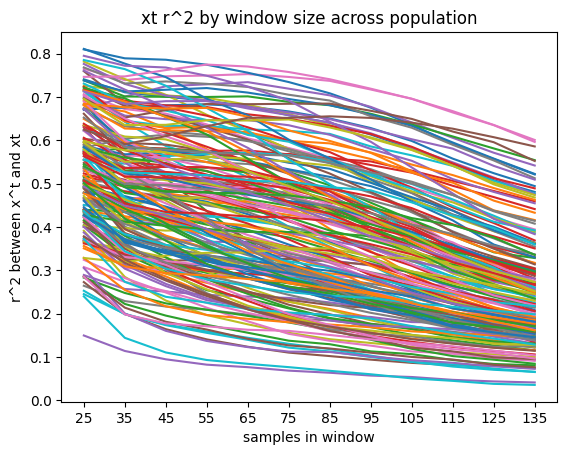

In [72]:
for i in noisearray:
    plt.plot(xticks, i)
    plt.xticks(xticks)
plt.ylabel("r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("xt r^2 by window size across population")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "allnoiseplots.svg"))

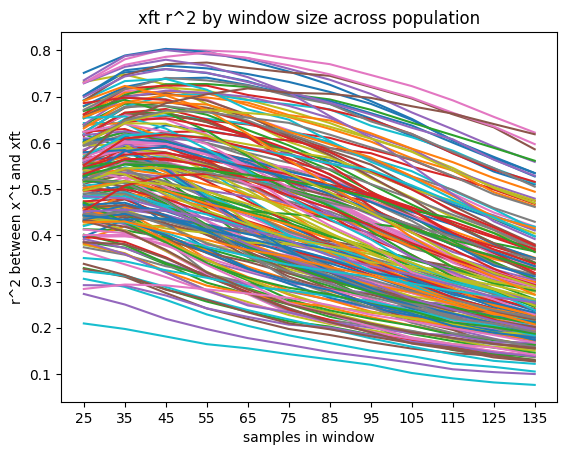

In [80]:
for i in cleanarray:
    plt.plot(xticks, i)
    plt.xticks(xticks)
plt.ylabel("r^2 between x^t and xft")
plt.xlabel("samples in window")
plt.title("xft r^2 by window size across population")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "allcleanplots.svg"))

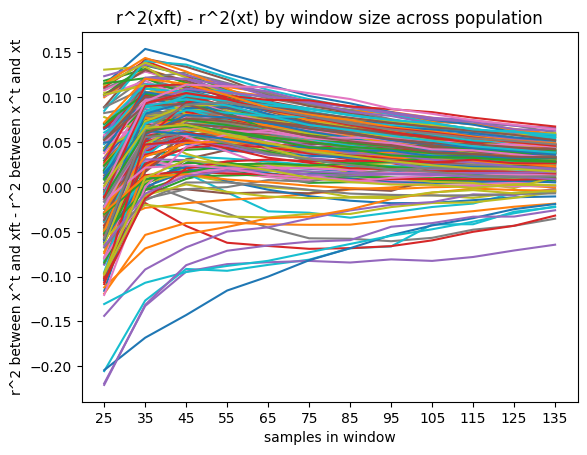

In [76]:
for i in difarray:
    plt.plot(xticks, i)
    plt.xticks(xticks)
plt.ylabel("r^2 between x^t and xft - r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("r^2(xft) - r^2(xt) by window size across population")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "alldifplots.svg"))

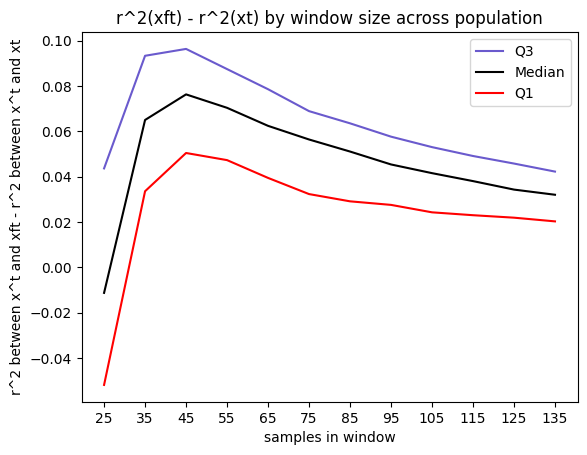

In [77]:
meandif = []
difup = []
difdown = []
for i in difarray.transpose():
    meandif.append(np.median(i))
    difup.append(np.quantile(i, 0.75))
    difdown.append(np.quantile(i, 0.25))

plt.plot(xticks, difup, color="slateblue")
plt.plot(xticks, meandif, color="black")
plt.plot(xticks, difdown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xft - r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("r^2(xft) - r^2(xt) by window size across population")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "difsummary.svg"))

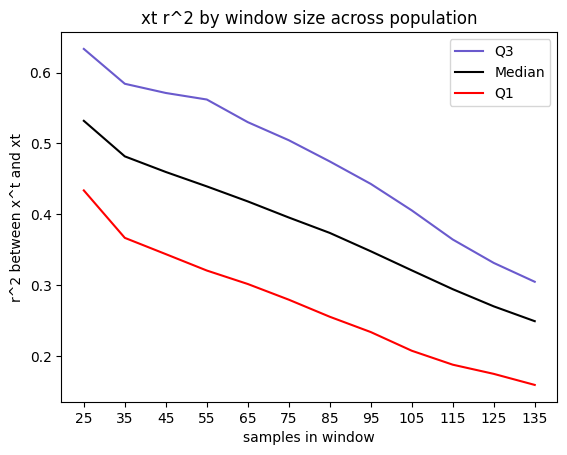

In [78]:
meannoise = []
noiseup = []
noisedown = []
for i in noisearray.transpose():
    meannoise.append(np.mean(i))
    noiseup.append(np.quantile(i, 0.75))
    noisedown.append(np.quantile(i, 0.25))

plt.plot(xticks, noiseup, color="slateblue")
plt.plot(xticks, meannoise, color="black")
plt.plot(xticks, noisedown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("xt r^2 by window size across population")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "noisesummary.svg"))


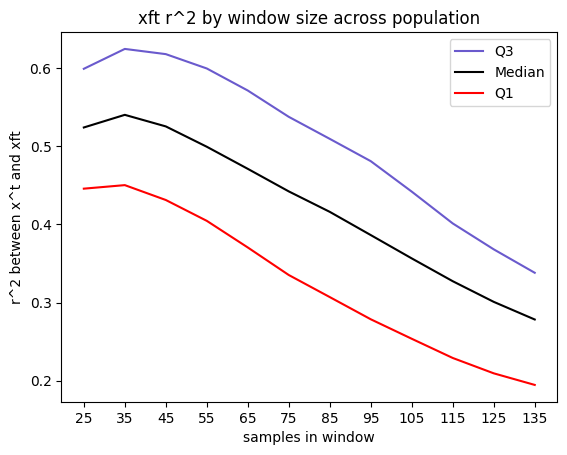

In [81]:
meanclean = []
cleanup = []
cleandown = []
for i in cleanarray.transpose():
    meanclean.append(np.mean(i))
    cleanup.append(np.quantile(i, 0.75))
    cleandown.append(np.quantile(i, 0.25))

plt.plot(xticks, cleanup, color="slateblue")
plt.plot(xticks, meanclean, color="black")
plt.plot(xticks, cleandown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xft")
plt.xlabel("samples in window")
plt.title("xft r^2 by window size across population")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "cleansummary.svg"))

In [111]:
cleanlist = find_dirs_by_extension(rootdir, "clean")
noisylist = find_dirs_by_extension(rootdir, "noisy")
print(cleanlist[0])
print(rootdir)

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa02_task-closed_eeg.vhdr\clean
C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory


In [107]:
print(xlarray[0])

['sub-FMpa01' 'sub-FMpa02' 'sub-FMpa03' 'sub-FMpa04' 'sub-FMpa05'
 'sub-FMpa06' 'sub-FMpa07' 'sub-FMpa08' 'sub-FMpa09' 'sub-FMpa10'
 'sub-FMpa11' 'sub-FMpa12' 'sub-FMpa13' 'sub-FMpa14' 'sub-FMpa15'
 'sub-FMpa16' 'sub-FMpa17' 'sub-FMpa19' 'sub-FMpa21' 'sub-FMpa22'
 'sub-FMhc01' 'sub-FMhc02' 'sub-FMhc03' 'sub-FMhc04' 'sub-FMhc05'
 'sub-FMhc06' 'sub-FMhc07' 'sub-FMhc08' 'sub-FMhc09' 'sub-FMhc10'
 'sub-FMhc11' 'sub-FMhc12' 'sub-FMhc13' 'sub-FMhc14' 'sub-FMhc15'
 'sub-FMhc16' 'sub-FMhc17' 'sub-FMhc18' 'sub-FMhc19' 'sub-FMhc20'
 'sub-FMhc21' 'sub-FMhc22' 'sub-CBPpa02' 'sub-CBPpa04' 'sub-CBPpa05'
 'sub-CBPpa07' 'sub-CBPpa08' 'sub-CBPpa09' 'sub-CBPpa10' 'sub-CBPpa11'
 'sub-CBPpa12' 'sub-CBPpa13' 'sub-CBPpa14' 'sub-CBPpa15' 'sub-CBPpa16'
 'sub-CBPpa18' 'sub-CBPpa19' 'sub-CBPpa21' 'sub-CBPpa24' 'sub-CBPpa25'
 'sub-CBPpa26' 'sub-CBPpa27' 'sub-CBPpa28' 'sub-CBPpa29' 'sub-CBPpa30'
 'sub-CBPpa31' 'sub-CBPpa32' 'sub-CBPpa33' 'sub-CBPpa34' 'sub-CBPpa35'
 'sub-CBPpa36' 'sub-CBPpa37' 'sub-CBPpa38' 'sub-

In [124]:
healthy = []
unhealthy = []
CWP = []
CBP = []
JP = []
NP = []

for i in range(numPatients):
    patientid = xlarray[0, i]
    try:
        np.isnan(xlarray[1, i])
        healthy.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
    except TypeError:
        unhealthy.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
        match patientid:
            case "CWP":
                CWP.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
            case "CBP":
                CBP.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
            case "PNP":
                NP.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
            case "NP":
                NP.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
            case "JP":
                JP.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
            case "PHN":
                NP.append(rootdir + '\\' + patientid + eyestate + '\\' + noisy)
    

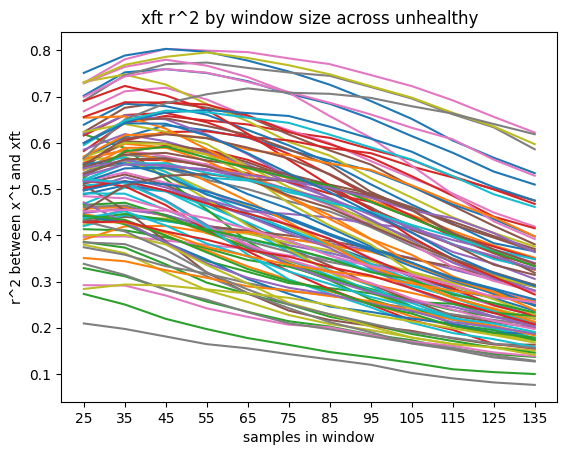

In [122]:
for i in range(numPatients):
    if noisylist[i] in unhealthy:
        plt.plot(xticks, cleanarray[i])
        plt.xticks(xticks)
plt.ylabel("r^2 between x^t and xft")
plt.xlabel("samples in window")
plt.title("xft r^2 by window size across unhealthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "unhealtycleanplots.svg"))



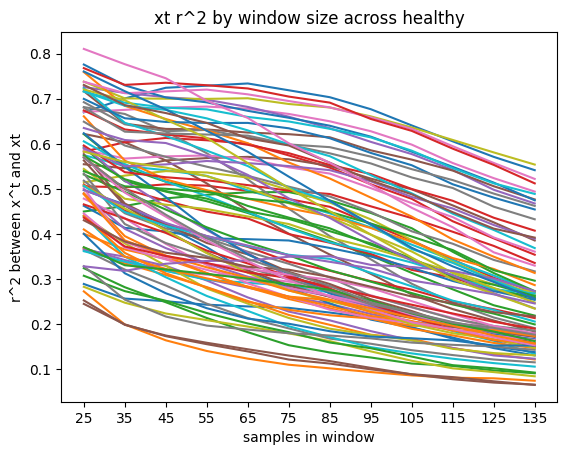

In [126]:
for i in range(numPatients):
    if noisylist[i] in healthy:
        plt.plot(xticks, noisearray[i])
        plt.xticks(xticks)
plt.ylabel("r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("xt r^2 by window size across healthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "healthynoiseplots.svg"))



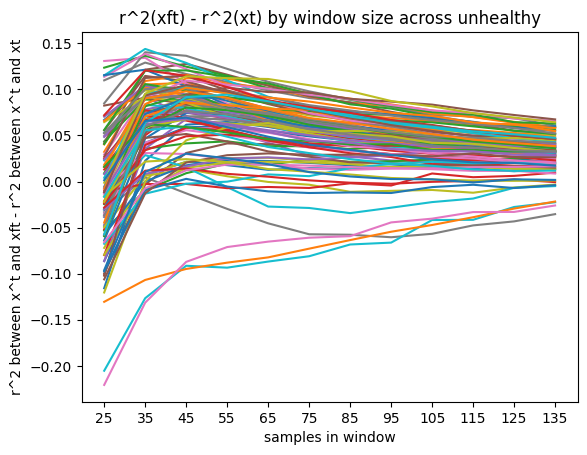

In [129]:
for i in range(numPatients):
    if noisylist[i] in unhealthy:
        plt.plot(xticks, difarray[i])
        plt.xticks(xticks)
plt.ylabel("r^2 between x^t and xft - r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("r^2(xft) - r^2(xt) by window size across unhealthy")

plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "unhealthydifplots.svg"))

In [168]:
difhealthy = []
difunhealthy = []
noisehealthy = []
noiseunhealthy = []
cleanhealthy = []
cleanunhealthy = []

for i in range(numPatients):
    if noisylist[i] in healthy:
        difhealthy.append(difarray[i])
difhealthy = np.asarray(difhealthy)
for i in range(numPatients):
    if noisylist[i] in unhealthy:
        difunhealthy.append(difarray[i])
difunhealthy = np.asarray(difunhealthy)
for i in range(numPatients):
    if noisylist[i] in unhealthy:
        noiseunhealthy.append(noisearray[i])
noiseunhealthy = np.asarray(noiseunhealthy)
for i in range(numPatients):
    if noisylist[i] in healthy:
        noisehealthy.append(noisearray[i])
noisehealthy = np.asarray(noisehealthy)
for i in range(numPatients):
    if noisylist[i] in unhealthy:
        cleanunhealthy.append(cleanarray[i])
cleanunhealthy = np.asarray(cleanunhealthy)
for i in range(numPatients):
    if noisylist[i] in healthy:
        cleanhealthy.append(cleanarray[i])
cleanhealthy = np.asarray(cleanhealthy)

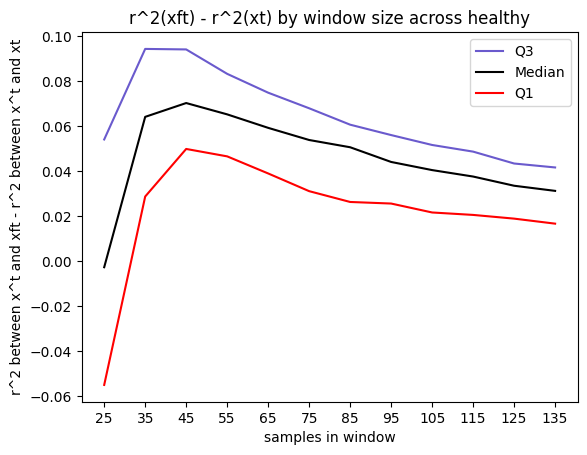

In [134]:
meandif = []
difup = []
difdown = []
for i in difhealthy.transpose():
    meandif.append(np.median(i))
    difup.append(np.quantile(i, 0.75))
    difdown.append(np.quantile(i, 0.25))

plt.plot(xticks, difup, color="slateblue")
plt.plot(xticks, meandif, color="black")
plt.plot(xticks, difdown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xft - r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("r^2(xft) - r^2(xt) by window size across healthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "healthydifsummary.svg"))

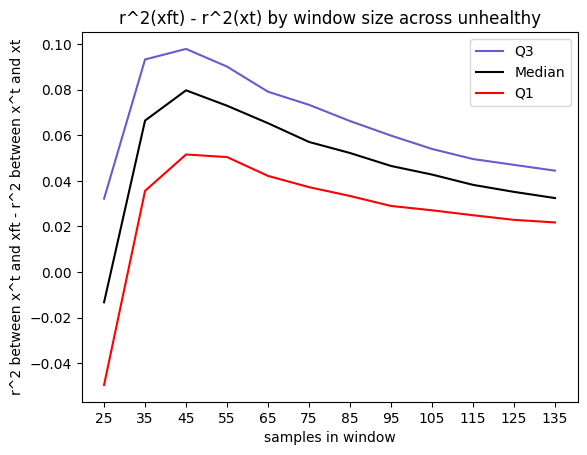

In [137]:
meandif = []
difup = []
difdown = []
for i in difunhealthy.transpose():
    meandif.append(np.median(i))
    difup.append(np.quantile(i, 0.75))
    difdown.append(np.quantile(i, 0.25))

plt.plot(xticks, difup, color="slateblue")
plt.plot(xticks, meandif, color="black")
plt.plot(xticks, difdown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xft - r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("r^2(xft) - r^2(xt) by window size across unhealthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "unhealthydifsummary.svg"))

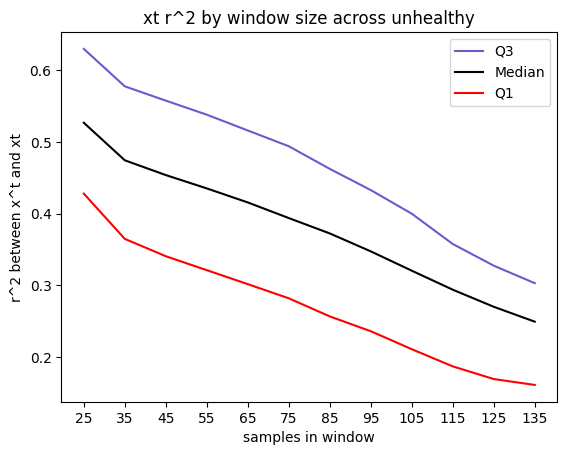

In [169]:
meannoise = []
noiseup = []
noisedown = []
for i in noiseunhealthy.transpose():
    meannoise.append(np.mean(i))
    noiseup.append(np.quantile(i, 0.75))
    noisedown.append(np.quantile(i, 0.25))

plt.plot(xticks, noiseup, color="slateblue")
plt.plot(xticks, meannoise, color="black")
plt.plot(xticks, noisedown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("xt r^2 by window size across unhealthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "unhealthynoisesummary.svg"))


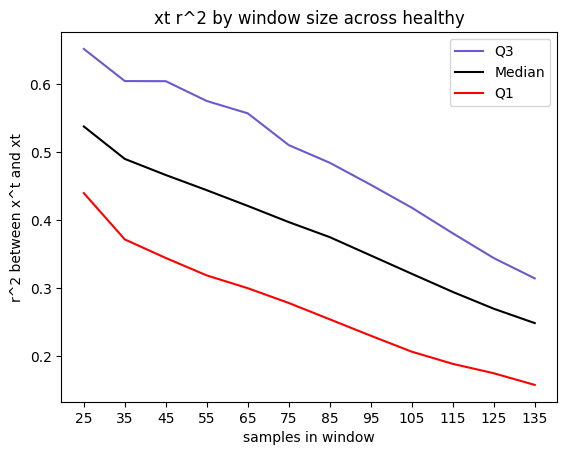

In [173]:
meannoise = []
noiseup = []
noisedown = []
for i in noisehealthy.transpose():
    meannoise.append(np.mean(i))
    noiseup.append(np.quantile(i, 0.75))
    noisedown.append(np.quantile(i, 0.25))

plt.plot(xticks, noiseup, color="slateblue")
plt.plot(xticks, meannoise, color="black")
plt.plot(xticks, noisedown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.title("xt r^2 by window size across healthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "healthynoisesummary.svg"))


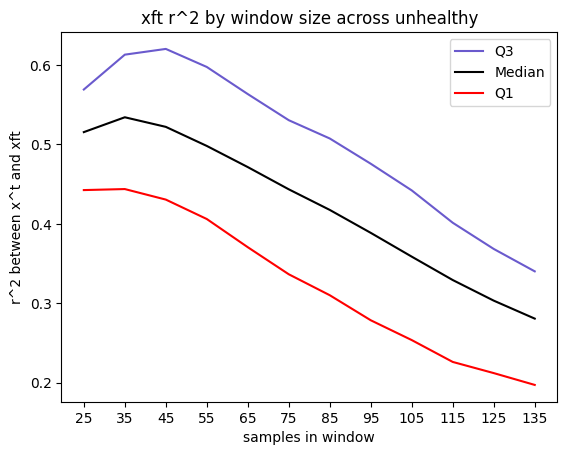

In [171]:
meanclean = []
cleanup = []
cleandown = []
for i in cleanunhealthy.transpose():
    meanclean.append(np.mean(i))
    cleanup.append(np.quantile(i, 0.75))
    cleandown.append(np.quantile(i, 0.25))

plt.plot(xticks, cleanup, color="slateblue")
plt.plot(xticks, meanclean, color="black")
plt.plot(xticks, cleandown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xft")
plt.xlabel("samples in window")
plt.title("xft r^2 by window size across unhealthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "unhealthycleansummary.svg"))

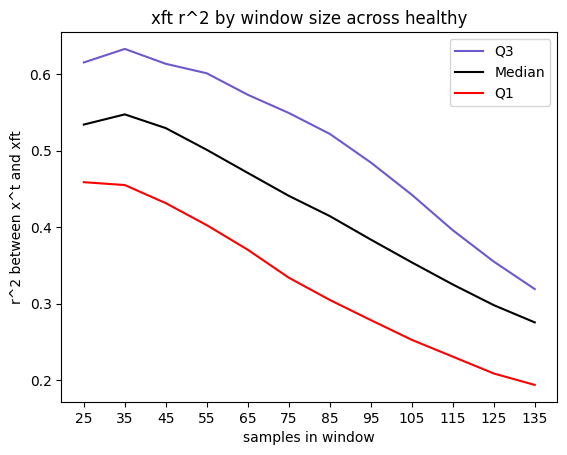

In [172]:
meanclean = []
cleanup = []
cleandown = []
for i in cleanhealthy.transpose():
    meanclean.append(np.mean(i))
    cleanup.append(np.quantile(i, 0.75))
    cleandown.append(np.quantile(i, 0.25))

plt.plot(xticks, cleanup, color="slateblue")
plt.plot(xticks, meanclean, color="black")
plt.plot(xticks, cleandown, color="red")
plt.xticks(xticks)
plt.legend(("Q3", "Median", "Q1"))
plt.ylabel("r^2 between x^t and xft")
plt.xlabel("samples in window")
plt.title("xft r^2 by window size across healthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "healthycleansummary.svg"))

In [177]:
noiseptest = []
for n in range(12):
    t, p = stats.ttest_ind_from_stats(np.mean(noiseunhealthy[:,n]), np.std(noiseunhealthy[:,n]), 101, np.mean(noisehealthy[:,n]), np.std(noisehealthy[:,n]), 88)
    noiseptest.append(p)
    print(p)

0.5728099925801913
0.45272051949329417
0.5621312458867747
0.6902668595617998
0.809707357494146
0.8782976220186813
0.9021512232009234
0.9688201452013696
0.9684893047610208
0.9747107672897319
0.9895627957050508
0.9717220408723133


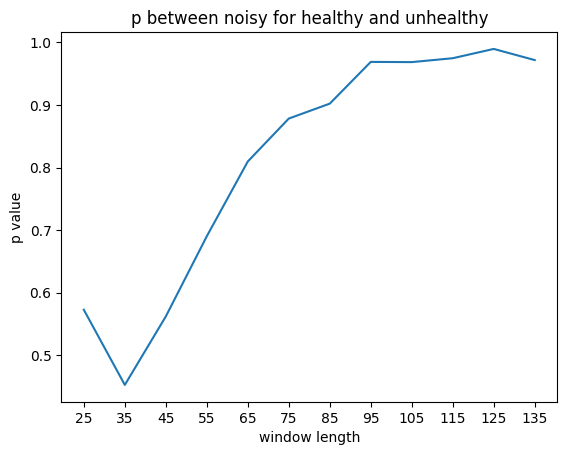

In [178]:
plt.plot(xticks, noiseptest)
plt.xticks(xticks)
plt.ylabel("p value")
plt.xlabel("window length")
plt.title("p between noisy for healthy and unhealthy")
plt.savefig(os.path.join(mainfolder + "Archive\\NoiseR^2", "pxt.svg"))

In [97]:
print(rootdir + '\\' + patientids[0] + eyestate)

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-FMpa01_task-closed_eeg.vhdr


# A matrix tests

In [44]:
data = np.load(datalist[0])  # Expected shape: (n_channels, n_samples)

# If data is 1D, convert to 2D (1 channel)
if data.ndim == 1:
    data = data[np.newaxis, :]

n_channels, n_samples = data.shape
sfreq = 100  # Sampling frequency in Hz — update as needed

# Create MNE info structure
ch_names = [f"Ch{i+1}" for i in range(n_channels)]
ch_types = ['eeg'] * n_channels  # or use 'ecg', 'emg', etc.
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create RawArray
raw = mne.io.RawArray(data, info)

# Save to EDF
raw.export(mainfolder + "output.edf", fmt='edf')  # fmt='edf' or 'edf+'

print("EDF file saved as output.edf")

Creating RawArray with float64 data, n_channels=62, n_times=334996
    Range : 0 ... 334995 =      0.000 ...  3349.950 secs
Ready.


C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_24828\637484413.py:19: RuntimeWarning: EDF format requires equal-length data blocks, so 0.04 seconds of edge values were appended to all channels when writing the final block.
  raw.export(mainfolder + "output.edf", fmt='edf')  # fmt='edf' or 'edf+'


EDF file saved as output.edf


In [87]:
print(powers[0])

[8.58652548e-10 3.20907947e-10 2.09582958e-10 3.48721400e-10
 1.02358438e-09 7.36488354e-10 4.43647800e-09 1.49706524e-09
 6.80142891e-10 5.43377380e-09 1.76201982e-10 1.21202422e-09
 5.67211587e-10 2.75989823e-09 5.61015057e-11 7.47181779e-11
 1.39155833e-10 2.52972713e-10 6.92906940e-10]


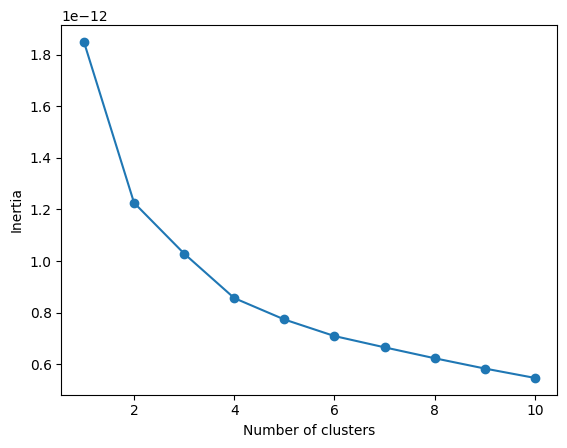

In [105]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(powers)
    inertias.append(kmeans.inertia_)
fig, ax = plt.subplots()

plt.plot(range(1,11), inertias, marker='o')
# plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "elbow.svg"))


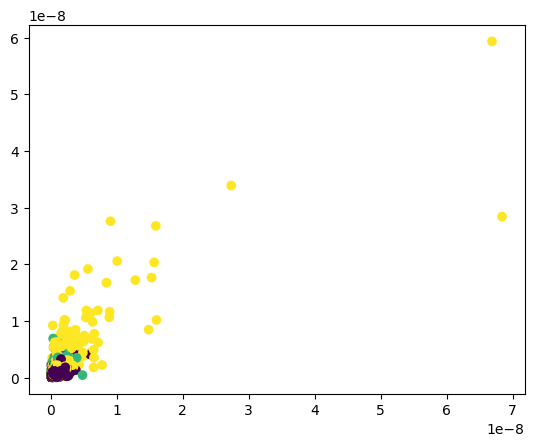

In [104]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(powers)

plt.scatter(powers[:,3], powers[:,2], c=kmeans.labels_)
plt.show() 

10466


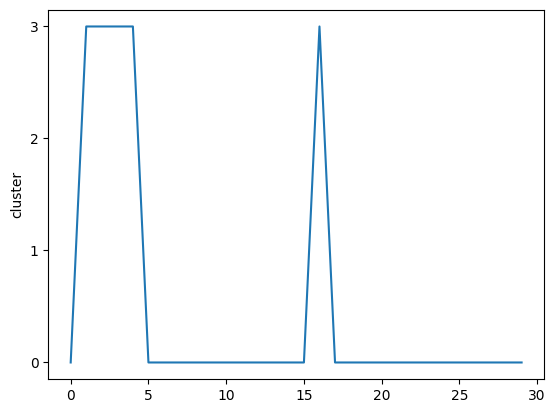

In [95]:
print(len(kmeans.labels_))
plt.plot(kmeans.labels_[0:30])
plt.yticks((0,1,2,3))
plt.ylabel("cluster")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "clusterchange.svg"))

In [96]:
changes=np.zeros((4,4), dtype=int)
points=np.zeros((4,), dtype=int)
for i in range(len(kmeans.labels_)-1):
    x=kmeans.labels_[i]
    y=kmeans.labels_[i+1]
    changes[x,y]+=1
    points[x]+=1
points[y]+=1

print(changes)
print(points)

[[4525  246   16 1408]
 [ 265  361   69  391]
 [  19   74   57   40]
 [1386  405   48 1155]]
[6196 1086  190 2994]


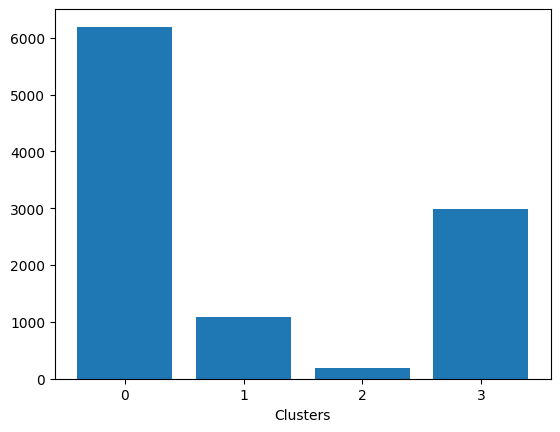

In [97]:
plt.bar((0,1,2,3),points)
plt.xlabel("Clusters")
plt.xticks((0,1,2,3))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "clusterbar.svg"))

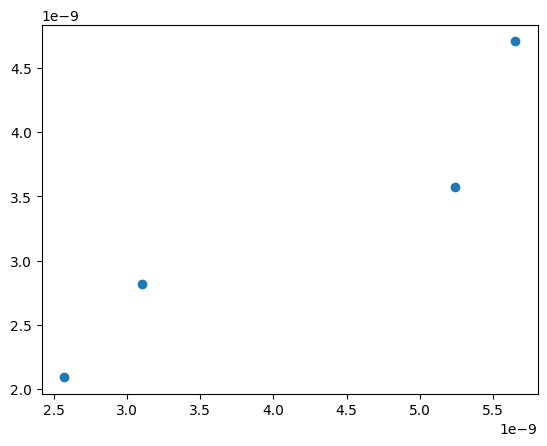

In [59]:
plt.scatter(kmeans.cluster_centers_[:,5],kmeans.cluster_centers_[:,4])

In [ ]:
plt.topomap()

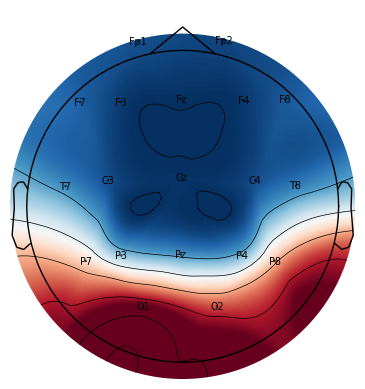

In [100]:
fig, ax = plt.subplots()

n=2

mne.viz.plot_topomap(kmeans.cluster_centers_[n], xypos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "cluster" + str(n) + ".svg"))


In [53]:
image_folder = mainfolder + "Archive\\Old_Graphs\\topomapvideo"
video_name = mainfolder + "Archive\\Old_Graphs\\video.mp4"

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))



cv2.destroyAllWindows()
video.release()

In [43]:
video.release()

In [223]:
data = np.zeros((chl,300000), dtype=float)
for i in range(chl):
    a = np.random.default_rng().random()
    b = np.random.default_rng().random()
    for x in range(data.shape[1]):
        data[i,x] = a * np.sin((x+b))

In [107]:
print(j)
print(filereorder)

10
[7, 8, 9, 10, 1, 2, 3, 4, 5, 6]


In [106]:
print(Amats.shape[0]*window_length_samples)
print(data.shape)
print(reconstruction.shape)

209930
(62, 299996)
(209931, 62)


In [149]:
xticks=[]

for j in range(5, 21):
    xticks.append(j*5)
    
plt.plot(xticks, noisymeanr)
plt.ylabel("r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.xticks(xticks)
plt.title("patient " + str(i))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\noise_experiment", "noisy" + str(i) + ".svg"))
plt.cla()
plt.clf()
plt.plot(xticks, cleanmeanr)
plt.ylabel("r^2 between x^t and xft")
plt.xlabel("samples in window")
plt.xticks(xticks)
plt.title("patient " + str(i))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\noise_experiment", "clean" + str(i) + ".svg"))
plt.cla()
plt.clf()
plt.plot(xticks, difmeanr)
plt.ylabel("r^2 between x^t and xft - r^2 between x^t and xt")
plt.xlabel("samples in window")
plt.xticks(xticks)
plt.title("patient " + str(i))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\noise_experiment", "dif" + str(i) + ".svg"))
plt.cla()
plt.clf()

<Figure size 640x480 with 0 Axes>

'109_samples'

In [101]:
for j in range(len(noisyAmats)):
    print(noisyAmats[j])

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa02_task-closed_eeg.vhdr\noisy\100_samples\sub-CBPpa02_task-closed_eeg.vhdrdiag_matrix_values.npy
C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa02_task-closed_eeg.vhdr\noisy\105_samples\sub-CBPpa02_task-closed_eeg.vhdrdiag_matrix_values.npy
C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa02_task-closed_eeg.vhdr\noisy\110_samples\sub-CBPpa02_task-closed_eeg.vhdrdiag_matrix_values.npy
C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa02_task-closed_eeg.vhdr\noisy\115_samples\sub-CBPpa02_task-closed_eeg.vhdrdiag_matrix_values.npy
C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa02_task-closed_eeg.vhdr\noisy\120_samples\sub-CBPpa02_task-closed_eeg.vhdrdiag_matrix_values.npy
C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa02_task-closed_eeg.vhdr\noisy\125_s

In [45]:
noiseless = data

In [78]:
# noisydata = np.zeros(noiseless.shape)
# for i in range(noiseless.shape[0]):
    # noisydata[i] = noiseless[i] + np.random.normal(0, np.std(noiseless)/10, noiseless.shape[1])

In [142]:
noisydata = data

In [193]:
print(data.shape)

(62, 299996)


In [ ]:
m=0
options = {
    'node_color': 'blue',
    'node_size': 200,
    'font_size': 6,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

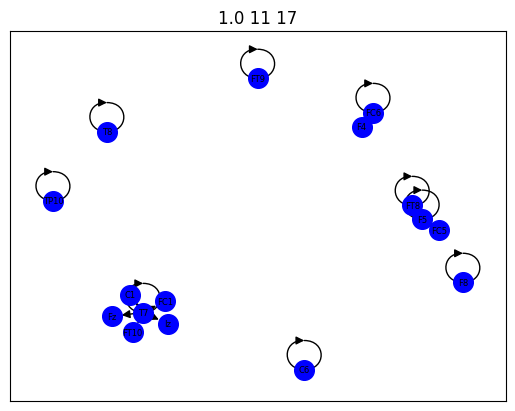

In [64]:
while m < 1.01:
    plt.clf()
    plt.cla()
    A_Connections = nx.Graph()
    Connected_Nodes = []
        
    for i in range(chl):
        for j in range(chl):
            # if ahatswdiag[m, i, j] > 0.3:
            # if np.mean(ahatswdiag[1:, i, j], axis = 0) > 0.1:
            if np.max(ahatswdiag[1:, i, j], axis = 0) > m:
        
                A_Connections.add_edges_from([(keep_channels[i], keep_channels[j])])
                if i != j:
                    if keep_channels[i] not in Connected_Nodes:
                        Connected_Nodes.append(keep_channels[i])
                    if keep_channels[j] not in Connected_Nodes:
                        Connected_Nodes.append(keep_channels[j])
                        
    nx.shell_layout(A_Connections, scale = 1)
    plt.figure(1,figsize=(10, 10))
    nx.draw_networkx(A_Connections, arrows=True, **options)

    plt.title(str(np.round(m, 2)) + ' ' + str(len(Connected_Nodes)) + " " + str(len(A_Connections.edges)))
    plt.draw()
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "A-Mat_Connect_Means", str(np.round(m, 2)) + '_' + str(len(Connected_Nodes)) + "_" + str(len(A_Connections.edges)) + ".png"))
    m+=0.01




In [66]:
Connectivity = []

while m <= 1:
    A_Connections = nx.Graph()
    Connected_Nodes = []
    
    for i in range(chl):
        for j in range(chl):
            # if ahatswdiag[m, i, j] > 0.3:
            # if np.mean(ahatswdiag[1:, i, j], axis = 0) > 0.1:
            if np.max(ahatswdiag[1:, i, j], axis = 0) > m:
    
                A_Connections.add_edges_from([(keep_channels[i], keep_channels[j])])
                if i != j:
                    if keep_channels[i] not in Connected_Nodes:
                        Connected_Nodes.append(keep_channels[i])
                    if keep_channels[j] not in Connected_Nodes:
                        Connected_Nodes.append(keep_channels[j])
    # nx.shell_layout(A_Connections, scale = 1)
    # plt.figure(1,figsize=(10, 10))
    # nx.draw_networkx(A_Connections, arrows=True, **options)
    # plt.title(str(m) + ' ' + str(len(Connected_Nodes)))
    m+=0.01
    # plt.draw()
    Connectivity.append(len(Connected_Nodes))

plt.plot(np.arange(0, 1, 0.01), Connectivity)

In [238]:
print(powers.shape)

(2399, 62)


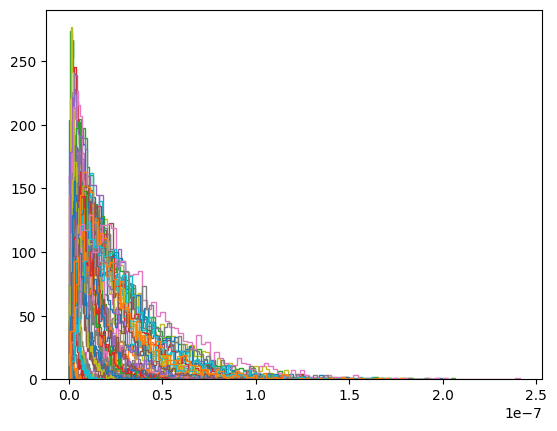

In [240]:
for i in powers.transpose():
    plt.hist(i,bins=100, histtype='step')

plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "histofenergy.svg"))


In [113]:
print(data.shape)

(62, 299996)


In [56]:
dependents = []
dependentskip = []
for i in range(data.shape[0]):
    if i not in dependentskip:
        for j in range(i, data.shape[0]):
            if j not in dependentskip:
                k = stats.linregress(data[i], data[j])[2]
                if 0.95 < k < 1:
                    if keep_channels[i] not in dependents:
                        dependents.append(keep_channels[i])
                    if keep_channels[j] not in dependents:
                        dependentskip.append(j)
                        
                    print(keep_channels[i] + ' ' + keep_channels[j] + ' ' + str(k))

print(len(dependentskip))
print(len(dependents))
# print(dependents)

Fp1 AF3 0.9738387219815091
Fp1 Fpz 0.9777301415591396
Fp2 AF4 0.9608835881021949
P3 CP1 0.9512978931035091
P3 P1 0.9744766534635014
P3 CP3 0.9569973016639655
P3 PO3 0.9761076374705534
P3 P5 0.9604747800940283
P4 P2 0.9614924570378296
P4 PO4 0.9606306882877634
P4 P6 0.9506260017594694
O1 Oz 0.9542699720168262
O1 PO7 0.974207343560142
O2 PO8 0.9658670489704484
F7 FC5 0.9589056293225114
F7 F5 0.9589283372200642
F7 FT7 0.9712814658581694
F8 FT8 0.9541769266414595
P7 PO9 0.9762132872635028
P8 TP8 0.9555745590108154
P8 PO10 0.9675686320939261
Pz CPz 0.9694377992357354
Pz POz 0.9713961168867502
23
11


In [61]:
dependents = []
dependentskip = []
for i in range(data.shape[0]):
    if i not in dependentskip:
        for j in range(i, data.shape[0]):
            if j not in dependentskip:
                k = stats.linregress(data[i], data[j])[2]
                if 0.90 < k < 1:
                    if keep_channels[i] not in dependents:
                        dependents.append(keep_channels[i])
                    if keep_channels[j] not in dependents:
                        dependentskip.append(j)
                        
                    print(keep_channels[i] + ' ' + keep_channels[j] + ' ' + str(k) + ' ' + str(np.mean(data[i])) + ' ' + str(np.mean(data[j])))

print(len(dependentskip))
print(len(dependents))
# print(dependents)

Fp1 AF3 0.9651869756410487 -1.9035123718830118e-08 -1.2590344625367389e-08
Fp1 Fpz 0.9248864819918023 -1.9035123718830118e-08 -2.375114007765279e-08
F3 F7 0.9027204204710209 -4.779321174469936e-09 -3.2756862983612406e-09
F3 FC5 0.9042752395681581 -4.779321174469936e-09 -3.3750040313331467e-09
F3 FC3 0.9008344447374668 -4.779321174469936e-09 5.30234071342822e-10
F3 F5 0.9421982767542237 -4.779321174469936e-09 -5.530409549627876e-09
C3 CP5 0.9157300334248561 1.0103523280827787e-09 -5.010950763771325e-09
C3 CP3 0.9163623995852971 1.0103523280827787e-09 3.0130069056285794e-09
C3 C5 0.9299341398513412 1.0103523280827787e-09 5.618912611050798e-10
C4 CP6 0.9061299290391241 3.352639621704999e-09 5.668300628615317e-09
C4 C6 0.955852135317476 3.352639621704999e-09 7.407383048774342e-09
P3 CP1 0.9159602831212078 5.357280334874456e-10 2.6791664988369825e-09
P3 P1 0.9612669059193537 5.357280334874456e-10 3.3142299864500666e-10
P3 PO3 0.9462562428021045 5.357280334874456e-10 -2.070371191286055e-09
P

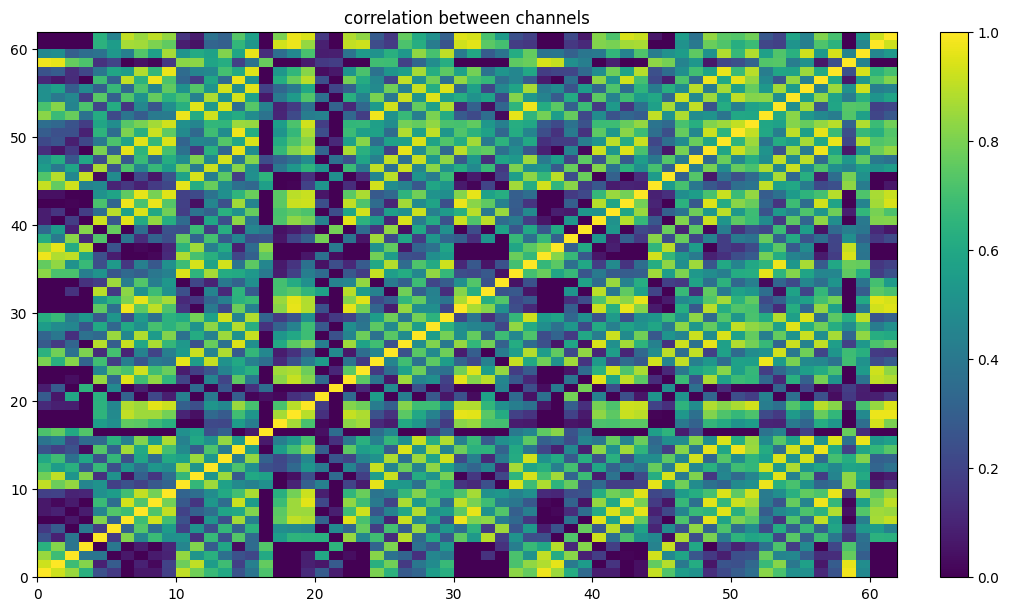

In [37]:
#dont use without messing with function

kmat = []
for i in range(data.shape[0]):
    krow = []
    for j in range(data.shape[0]):
        k = stats.linregress(data[i], data[j])[2]
        krow.append(k)
    kmat.append(krow)

kmat = np.asarray(kmat)
plot_examples([cmap], kmat)
# print(dependents)

In [95]:
print(data.shape)

(62, 299996)


In [33]:
print(sink_indices.shape)

(2399, 62)


In [34]:
print(215780/125)
print(215825/125)

1726.24
1726.6


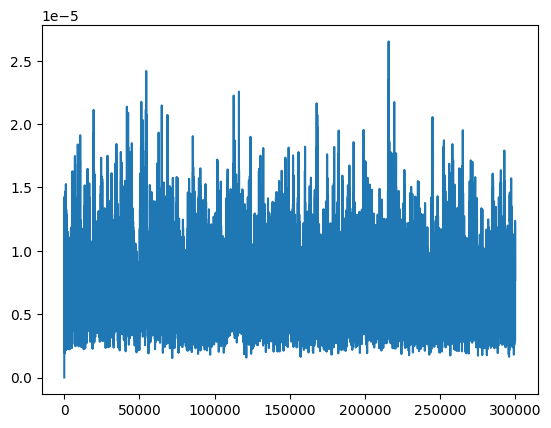

In [35]:
magnitude = []

for i in data.transpose():
    magnitude.append(np.std(i))

# plt.plot(magnitude[215780:215825])
plt.plot(magnitude)
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "magnitude.png"))

In [81]:
print(len(magnitude))
print(magnitude[len(magnitude)-1])

299996
7.702292765434064e-06


In [62]:
maximums = []

for i in range(1, len(magnitude)):
    if magnitude[i] > magnitude[i-1] and magnitude[i] > magnitude[i+1] and int(np.trunc(i/125)) < sink_indices.shape[0]:
        maximums.append(i)

In [57]:
print(sink_indices.shape)

(2399, 62)


In [88]:
maxdata = []
maxsink = []

for i in maximums:
    maxdata.append(data.transpose()[i])
    maxsink.append(sink_indices[int(np.trunc(i/125))])


maxdata = np.asarray(maxdata)
maxsink = np.asarray(maxsink)


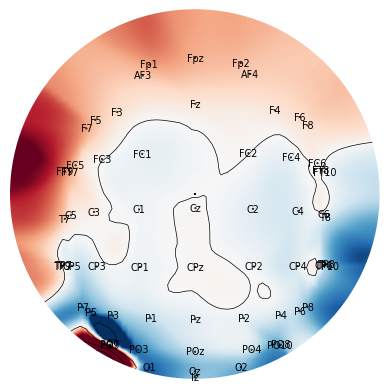

In [91]:
sinktopomap()

In [31]:
print(np.max(magnitude))

2.6519896149247377e-05


In [70]:
print(powers.shape)

(2399, 62)


In [68]:
n = 0
for i in sink_indices.transpose():
    print(str(n)+' '+keep_channels[n]+' '+str(np.mean(i)))
    n+=1

0 Fp1 0.6173540426240689
1 Fp2 0.47183686463321617
2 F3 0.28791643360883484
3 F4 0.2674100353837526
4 C3 0.33209991787583043
5 C4 0.343721100696505
6 P3 0.42083506395283743
7 P4 0.37947093397232695
8 O1 0.5450350357513913
9 O2 0.48878026445752853
10 F7 0.7244523038031825
11 F8 0.5016027224464372
12 T7 0.9464237904228604
13 T8 0.9618528652450321
14 P7 0.5997548190010864
15 P8 0.5552942186065957
16 Fz 0.1587929069505781
17 Cz 0.22527561314333547
18 Pz 0.34151519860365004
19 Oz 0.48953042593644425
20 FC1 0.19319444867053326
21 FC2 0.18544049694585474
22 CP1 0.30251308446004027
23 CP2 0.29441951934268057
24 FC5 0.5679473047463666
25 FC6 0.49231529427625076
26 CP5 0.5485754208400052
27 CP6 0.4027329272144393
28 TP9 0.8638220063474075
29 TP10 0.8429166513400231
30 P1 0.41433224559671933
31 P2 0.42868251027955395
32 C1 0.2186162692215392
33 C2 0.21648504978016825
34 FT9 0.8461202732972747
35 FT10 0.5202180637586619
36 AF3 0.49041718196667905
37 AF4 0.32682567573286225
38 FC3 0.290709564193616

In [73]:
n = 0
for i in source_indices.transpose():
    print(str(n)+' '+keep_channels[n]+' '+str(np.mean(i))+" | "+str(np.mean(powers.transpose()[n])))
    n+=1

0 Fp1 0.32254426524286856 | 6.003977642661063e-09
1 Fp2 0.48803155947461563 | 6.320633609418176e-09
2 F3 0.6707343209523073 | 2.9324918576495424e-09
3 F4 0.6895193136462267 | 3.119921759377989e-09
4 C3 0.6336903592783539 | 5.897903145640153e-09
5 C4 0.6249601916737113 | 6.733719888671927e-09
6 P3 0.5370652700493428 | 1.975958547685659e-08
7 P4 0.5915403342709845 | 1.7526935782346736e-08
8 O1 0.418319391321566 | 3.293837055751908e-08
9 O2 0.4751004018001449 | 2.9419954811749482e-08
10 F7 0.2583647584766998 | 8.426390721493523e-09
11 F8 0.4437617800715017 | 9.095858949876823e-09
12 T7 0.053748188884706144 | 1.2089597199331013e-08
13 T8 0.04434654449307688 | 1.4428902907295035e-08
14 P7 0.3511259549261103 | 2.584932179375292e-08
15 P8 0.37561177685036107 | 2.6847650036864043e-08
16 Fz 0.7911697566602828 | 8.142103878431679e-10
17 Cz 0.7052384577243591 | 1.8845889972605256e-09
18 Pz 0.6227110170183231 | 1.634721184109041e-08
19 Oz 0.46828077059988477 | 2.5551164697371924e-08
20 FC1 0.71728

In [64]:
print(a_matrices.shape)

(2399, 62, 62)


In [65]:
norm = colors.Normalize()


# normsvd = norm(SVDS.transpose()[0:50])
normsvd = norm(SVDS.transpose())
plot_examples([cmap], normsvd)
# plt.savefig(os.path.join(mainfolder + "Data\\Old_Graphs", "colors.png"))


<Figure size 1000x600 with 0 Axes>

In [66]:
print(viridis)



In [67]:
print(nsamples)
print(window_length_samples)
print(nsamples/window_length_samples)
print(evals.shape)

299996
125
2399.968
(2399, 62)


In [134]:
data = noisydata

In [100]:
print(noisydatalist)

['C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\\109_samples\\sub-CBPpa38_task-closed_eeg.vhdrdata.npy', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\\119_samples\\sub-CBPpa38_task-closed_eeg.vhdrdata.npy', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\\129_samples\\sub-CBPpa38_task-closed_eeg.vhdrdata.npy', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\\139_samples\\sub-CBPpa38_task-closed_eeg.vhdrdata.npy', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\\150_samples\\sub-CBPpa38_task-closed_eeg.vhdrdata.npy', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\

In [99]:
print(noisydatalist[0])

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\noisedirectory\sub-CBPpa38_task-closed_eeg.vhdr\noisy\109_samples\sub-CBPpa38_task-closed_eeg.vhdrdata.npy


In [219]:
print(np.sum(ahatswdiag[200].flatten())/19)

0.32090193852757404


In [39]:

# data=np.load('C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\\99_samples\\sub-CBPpa38_task-closed_eeg.vhdrdata.npy')
# clean=np.load('C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\clean\\99_samples\\sub-CBPpa38_task-closed_eeg.vhdrdata.npy')
# window_length_samples=45
# ahatswdiag=np.load('C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\noisedirectory\\sub-CBPpa38_task-closed_eeg.vhdr\\noisy\\99_samples\\sub-CBPpa38_task-closed_eeg.vhdrdiag_matrix_values.npy')

# adjustedmatrix = ahatswdiag*(1.233213508)
aproxeeg = []
aproxdata = data[:,0]


##this is horrible and slow but just testing

aproxeeg.append(aproxdata)

i = 0
while i < ahatswdiag.shape[0]:
# while i < 200:
    # aproxpower = np.matmul(adjustedmatrix[i], aproxpower)
    l = 1 
    while l <= window_length_samples:
        aproxdata = ahatswdiag[i] @ aproxdata
        aproxeeg.append(aproxdata)
        l += 1
    i += 1
    aproxdata = data[:,(i*window_length_samples)]

aproxeeg = np.asarray(aproxeeg)


# print(aproxeeg[1,0])
# print(powers[1,0])

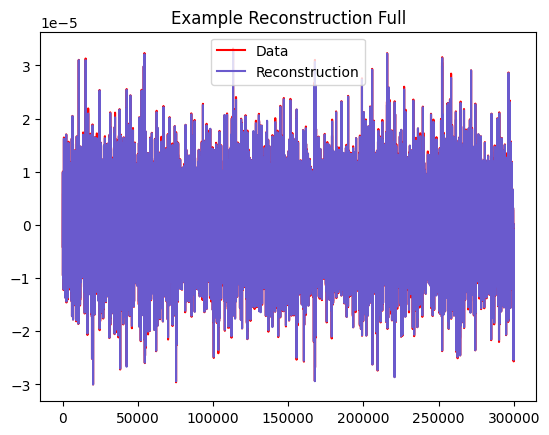

In [49]:
start = 0
end = aproxeeg.shape[0]-1

start = window_length_samples+1
# end = 95000

# start = aproxeeg.shape[0]-3000

# end = 90
# end = 45
# end = 500
# end = 85000

view = 0
# view2 = 16
# plt.ylim(-1e-4, 1e-4)

plt.plot(range(end+1)[start:end], data.transpose()[start:end,view], color = "red")
# plt.plot(range(end+1)[start:end], clean.transpose()[start:end,view], color = "lawngreen")
plt.plot(range(end+1)[start:end], aproxeeg[start:end,view], color = "slateblue")
# plt.plot(range(end+1)[start:end], data.transpose()[start:end,view], color = "red")
# plt.plot(range(end+1)[start:end], aproxeeg[start:end,view])
# plt.plot(range(end+1)[start:end], aproxeeg[start:end,view+1])
# # plt.plot(range(end+1)[start:end], data.transpose()[start:end,view])
plt.title("Example Reconstruction Full")
# plt.legend(("No Low Pass", "Full ICA", "Reconstruction"))
plt.legend(("Data",))
plt.legend(("Data","Reconstruction"))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "reconstruct_Full.svg"))
# plt.title("250 Samples 62 Channels (FM < AM)")
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\PresentationDrawings", "smoothing25062.svg"))



In [66]:
print(np.mean(noisydata))

-1.141322320129819e-09


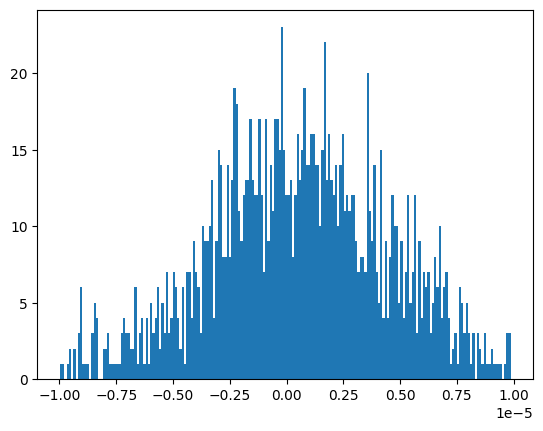

In [43]:
data = noisydata
gausdif=[]
view=0
for i in range(500, end+1):
    # gausdif.append(data.transpose()[i,view])
    # gausdif.append(aproxeeg[i,view]-data.transpose()[i,view])
    if np.abs(aproxeeg[i,view]-data.transpose()[i,view]) < 1e-5:
        gausdif.append(aproxeeg[i,view]-data.transpose()[i,view])
        
mean,std=stats.norm.fit(gausdif)
plt.hist(gausdif, bins = 200)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(gausdif))
y = stats.norm.pdf(x, mean, std)
# plt.plot(x, y)
plt.show()

# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "low_R^2_Gaussian.png"))
data = noiseless

In [109]:
means125noisy = []
means125raw = []

In [135]:
# means250noisy = []
# print(len(means250noisy))
# means250raw = []

In [128]:
# means500noisy = []
# means500raw = []

In [151]:
view = 0
while view < chl:

    i = window_length_samples
    s1cor = []
    s2cor = []
    while i < aproxeeg.shape[0]:
        s1 = stats.linregress(aproxeeg[i-window_length_samples:i,view], noisydata.transpose()[i-window_length_samples:i,view])[2]
        s2 = stats.linregress(aproxeeg[i-window_length_samples:i,view], noiseless.transpose()[i-window_length_samples:i,view])[2]
        # s = stats.linregress(noisydata.transpose()[i-window_length_samples:i,view], noiseless.transpose()[i-window_length_samples:i,view])[2]
        s1cor.append(s1**2)
        s2cor.append(s2**2)

        i+=window_length_samples

    means125noisy.append(np.mean(s1cor))
    means125raw.append(np.mean(s2cor))

    view+=1
    
# plt.plot(range(len(pcor)), pcor)
# # plt.title("r^2 between reconstruction and noisy per window")
# plt.title("r^2 between reconstruction and raw per window")
# # plt.title("r^2 between noisy and raw per window")

# plt.hlines([np.mean(pcor)], 0, aproxeeg.shape[0]/window_length_samples, color = "black")
# plt.yticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, np.round(np.mean(pcor), 2)])
# plt.hlines([np.median(pcor)], 0, aproxeeg.shape[0]/window_length_samples, color = "black")
# plt.yticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, np.round(np.median(pcor), 2)])

# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "r2reconstructionandnoisy.png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "r2reconstructionandraw.png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "r2noisyandraw.png"))

In [179]:
means125dif = []
for i, j in zip(means125raw, means125noisy):
    means125dif.append(i-j)

means250dif = []
for i, j in zip(means250raw, means250noisy):
    means250dif.append(i-j)

means500dif = []
for i, j in zip(means500raw, means500noisy):
    means500dif.append(i-j)

In [184]:
print(len(papos))

124


Text(0.5, 1.0, 'Mean r^2 values of reconstruction and data with no low-pass filter')

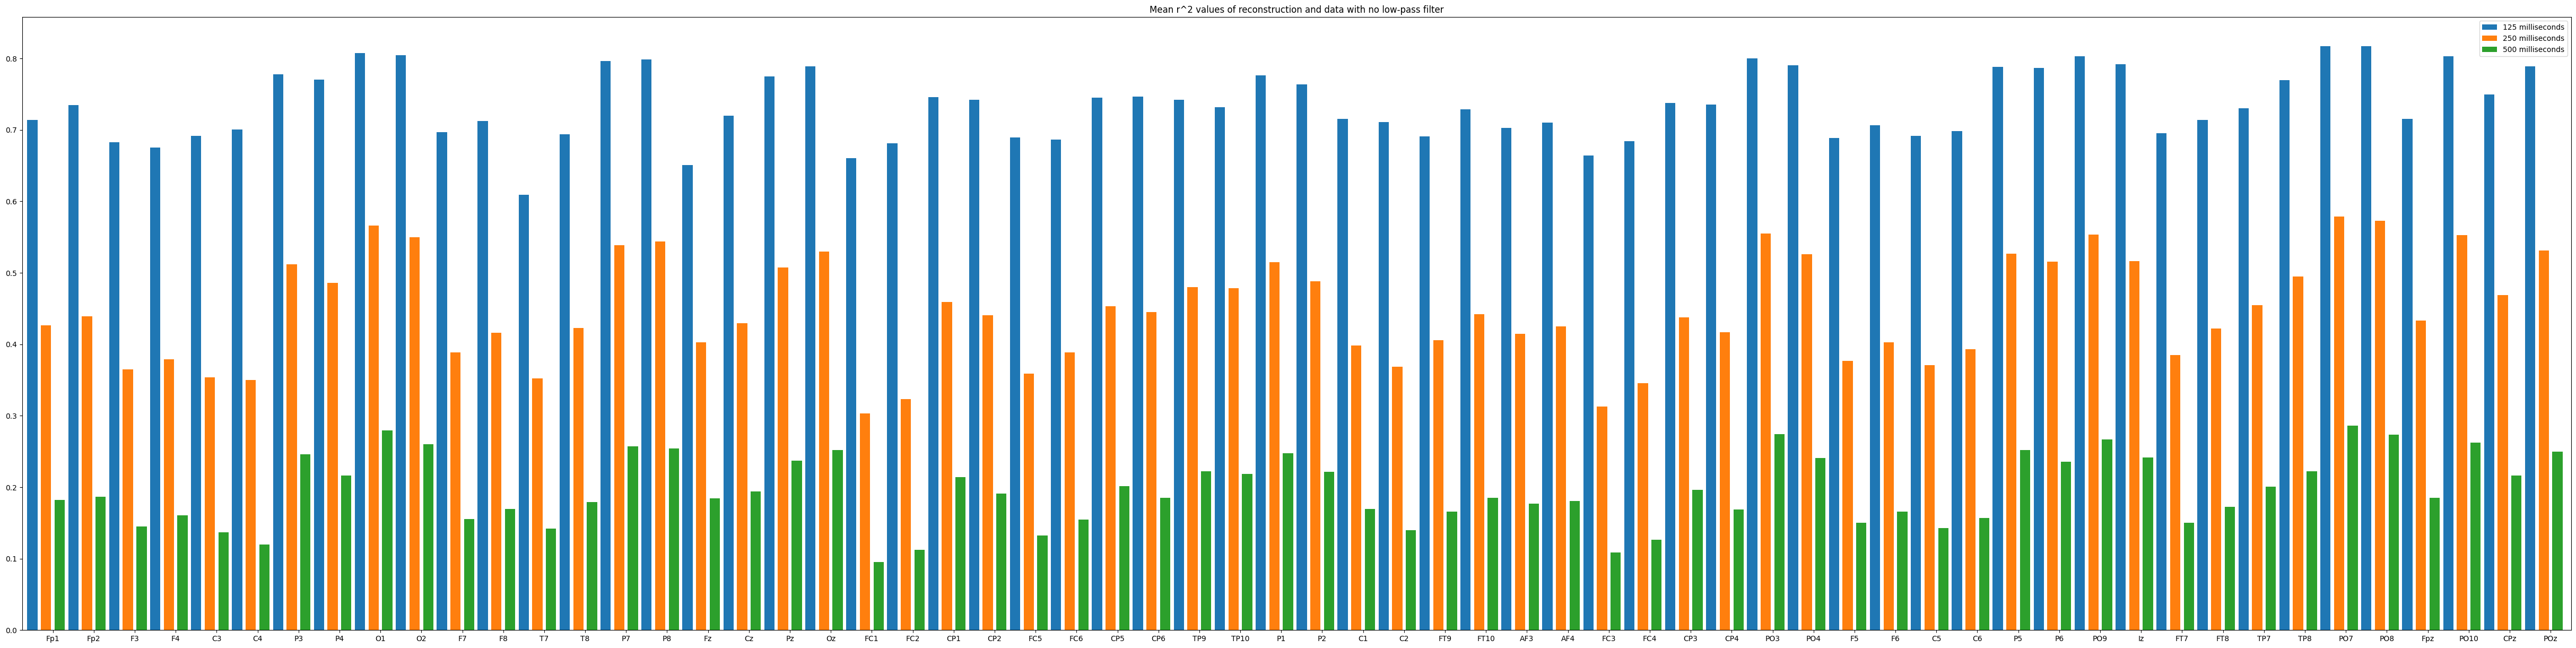

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(chl, 15), squeeze=False)
# ax[0,0].boxplot(meanofallsis, showfliers=False)
# ax[0,0].set_title("si by Channel")
ax[0,0].set_xticks(np.arange(0.5, chl+0.5), keep_channels)
ax[0,0].set_xlim(-0.25, 62)

# siplot = ax[0,0].boxplot(meanofallsis, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"))
papos = []
papos2 = []
for i in range(0, chl):
    papos.append(i + 1/3)
    papos2.append(i + 2/3)


plot125 = ax[0,0].bar(range(0,chl), means125raw, width = .25)
                        # , patch_artist=True, boxprops=dict(facecolor="red", color="red"), widths=0.25)
plot250 = ax[0,0].bar(papos, means250raw, width = .25)
                      # , patch_artist=True, boxprops=dict(facecolor="slateblue", color="slateblue"), widths=0.25)
plot500 = ax[0,0].bar(papos2, means500raw, width = .25)


plt.legend(("125 milliseconds", "250 milliseconds", "500 milliseconds"))
# plt.title("Difference between mean r^2 values of reconstruction with data filtered between 1-30hz and reconstruction with non-low-passed data")
# plt.title("Mean r^2 values of reconstruction and data filtered between 1-30hz")
plt.title("Mean r^2 values of reconstruction and data with no low-pass filter")
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "errormeansnoisy.svg"))


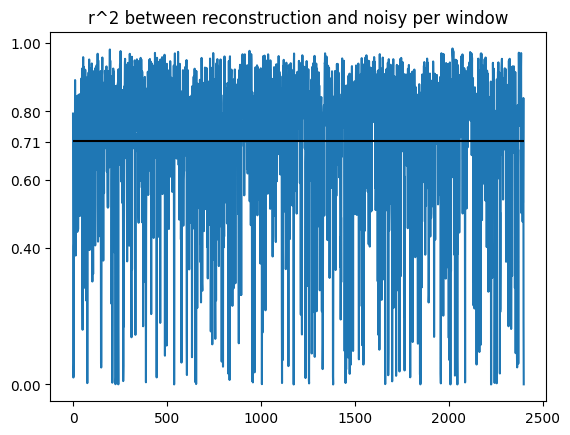

In [150]:
i = window_length_samples
pcor = []
while i < aproxeeg.shape[0]:
    s = stats.linregress(aproxeeg[i-window_length_samples:i,view], noisydata.transpose()[i-window_length_samples:i,view])[2]
    # s = stats.linregress(aproxeeg[i-window_length_samples:i,view], noiseless.transpose()[i-window_length_samples:i,view])[2]
    # s = stats.linregress(noisydata.transpose()[i-window_length_samples:i,view], noiseless.transpose()[i-window_length_samples:i,view])[2]
    pcor.append(s**2)
    i+=window_length_samples
    
plt.plot(range(len(pcor)), pcor)
plt.title("r^2 between reconstruction and noisy per window")
# plt.title("r^2 between reconstruction and filtered per window")
# plt.title("r^2 between noisy and raw per window")

plt.hlines([np.mean(pcor)], 0, aproxeeg.shape[0]/window_length_samples, color = "black")
plt.yticks(ticks=[0.0, 0.4, 0.6, 0.8, 1.0, np.round(np.mean(pcor), 2)])
# plt.hlines([np.median(pcor)], 0, aproxeeg.shape[0]/window_length_samples, color = "black")
# plt.yticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, np.round(np.median(pcor), 2)])

plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "r2reconstructionandnoisy.png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "r2reconstructionandraw.png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "r2noisyandraw.png"))

In [150]:
print(np.mean(pcor))

0.7963596009965899


In [154]:
print(np.median(pcor))

0.8584650785086181


In [157]:
print(np.median(pcor))

0.8224660310683685


In [80]:
print(xmin)

-1.0994335560699422e-08


In [40]:
print(stats.jarque_bera(gausdif))

SignificanceResult(statistic=np.float64(24875.576877046402), pvalue=np.float64(0.0))


In [52]:
print(stats.norm.fit(gausdif))

(np.float64(5.917620318991056e-09), np.float64(6.806511229710869e-06))


In [74]:
# print(stats.linregress(aproxeeg[start:end,view], data.transpose()[start:end,view]))
print(np.mean(stats.pearsonr(aproxeeg[start:end], data.transpose()[start:end])[0]))


0.9994759321086338


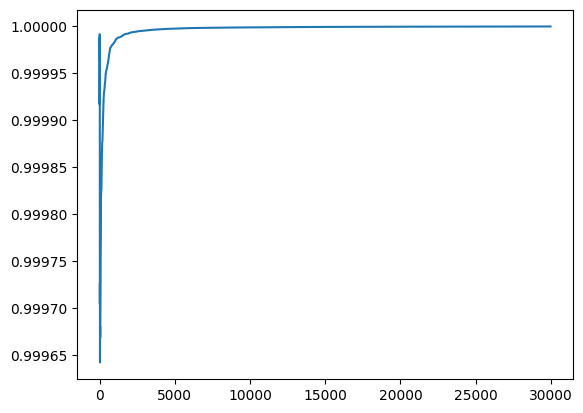

In [75]:
i = 10
pcor = []
while i < aproxeeg.shape[0]:
    s = stats.linregress(aproxeeg[start:i,view], data.transpose()[start:i,view])[2]
    pcor.append(s)
    i+=10

plt.plot(range(len(pcor)), pcor)
# plt.savefig(os.path.join(mainfolder + "Data\\Old_Graphs", "r_over_time.png"))


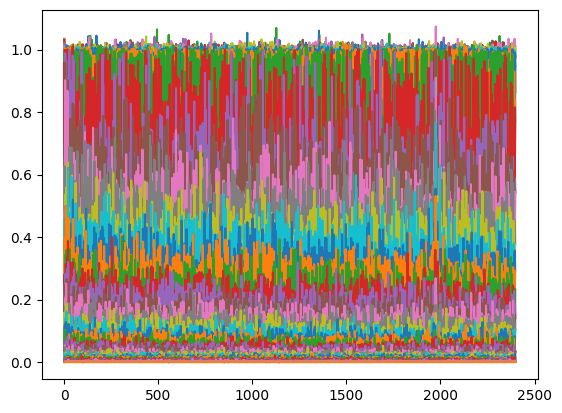

In [76]:
end2=evals.shape[0]-1


# end2=53

start2=0

reals = []
imags = []

for idx in evals:
    real = [ele.real for ele in idx]
    imag = [ele.imag for ele in idx]
    reals.append(real)
    imags.append(imag)

reals = np.asarray(reals)
imags = np.asarray(imags)

# plt.ylim(.8, .9)


for channel in reals.transpose():
    plt.plot(range(len(channel)+1)[start2:end2], channel[start2:end2])

# i=0
# channel = reals[:,i]
# plt.plot(range(len(channel)+1)[0:end2-1], channel[0:end2-1])
# print(i)
# i+=1

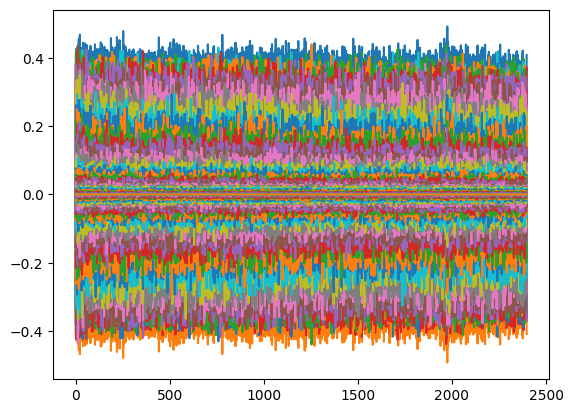

In [77]:
# plt.ylim(.45,.55)

for channel in imags.transpose():
    plt.plot(range(len(channel)+1)[start2:end2], channel[start2:end2])

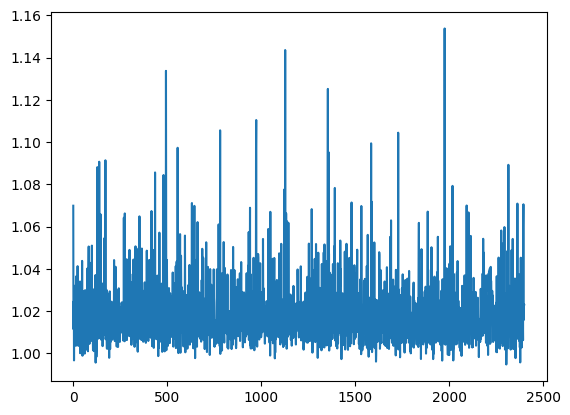

In [78]:
# i=14
#squaring an imaginary number and i get a positive? weird, maybe these are only the negative ones? no i guess it just didnt extract the imaginary part
# plt.plot(range(evals.shape[0]), (reals[:,i]**2+imags[:,i]**2))
# print(i)  
# print(imags[0:20,i]**2)
# print(imags[0:20,i])
maxes = []
for i in range(evals.shape[0]):
    maxes.append(max(reals[i]**2+imags[i]**2))
plt.plot(range(evals.shape[0]), maxes)


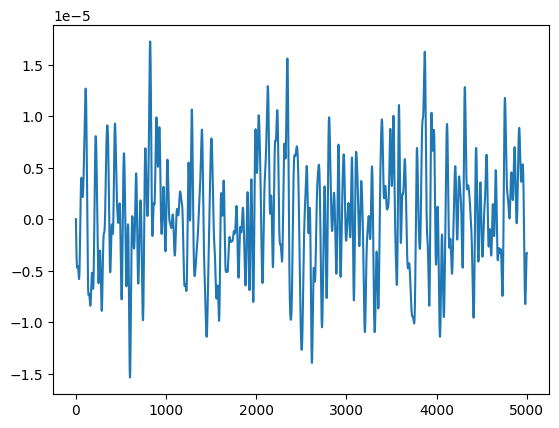

In [79]:
view = 0
# start = 55000
# end = data.shape[1]-1
start = 0
end = 5000
plt.plot(range(end+1)[start:end], data[view, start:end])
# plt.savefig(os.path.join(mainfolder + "Data\\Old_Graphs", "preprocessed_data_1A.png"))

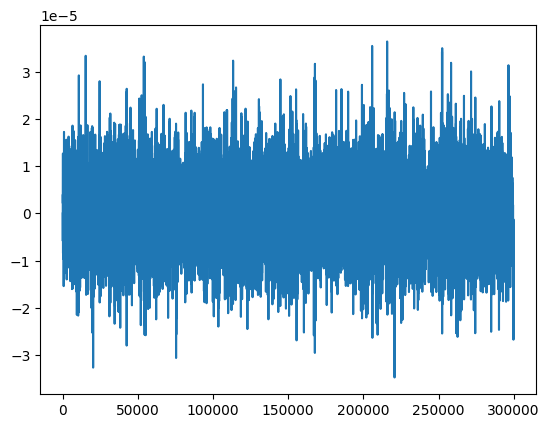

In [80]:
start = 0
end = data.shape[1]-1


plt.plot(range(end+1)[start:end], data[view, start:end])
# plt.savefig(os.path.join(mainfolder + "Data\\Old_Graphs", "preprocessed_data_1.png"))

Extracting parameters from C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\Data\eeg\sub-CBPpa02\eeg\sub-CBPpa02_task-closed_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 300003  =      0.000 ...   300.003 secs...


C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_6048\1496560035.py:1: RuntimeWarning: No coordinate information found for channels ['Ne', 'Ma']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  unprocessed = mne.io.read_raw_brainvision(eeg_filename)
C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_6048\1496560035.py:1: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['Ne', 'Ma']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  unprocessed = mne.io.read_raw_brainvision(eeg_filename)


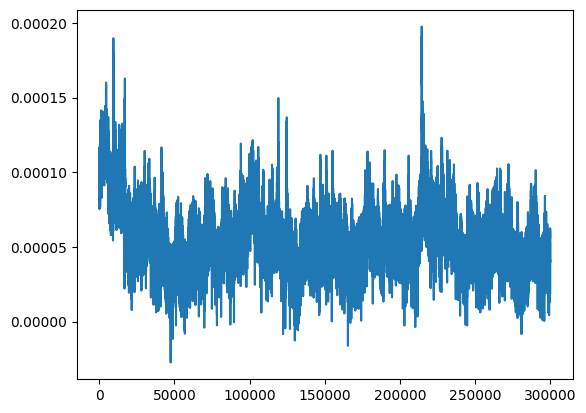

In [81]:
unprocessed = mne.io.read_raw_brainvision(eeg_filename)
unprocessed.pick(keep_channels)
unprocessed.load_data()
rawdata = unprocessed.get_data()

plt.plot(range(rawdata.shape[1]), rawdata[view])
# plt.savefig(os.path.join(mainfolder + "Data\\Old_Graphs", "rawdataexample.png"))

# Results

## Preprocessing

In [38]:
##the dataset I'm using has eyes closed eegs for all patients but some didn't do an eyes open eeg
##since I'm only doing the eyes closed data for now I could just add all the data from participants.tsv to the same row in PopulationStats.xlsx
##But I want to make this work for if I use the open eyes eegs later

In [39]:
print(rootdir)

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\10-20_directory


In [40]:
##locations of all the data i'm using
eyestate = '_task-closed_eeg.vhdr'

subdirlist = find_dirs_by_extension(rootdir, eyestate)
# print(subdirlist)

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\10-20_directory
['sub-CBPpa02', 'sub-CBPpa04', 'sub-CBPpa05', 'sub-CBPpa07', 'sub-CBPpa08', 'sub-CBPpa09', 'sub-CBPpa10', 'sub-CBPpa11', 'sub-CBPpa12', 'sub-CBPpa13', 'sub-CBPpa14', 'sub-CBPpa15', 'sub-CBPpa16', 'sub-CBPpa18', 'sub-CBPpa19', 'sub-CBPpa21', 'sub-CBPpa24', 'sub-CBPpa25', 'sub-CBPpa26', 'sub-CBPpa27', 'sub-CBPpa28', 'sub-CBPpa29', 'sub-CBPpa30', 'sub-CBPpa31', 'sub-CBPpa32', 'sub-CBPpa33', 'sub-CBPpa34', 'sub-CBPpa35', 'sub-CBPpa36', 'sub-CBPpa37', 'sub-CBPpa38', 'sub-CBPpa39', 'sub-CBPpa41', 'sub-CBPpa42', 'sub-FMhc01', 'sub-FMhc02', 'sub-FMhc03', 'sub-FMhc04', 'sub-FMhc05', 'sub-FMhc06', 'sub-FMhc07', 'sub-FMhc08', 'sub-FMhc09', 'sub-FMhc10', 'sub-FMhc11', 'sub-FMhc12', 'sub-FMhc13', 'sub-FMhc14', 'sub-FMhc15', 'sub-FMhc16', 'sub-FMhc17', 'sub-FMhc18', 'sub-FMhc19', 'sub-FMhc20', 'sub-FMhc21', 'sub-FMhc22', 'sub-FMpa01', 'sub-FMpa02', 'sub-FMpa03', 'sub-FMpa04', 'sub-FMpa05', 'sub-FMpa06', 'sub-FMpa07', 'sub-FMpa08

In [41]:
##patient id
patientids = []

for name in subdirlist:
    pid = name.split('\\')[7]
    pid = pid.split('_')[0]
    patientids.append(pid)

numPatients = len(patientids)

print(patientids)

['sub-CBPpa02', 'sub-CBPpa04', 'sub-CBPpa05', 'sub-CBPpa07', 'sub-CBPpa08', 'sub-CBPpa09', 'sub-CBPpa10', 'sub-CBPpa11', 'sub-CBPpa12', 'sub-CBPpa13', 'sub-CBPpa14', 'sub-CBPpa15', 'sub-CBPpa16', 'sub-CBPpa18', 'sub-CBPpa19', 'sub-CBPpa21', 'sub-CBPpa24', 'sub-CBPpa25', 'sub-CBPpa26', 'sub-CBPpa27', 'sub-CBPpa28', 'sub-CBPpa29', 'sub-CBPpa30', 'sub-CBPpa31', 'sub-CBPpa32', 'sub-CBPpa33', 'sub-CBPpa34', 'sub-CBPpa35', 'sub-CBPpa36', 'sub-CBPpa37', 'sub-CBPpa38', 'sub-CBPpa39', 'sub-CBPpa41', 'sub-CBPpa42', 'sub-FMhc01', 'sub-FMhc02', 'sub-FMhc03', 'sub-FMhc04', 'sub-FMhc05', 'sub-FMhc06', 'sub-FMhc07', 'sub-FMhc08', 'sub-FMhc09', 'sub-FMhc10', 'sub-FMhc11', 'sub-FMhc12', 'sub-FMhc13', 'sub-FMhc14', 'sub-FMhc15', 'sub-FMhc16', 'sub-FMhc17', 'sub-FMhc18', 'sub-FMhc19', 'sub-FMhc20', 'sub-FMhc21', 'sub-FMhc22', 'sub-FMpa01', 'sub-FMpa02', 'sub-FMpa03', 'sub-FMpa04', 'sub-FMpa05', 'sub-FMpa06', 'sub-FMpa07', 'sub-FMpa08', 'sub-FMpa09', 'sub-FMpa10', 'sub-FMpa11', 'sub-FMpa12', 'sub-FMpa13',

In [42]:
##extract participants.tsv as a DataFrame then remove the entries that dont have closed eye eegs

##defining participants

participants = pd.read_table(mainfolder + "Data\\participants.tsv")

dtypes = participants.dtypes
pcolumns = participants.columns

participants = participants.to_numpy()

removerows = []

##remove unwanted data from participants

x = 0

while x < (len(participants)):
    if participants[x][0] not in patientids:
        removerows.append(x)
    x += 1

participants = np.delete(participants, (removerows), axis = 0)



In [43]:
##define and order variables from participants
patientids = participants[:, 0]
diseasestates = participants[:, 5]
sex = participants[:, 3]
age = participants[:, 4]

currentpain = participants[:, 12]
avgpain = participants[:, 13]
paindur = participants[:, 15]

medquants = participants[:, 19]
pdisq = participants[:, 14]
pdisi = participants[:, 18]
mcgill = participants[:,11]


# print(subdirlist)
#put list of subdirectories in order
x = 0
while x < numPatients:
    subdirlist[x] = rootdir + '\\' + patientids[x] + '\\' + patientids[x] + eyestate
    x += 1

print(subdirlist)

['C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa01\\sub-FMpa01_task-closed_eeg.vhdr', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa02\\sub-FMpa02_task-closed_eeg.vhdr', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa03\\sub-FMpa03_task-closed_eeg.vhdr', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa04\\sub-FMpa04_task-closed_eeg.vhdr', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa05\\sub-FMpa05_task-closed_eeg.vhdr', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa06\\sub-FMpa06_task-closed_eeg.vhdr', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa07\\sub-FMpa07_task-closed_eeg.vhdr', 'C:\\Users\\Ultimateo\\OneDrive\\Desktop\\ChronicPainPractice\\10-20_directory\\sub-FMpa08\\sub-FMpa08_task-closed_ee

In [44]:
##sort the a matrix, sink indices, entropy files
amatlist = []
silist = []
entrolist = []
diaglist = []
powerslist = []
r2list = []
plist = []
powerlist = []
SVDlist = []
eigenlist = []
datalist = []
reallist = []
imaglist = []


for file in subdirlist:
    r2list.append(find_files_by_extension(file, 'r^2.csv')[0])
    plist.append(find_files_by_extension(file, '_p.csv')[0])
    powerlist.append(find_files_by_extension(file, 'power_by_channel.csv')[0])
    amatlist.append(find_files_by_extension(file, 'A_matrix_values.npy')[0])
    silist.append(find_files_by_extension(file, 'sink_indices.csv')[0])
    entrolist.append(find_files_by_extension(file, 'SVDentropy.csv')[0])
    diaglist.append(find_files_by_extension(file, 'diag_matrix_values.npy')[0])
    powerslist.append(find_files_by_extension(file, 'power_by_channel.csv')[0])
    SVDlist.append(find_files_by_extension(file, 'SVD.csv')[0])
    eigenlist.append(find_files_by_extension(file, '_eigenvalues.csv')[0])
    datalist.append(find_files_by_extension(file, 'data.npy')[0])
    reallist.append(find_files_by_extension(file, 'eigen_real.csv')[0])
    imaglist.append(find_files_by_extension(file, 'eigen_imag.csv')[0])

## Kmeans

In [51]:
print(xlarray[27])

NameError: name 'xlarray' is not defined

In [52]:
nvclist = []
nvplist = []

for file in powerslist:
    energy = pd.read_csv(file)
    energy = energy.to_numpy().transpose()
    # print(energy.shape)
    nvc, nvp = cluster(energy, 4)
    nvclist.append(nvc)
    nvplist.append(nvp)

nvclist = np.asarray(nvclist)
nvplist = np.asarray(nvplist)

In [53]:
print(energy.shape)

(19, 6666)


In [54]:

def normalize_matrix(matrix):
    # Convert to a numpy array if it's not already
    matrix = np.array(matrix)
    
    # Find the minimum and maximum values of the matrix
    min_val = matrix.min()
    max_val = matrix.max()
    
    # Normalize the matrix between 0 and 1
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    
    return normalized_matrix

# Example usage:
matrix = [[3, 7, 9], [1, 4, 6], [2, 8, 5]]
normalized_matrix = normalize_matrix(matrix)
print(normalized_matrix)

[[0.25  0.75  1.   ]
 [0.    0.375 0.625]
 [0.125 0.875 0.5  ]]


In [207]:
print(np.mean(energy))

0.5032474230241701


In [666]:
si = pd.read_csv(silist[0])
si = si.to_numpy().transpose()

print(si.shape)

(19, 6666)


In [667]:
amat = np.load(diaglist[0])
amat = amat.reshape(amat.shape[0],-1)

In [668]:
print(amat.shape)

(6666, 361)


In [674]:
# 88 hc 47 cbp 30 np
# 62 33 21
hc = 0
pa = 0


allenergy = np.zeros((19,1))
usedlen = []
n=0
# for file in silist:
# for file in datalist:
# for file in diaglist:
# for file in powerslist:
for file in silist:
    energy = pd.read_csv(file)
    energy = energy.to_numpy().transpose()
    # print(energy.shape)
    # energy = np.load(file)
    # energy = energy.reshape(energy.shape[0],-1)
    energy = normalize_matrix(energy)
    usedlen.append(energy.shape[0])
    try:
        np.isnan(diseasestates[n])
        n+=0
        if hc < 62:
            allenergy = np.concatenate((allenergy, energy), axis = 1)
            hc += 1
    except TypeError:
        n+=0
        # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
        if diseasestates[n] == 'CBP':
            if pa < 33:
                allenergy = np.concatenate((allenergy, energy), axis = 1)
                pa += 1
    n+=1

allenergy = allenergy

In [187]:
# 88 hc 47 cbp 30 np
# 62 33 21
hc = 0
pa = 0


allenergy = np.zeros((19,1))
usedlen = []
n=0
# for file in silist:
# for file in datalist:
# for file in diaglist:
# for file in powerslist:
for file in silist:
    energy = pd.read_csv(file)
    energy = energy.to_numpy().transpose()
    # print(energy.shape)
    # energy = np.load(file)
    # energy = energy.reshape(energy.shape[0],-1)
    energy = normalize_matrix(energy)
    usedlen.append(energy.shape[0])
    try:
        np.isnan(diseasestates[n])
        n+=0
        # if hc < 62:
        #     allenergy = np.concatenate((allenergy, energy), axis = 1)
        #     hc += 1
    except TypeError:
        n+=0
        # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
        if diseasestates[n] == 'CBP':
            if pa < 33:
                allenergy = np.concatenate((allenergy, energy), axis = 1)
                pa += 1
    n+=1

allenergy = allenergy

In [188]:
# 88 hc 47 cbp 30 np
# 62 33 21
hc = 0
pa = 0


allenergy1 = np.zeros((19,1))
usedlen1 = []
n=0
# for file in silist:
# for file in datalist:
# for file in diaglist:
# for file in powerslist:
for file in silist:
    energy = pd.read_csv(file)
    energy = energy.to_numpy().transpose()
    # print(energy.shape)
    # energy = np.load(file)
    # energy = energy.reshape(energy.shape[0],-1)
    energy = normalize_matrix(energy)
    usedlen1.append(energy.shape[0])
    try:
        np.isnan(diseasestates[n])
        n+=0
        if hc < 62:
            allenergy1 = np.concatenate((allenergy1, energy), axis = 1)
            hc += 1
    except TypeError:
        n+=0
        # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
        # if diseasestates[n] == 'CBP':
        #     if pa < 33:
        #         allenergy = np.concatenate((allenergy, energy), axis = 1)
        #         pa += 1
    n+=1

allenergy = allenergy

In [188]:
print(allenergy.shape)

(19, 28991620)


In [189]:
print(powers.shape)

(6666, 19)


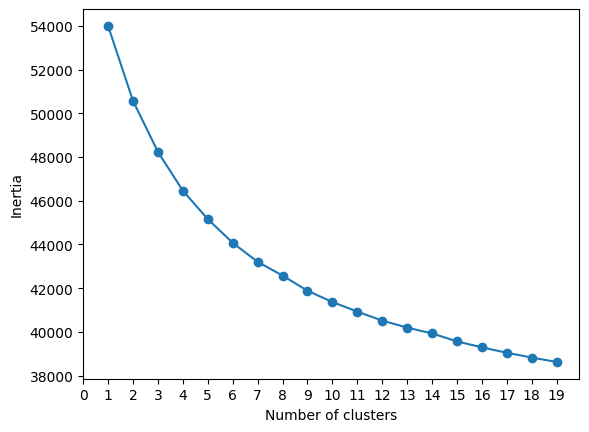

In [193]:
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, max_iter=10000)
    kmeans.fit(allenergy.transpose())
    inertias.append(kmeans.inertia_)
fig, ax = plt.subplots()

plt.plot(range(1,20), inertias, marker='o')
# plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.xticks(range(20))
plt.ylabel('Inertia')
plt.show() 

fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "superelbow.svg"))

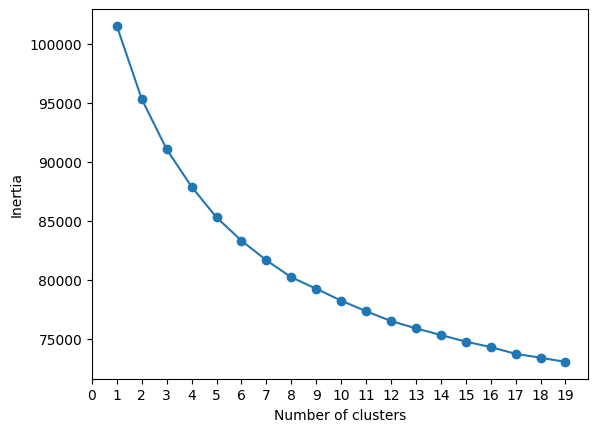

In [197]:
inertias1 = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, max_iter=10000)
    kmeans.fit(allenergy1.transpose())
    inertias1.append(kmeans.inertia_)
fig, ax = plt.subplots()

plt.plot(range(1,20), inertias1, marker='o')
# plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.xticks(range(20))
plt.ylabel('Inertia')
plt.show() 

fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "superelbow1.svg"))

In [198]:
inertias = []

nclusters=4
kmeans = KMeans(n_clusters=nclusters, max_iter=1000)
kmeans.fit(allenergy.transpose())
inertias.append(kmeans.inertia_)

In [199]:
inertias1 = []

nclusters=4
kmeans1 = KMeans(n_clusters=nclusters, max_iter=1000)
kmeans1.fit(allenergy1.transpose())
inertias1.append(kmeans.inertia_)

In [200]:


changes=np.zeros((nclusters,nclusters), dtype=int)
points=np.zeros((nclusters,), dtype=int)
for i in range(len(kmeans.labels_)-1):
    x=kmeans.labels_[i]
    y=kmeans.labels_[i+1]
    changes[x,y]+=1
    points[x]+=1
points[y]+=1

print(changes)
print(points)

[[22081 10980 13174 14833]
 [11174 17051  8757 10760]
 [13107  8897 16769 11572]
 [14706 10815 11645 23657]]
[61068 47743 50345 60823]


In [201]:


changes1=np.zeros((nclusters,nclusters), dtype=int)
points1=np.zeros((nclusters,), dtype=int)
for i in range(len(kmeans1.labels_)-1):
    x=kmeans1.labels_[i]
    y=kmeans1.labels_[i+1]
    changes1[x,y]+=1
    points1[x]+=1
points1[y]+=1

print(changes1)
print(points1)

[[52262 28019 23335 28026]
 [28069 32660 16668 24291]
 [22988 16686 28983 18161]
 [28322 24323 17832 33602]]
[131642 101688  86818 104080]


In [710]:
distmat = np.zeros((nclusters,nclusters))

In [711]:
closestk = 0
for i in range(nclusters):
    for j in range(nclusters):
        distmat[i,j] = np.linalg.norm(kmeans.cluster_centers_[i]-kmeans.cluster_centers_[j])**2

[[0.         0.14748911 0.08711736 0.12505296]
 [0.14748911 0.         0.13768327 0.3237906 ]
 [0.08711736 0.13768327 0.         0.1368624 ]
 [0.12505296 0.3237906  0.1368624  0.        ]]


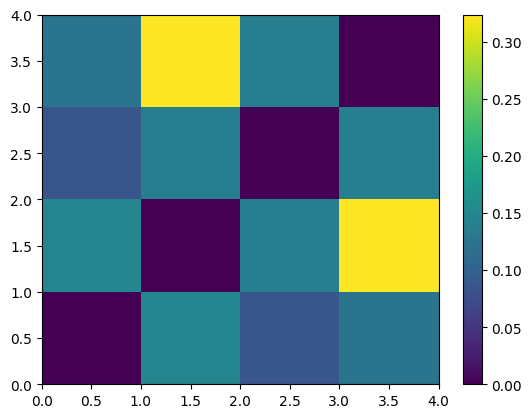

In [712]:
print(distmat)
fig, ax = plt.subplots()
im = ax.pcolormesh(distmat)
fig.colorbar(im)
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "eucdist.svg"))

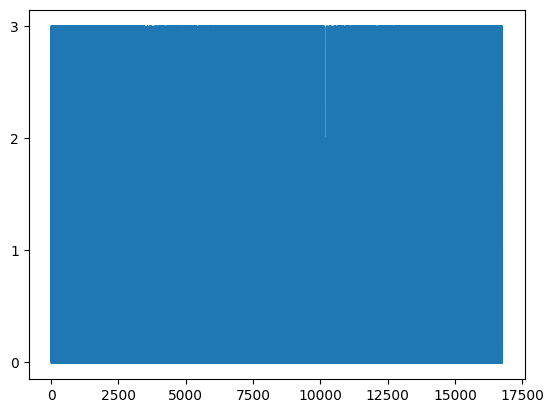

In [713]:
plt.step(np.arange(16749), kmeans.labels_[0:16749])
plt.yticks(range(nclusters))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "hypnogram.svg"))

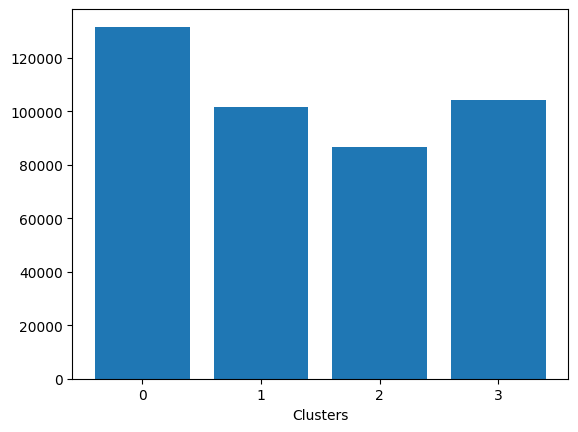

In [203]:
plt.bar(range(0,nclusters),points1)
plt.xlabel("Clusters")
plt.xticks(range(0,nclusters))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "superclusterbar1.svg"))

In [726]:
print(len(kmeans.cluster_centers_))

4


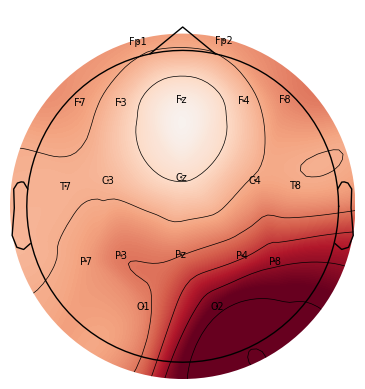

In [212]:
fig, ax = plt.subplots()

n=3

mne.viz.plot_topomap(kmeans1.cluster_centers_[n], xypos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "1supercluster" + str(n) + ".svg"))
# n+=1

In [717]:
n=0

IndexError: index 3 is out of bounds for axis 0 with size 3

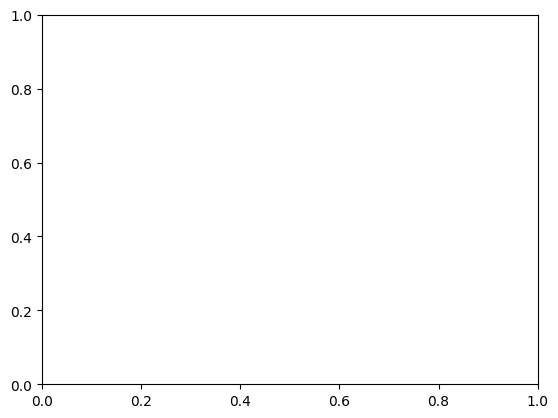

In [632]:
fig, ax = plt.subplots()
im = ax.pcolormesh(kmeans.cluster_centers_[n].reshape(19,-1))
fig.colorbar(im)
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "squarecluster" + str(n) +".svg"))
n+=1

In [220]:
print(kmeans.cluster_centers_[0])

[1.75541440e-06 1.70802122e-06 1.00042196e-06 8.97404122e-07
 2.35276409e-06 2.27495083e-06 3.36581395e-06 3.35021132e-06
 4.47903891e-06 4.56680808e-06 3.17255300e-06 3.23362394e-06
 4.84625414e-06 4.89671919e-06 3.03856706e-07 4.19203091e-07
 2.48678083e-06 1.64843935e-06 1.58999402e-06]


In [221]:
print(len(kmeans.labels_))

28991620


In [222]:
print(usedlen)

[334996, 327996, 312996, 350996, 361996, 306996, 343996, 310996, 297996, 300996, 313996, 305996, 300996, 300996, 301996, 301996, 300996, 302996, 304996, 301996, 359996, 335996, 319996, 360996, 309996, 360996, 470996, 316996, 313996, 306996, 303996, 308996, 311996, 299996, 299996, 301996, 300996, 304996, 300996, 299996, 299996, 300996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996, 299996,

In [732]:
n=0
hc=0
pa=0
curlen = 0
hclabels = []
nplabels = []
# for file in powerslist:
# for file in diaglist:
for file in silist:
    if n == n:
        try:
            np.isnan(diseasestates[n])
            n+=0
            if hc < 62:
                hclabels.append(kmeans.labels_[curlen:curlen+usedlen[n]])
                curlen=curlen+usedlen[n]+1
                hc+=1
        except TypeError:
            n+=0
            # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            if diseasestates[n] == 'CBP':
                if pa < 33:
                    nplabels.append(kmeans.labels_[curlen:curlen+usedlen[n]])
                    curlen=curlen+usedlen[n]+1
                    pa+=1
        n+=1


In [733]:
print(hclabels)
# print(nplabels)

[array([2, 1, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2],
      dtype=int32), array([3, 1, 2, 2, 0, 3, 3, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1],
      dtype=int32), array([1, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 3, 3, 1, 0, 2, 2, 1],
      dtype=int32), array([1, 2, 3, 3, 0, 1, 2, 2, 3, 2, 0, 2, 0, 3, 2, 1, 3, 1, 0],
      dtype=int32), array([1, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 1, 1, 3, 2, 0, 0, 0, 2],
      dtype=int32), array([0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2],
      dtype=int32), array([0, 0, 3, 3, 3, 3, 0, 3, 0, 1, 2, 2, 3, 3, 3, 3, 3, 0, 3],
      dtype=int32), array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 0, 3, 2, 0, 0],
      dtype=int32), array([1, 3, 3, 3, 0, 2, 3, 3, 3, 2, 0, 2, 3, 1, 0, 2, 3, 0, 3],
      dtype=int32), array([1, 1, 1, 0, 0, 1, 1, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0],
      dtype=int32), array([3, 0, 3, 3, 1, 2, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 2],
      dtype=int32), array([2, 3, 3, 0, 0, 1, 3, 3, 3, 1, 2, 0, 1, 3, 1, 2, 3, 3, 2],

In [734]:
flat_hc = []
flat_np = []


for xs in hclabels:
    for x in xs:
        flat_hc.append(int(x))

flat_list = []

for xs in nplabels:
    for x in xs:
        flat_np.append(int(x))

In [735]:
dwell0 = []
dwell1 = []
dwell2 = []
dwell3 = []

i=0
n=0
lastn=1000
combo=0
while i < len(flat_np):
    n=flat_np[i]
    if n != lastn:
        if lastn == 0:
            dwell0.append(combo)
        if lastn == 1:
            dwell1.append(combo)
        if lastn == 2:
            dwell2.append(combo)
        if lastn == 3:
            dwell3.append(combo)
        combo = 0
        
    combo+=1
    i+=1
    lastn=n

dwain = [np.mean(dwell0), np.mean(dwell1), np.mean(dwell2),np.mean(dwell3)]

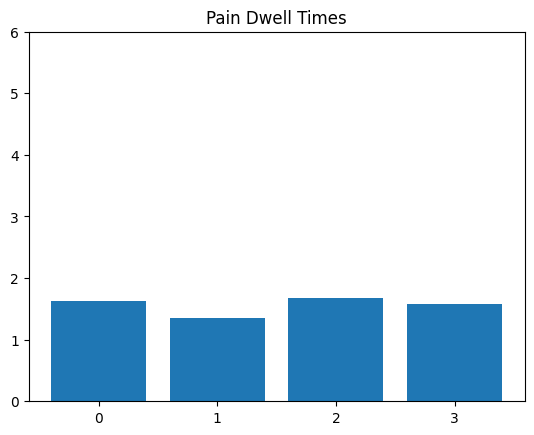

In [736]:

plt.bar(range(0,nclusters),dwain)
plt.title("Pain Dwell Times")
plt.xticks(range(nclusters))
plt.yticks(range(0,7))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "paindwell.svg"))

In [739]:
dwell0 = []
dwell1 = []
dwell2 = []
dwell3 = []

i=0
n=0
lastn=1000
combo=0
while i < len(flat_hc):
    n=flat_hc[i]
    if n != lastn:
        if lastn == 0:
            dwell0.append(combo)
        if lastn == 1:
            dwell1.append(combo)
        if lastn == 2:
            dwell2.append(combo)
        if lastn == 3:
            dwell3.append(combo)
        combo = 0
        
    combo+=1
    i+=1
    lastn=n


dwelthy = [np.mean(dwell0), np.mean(dwell1), np.mean(dwell2),np.mean(dwell3)]

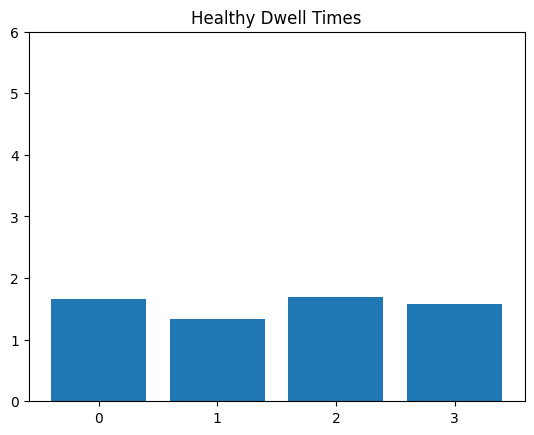

In [740]:

plt.bar(range(0,nclusters),dwelthy)
plt.title("Healthy Dwell Times")
plt.xticks(range(nclusters))
plt.yticks(range(0,7))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "healthydwell.svg"))

In [741]:
hcchanges=np.zeros((nclusters,nclusters), dtype=int)
hcpoints=np.zeros((nclusters,), dtype=int)

for i in range(len(flat_hc)-1):
    x=flat_hc[i]
    y=flat_hc[i+1]
    hcchanges[x,y]+=1
    hcpoints[x]+=1
hcpoints[y]+=1


print(hcpoints)

[385 169 358 266]


In [742]:
hctrans = []
for i in hcchanges:
    print(np.round(i/np.sum(i),2))
    hctrans.append(i/np.sum(i))

hctrans = np.asarray(hctrans)

[0.39 0.14 0.27 0.2 ]
[0.31 0.25 0.24 0.2 ]
[0.32 0.1  0.41 0.17]
[0.25 0.14 0.25 0.36]


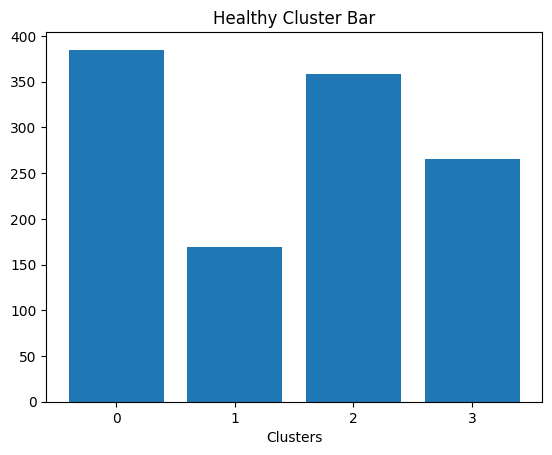

In [744]:
plt.bar(range(0,nclusters),hcpoints)
plt.xlabel("Clusters")
# plt.xlim(0,nclusters)
plt.xticks(range(nclusters))
plt.title("Healthy Cluster Bar")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "hccluster.svg"))

In [745]:
npchanges=np.zeros((nclusters,nclusters), dtype=int)
nppoints=np.zeros((nclusters,), dtype=int)

for i in range(len(flat_np)-1):
    x=flat_np[i]
    y=flat_np[i+1]
    npchanges[x,y]+=1
    nppoints[x]+=1
nppoints[y]+=1

print(npchanges)
      # /len(flat_np))
print(nppoints)

[[72 23 60 32]
 [18 21 31 12]
 [58 23 86 47]
 [40 14 37 52]]
[188  82 214 143]


In [746]:
nptrans = []
for i in npchanges:
    print(np.round(i/np.sum(i),2))
    nptrans.append(i/np.sum(i))

nptrans = np.asarray(nptrans)

[0.39 0.12 0.32 0.17]
[0.22 0.26 0.38 0.15]
[0.27 0.11 0.4  0.22]
[0.28 0.1  0.26 0.36]


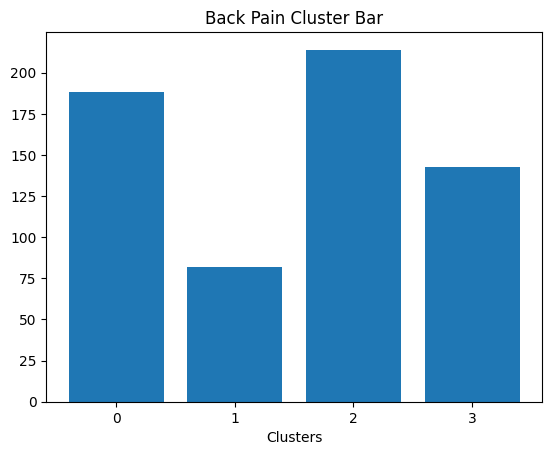

In [748]:
plt.bar(range(0,nclusters),nppoints)
plt.xlabel("Clusters")
plt.xticks(range(nclusters))
plt.title("Back Pain Cluster Bar")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "npclusterbar.svg"))

In [128]:
print(energy.shape)

(19, 6666)


In [751]:
print(testtrans.shape)

(3, 3)


In [753]:
n=0
hc=0
pa=0
curlen = 0
hctest = []
nptest = []

hchc = []
hcpa = []

# for file in datalist:
# for file in powerslist:
# for file in diaglist:
for file in silist:
    if n == n:
        flattest = []
        try:
            np.isnan(diseasestates[n])
            n+=0
            if hc > 62:
                energy = pd.read_csv(file)
                energy = energy.to_numpy()
                # energy = np.load(file).transpose()
                energy = normalize_matrix(energy)
                # energy = np.load(file)
                # energy = energy.reshape(energy.shape[0],-1)
                for i in energy:
                    closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                    closestk = 0
                    for k in range(nclusters):
                        if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                            closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                            closestk = k
                    flattest.append(closestk)
                testchanges=np.zeros((nclusters,nclusters), dtype=int)
                
                for l in range(len(flattest)-1):
                    x=flattest[l]
                    y=flattest[l+1]
                    testchanges[x,y]+=1
                testtrans = []
                for j in testchanges:
                    # print(i)
                    testtrans.append(j/np.sum(i))
                    # print(np.sum(i))

                testtrans = np.asarray(testtrans)
                # hchc.append(np.linalg.norm(testtrans - hctrans)**2)
                # hcpa.append(np.linalg.norm(testtrans - nptrans)**2)
                # hchc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                # hcpa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                hchc.append(stats.pearsonr(testtrans.flatten(), hctrans.flatten())[0])
                hcpa.append(stats.pearsonr(testtrans.flatten(), nptrans.flatten())[0])

                


                
            hc+=1
        except TypeError:
            n+=0
            # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            if diseasestates[n] == 'CBP':
                if pa > 33:
                    energy = pd.read_csv(file)
                    energy = energy.to_numpy()
                    # energy = np.load(file).transpose()
                    # energy = np.load(file)
                    # energy = energy.reshape(energy.shape[0],-1)
                    energy = normalize_matrix(energy)
                    for i in energy:
                        closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                        closestk = 0
                        for k in range(nclusters):
                            if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                                closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                                closestk = k
                        flattest.append(closestk)

                    testchanges=np.zeros((nclusters,nclusters), dtype=int)
                    
                    for l in range(len(flattest)-1):
                        x=flattest[l]
                        y=flattest[l+1]
                        testchanges[x,y]+=1
                    testtrans = []
                    for j in testchanges:
                        testtrans.append(j/np.sum(i))
                        print(j)

                        # print(np.sum(i))
                    testtrans = np.asarray(testtrans)
                    # pahc.append(np.linalg.norm(testtrans - hctrans)**2)
                    # papa.append(np.linalg.norm(testtrans - nptrans)**2)
                    # pahc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                    # papa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                    pahc.append(stats.pearsonr(testtrans.flatten(), hctrans.flatten())[0])
                    papa.append(stats.pearsonr(testtrans.flatten(), nptrans.flatten())[0])
                pa+=1
        n+=1


[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]


In [753]:
n=0
hc=0
pa=0
curlen = 0
hctest = []
nptest = []

hchc = []
hcpa = []
pahc = []
papa = []
# for file in datalist:
# for file in powerslist:
# for file in diaglist:
for file in silist:
    if n == n:
        flattest = []
        try:
            np.isnan(diseasestates[n])
            n+=0
            if hc > 62:
                energy = pd.read_csv(file)
                energy = energy.to_numpy()
                # energy = np.load(file).transpose()
                energy = normalize_matrix(energy)
                # energy = np.load(file)
                # energy = energy.reshape(energy.shape[0],-1)
                for i in energy:
                    closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                    closestk = 0
                    for k in range(nclusters):
                        if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                            closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                            closestk = k
                    flattest.append(closestk)
                testchanges=np.zeros((nclusters,nclusters), dtype=int)
                
                for l in range(len(flattest)-1):
                    x=flattest[l]
                    y=flattest[l+1]
                    testchanges[x,y]+=1
                testtrans = []
                for j in testchanges:
                    # print(i)
                    testtrans.append(j/np.sum(i))
                    # print(np.sum(i))

                testtrans = np.asarray(testtrans)
                # hchc.append(np.linalg.norm(testtrans - hctrans)**2)
                # hcpa.append(np.linalg.norm(testtrans - nptrans)**2)
                # hchc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                # hcpa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                hchc.append(stats.pearsonr(testtrans.flatten(), hctrans.flatten())[0])
                hcpa.append(stats.pearsonr(testtrans.flatten(), nptrans.flatten())[0])

                


                
            hc+=1
        except TypeError:
            n+=0
            # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            if diseasestates[n] == 'CBP':
                if pa > 33:
                    energy = pd.read_csv(file)
                    energy = energy.to_numpy()
                    # energy = np.load(file).transpose()
                    # energy = np.load(file)
                    # energy = energy.reshape(energy.shape[0],-1)
                    energy = normalize_matrix(energy)
                    for i in energy:
                        closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                        closestk = 0
                        for k in range(nclusters):
                            if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                                closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                                closestk = k
                        flattest.append(closestk)

                    testchanges=np.zeros((nclusters,nclusters), dtype=int)
                    
                    for l in range(len(flattest)-1):
                        x=flattest[l]
                        y=flattest[l+1]
                        testchanges[x,y]+=1
                    testtrans = []
                    for j in testchanges:
                        testtrans.append(j/np.sum(i))
                        print(j)

                        # print(np.sum(i))
                    testtrans = np.asarray(testtrans)
                    # pahc.append(np.linalg.norm(testtrans - hctrans)**2)
                    # papa.append(np.linalg.norm(testtrans - nptrans)**2)
                    # pahc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                    # papa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                    pahc.append(stats.pearsonr(testtrans.flatten(), hctrans.flatten())[0])
                    papa.append(stats.pearsonr(testtrans.flatten(), nptrans.flatten())[0])
                pa+=1
        n+=1


[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]


In [753]:
n=0
hc=0
pa=0
curlen = 0
hctest = []
nptest = []

hchc = []
hcpa = []
pahc = []
papa = []
# for file in datalist:
# for file in powerslist:
# for file in diaglist:
for file in silist:
    if n == n:
        flattest = []
        try:
            np.isnan(diseasestates[n])
            n+=0
            if hc > 62:
                energy = pd.read_csv(file)
                energy = energy.to_numpy()
                # energy = np.load(file).transpose()
                energy = normalize_matrix(energy)
                # energy = np.load(file)
                # energy = energy.reshape(energy.shape[0],-1)
                for i in energy:
                    closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                    closestk = 0
                    for k in range(nclusters):
                        if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                            closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                            closestk = k
                    flattest.append(closestk)
                testchanges=np.zeros((nclusters,nclusters), dtype=int)
                
                for l in range(len(flattest)-1):
                    x=flattest[l]
                    y=flattest[l+1]
                    testchanges[x,y]+=1
                testtrans = []
                for j in testchanges:
                    # print(i)
                    testtrans.append(j/np.sum(i))
                    # print(np.sum(i))

                testtrans = np.asarray(testtrans)
                # hchc.append(np.linalg.norm(testtrans - hctrans)**2)
                # hcpa.append(np.linalg.norm(testtrans - nptrans)**2)
                # hchc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                # hcpa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                hchc.append(stats.pearsonr(testtrans.flatten(), hctrans.flatten())[0])
                hcpa.append(stats.pearsonr(testtrans.flatten(), nptrans.flatten())[0])

                


                
            hc+=1
        except TypeError:
            n+=0
            # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            if diseasestates[n] == 'CBP':
                if pa > 33:
                    energy = pd.read_csv(file)
                    energy = energy.to_numpy()
                    # energy = np.load(file).transpose()
                    # energy = np.load(file)
                    # energy = energy.reshape(energy.shape[0],-1)
                    energy = normalize_matrix(energy)
                    for i in energy:
                        closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                        closestk = 0
                        for k in range(nclusters):
                            if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                                closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                                closestk = k
                        flattest.append(closestk)

                    testchanges=np.zeros((nclusters,nclusters), dtype=int)
                    
                    for l in range(len(flattest)-1):
                        x=flattest[l]
                        y=flattest[l+1]
                        testchanges[x,y]+=1
                    testtrans = []
                    for j in testchanges:
                        testtrans.append(j/np.sum(i))
                        print(j)

                        # print(np.sum(i))
                    testtrans = np.asarray(testtrans)
                    # pahc.append(np.linalg.norm(testtrans - hctrans)**2)
                    # papa.append(np.linalg.norm(testtrans - nptrans)**2)
                    # pahc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                    # papa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                    pahc.append(stats.pearsonr(testtrans.flatten(), hctrans.flatten())[0])
                    papa.append(stats.pearsonr(testtrans.flatten(), nptrans.flatten())[0])
                pa+=1
        n+=1


[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]
[787 330 612 285]
[323 520 360 147]
[603 353 897 317]
[302 146 301 382]


In [650]:
n=0
hc=0
pa=0
curlen = 0
hctest = []
nptest = []

hchc = []
hcpa = []
pahc = []
papa = []
for file in datalist:
# for file in powerslist:
    if n == n:
        flattest = []
        try:
            np.isnan(diseasestates[n])
            n+=0
            if hc > 62:
                # energy = pd.read_csv(file)
                # energy = energy.to_numpy()
                energy = np.load(file).transpose()
                # energy = normalize_matrix(energy)
                dwell0 = []
                dwell1 = []
                dwell2 = []
                dwell3 = []
                
                i=0
                n=0
                lastn=1000
                combo=0
                while i < len(flat_hc):
                    n=flat_hc[i]
                    if n != lastn:
                        if lastn == 0:
                            dwell0.append(combo)
                        if lastn == 1:
                            dwell1.append(combo)
                        if lastn == 2:
                            dwell2.append(combo)
                        if lastn == 3:
                            dwell3.append(combo)
                        combo = 0
                        
                    combo+=1
                    i+=1
                    lastn=n
                testtrans=[np.mean(dwell0), np.mean(dwell1), np.mean(dwell2),np.mean(dwell3)]
                testtrans = np.asarray(testtrans)
                dwelthy = np.asarray(dwelthy)
                dwain = np.asarray(dwain)

                hchc.append(np.mean(np.abs(testtrans - dwelthy)))
                hcpa.append(np.mean(np.abs(testtrans - dwain)))

                


                
            hc+=1
        except TypeError:
            n+=0
            # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            if diseasestates[n] == 'CBP':
                if pa > 33:
                    # energy = pd.read_csv(file)
                    # energy = energy.to_numpy()
                    energy = np.load(file).transpose()

                    # energy = normalize_matrix(energy)
                    i=0
                    n=0
                    lastn=1000
                    combo=0
                    while i < len(flat_hc):
                        n=flat_hc[i]
                        if n != lastn:
                            if lastn == 0:
                                dwell0.append(combo)
                            if lastn == 1:
                                dwell1.append(combo)
                            if lastn == 2:
                                dwell2.append(combo)
                            if lastn == 3:
                                dwell3.append(combo)
                            combo = 0
                            
                        combo+=1
                        i+=1
                        lastn=n
                    testtrans=[np.mean(dwell0), np.mean(dwell1), np.mean(dwell2),np.mean(dwell3)]
                    testtrans = np.asarray(testtrans)
                    dwelthy = np.asarray(dwelthy)
                    dwain = np.asarray(dwain)
    
    
                    pahc.append(np.mean(np.abs(testtrans - dwelthy)))
                    papa.append(np.mean(np.abs(testtrans - dwain)))

                pa+=1
        n+=1


In [655]:
indexes = [1,3,5,12,15]
n=0
hc=0
pa=0
curlen = 0
hctest = []
nptest = []

hchc = []
hcpa = []
pahc = []
papa = []
# for file in datalist:
# for file in powerslist:
for file in diaglist:
    if n == n:
        flattest = []
        try:
            np.isnan(diseasestates[n])
            n+=0
            if hc > 62:
                # energy = pd.read_csv(file)
                # energy = energy.to_numpy()
                # energy = normalize_matrix(energy)
                # energy = np.load(file).transpose()
                energy = np.load(file)
                energy = energy.reshape(energy.shape[0],-1)
                
                for i in energy:
                    closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                    closestk = 0
                    for k in range(nclusters):
                        if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                            closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                            closestk = k
                    flattest.append(closestk)
                testchanges=np.zeros((nclusters,nclusters), dtype=int)
                
                for l in range(len(flattest)-1):
                    x=flattest[l]
                    y=flattest[l+1]
                    testchanges[x,y]+=1
                testtrans = []
                for j in testchanges:
                    # print(i)
                    testtrans.append(j/np.sum(i))
                    # print(np.sum(i))

                testtrans = np.asarray(testtrans)
                # hchc.append(np.linalg.norm(testtrans - hctrans)**2)
                # hcpa.append(np.linalg.norm(testtrans - nptrans)**2)
                # hchc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                # hcpa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                hchc.append(stats.pearsonr([testtrans.flatten()[x] for x in indexes], [hctrans.flatten()[x] for x in indexes])[0])
                hcpa.append(stats.pearsonr([testtrans.flatten()[x] for x in indexes], [nptrans.flatten()[x] for x in indexes])[0])

                


                
            hc+=1
        except TypeError:
            n+=0
            # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            if diseasestates[n] == 'CBP':
                if pa > 33:
                    # energy = pd.read_csv(file)
                    # energy = energy.to_numpy()
                    # energy = normalize_matrix(energy)
                    # energy = np.load(file).transpose()
                    energy = np.load(file)
                    energy = energy.reshape(energy.shape[0],-1)
                    for i in energy:
                        closest = np.linalg.norm(i-kmeans.cluster_centers_[0])**2
                        closestk = 0
                        for k in range(nclusters):
                            if np.linalg.norm(i-kmeans.cluster_centers_[k])**2 < closest:
                                closest = np.linalg.norm(i-kmeans.cluster_centers_[k])**2
                                closestk = k
                        flattest.append(closestk)

                    testchanges=np.zeros((nclusters,nclusters), dtype=int)
                    
                    for l in range(len(flattest)-1):
                        x=flattest[l]
                        y=flattest[l+1]
                        testchanges[x,y]+=1
                    testtrans = []
                    for j in testchanges:
                        testtrans.append(j/np.sum(i))
                        print(j)

                        # print(np.sum(i))
                    testtrans = np.asarray(testtrans)
                    # pahc.append(np.linalg.norm(testtrans - hctrans)**2)
                    # papa.append(np.linalg.norm(testtrans - nptrans)**2)
                    # pahc.append(np.sum(np.matmul(testtrans, np.linalg.inv(hctrans))))
                    # papa.append(np.sum(np.matmul(testtrans, np.linalg.inv(nptrans))))
                    pahc.append(stats.pearsonr([testtrans.flatten()[x] for x in indexes], [hctrans.flatten()[x] for x in indexes])[0])
                    papa.append(stats.pearsonr([testtrans.flatten()[x] for x in indexes], [nptrans.flatten()[x] for x in indexes])[0])
                pa+=1
        n+=1


[2557  506  608]
[501 663 244]
[613 239 734]


IndexError: index 12 is out of bounds for axis 0 with size 9

In [652]:
print(testtrans.flatten()[main_list[x] for x in indexes])


SyntaxError: invalid syntax. Perhaps you forgot a comma? (83991915.py, line 1)

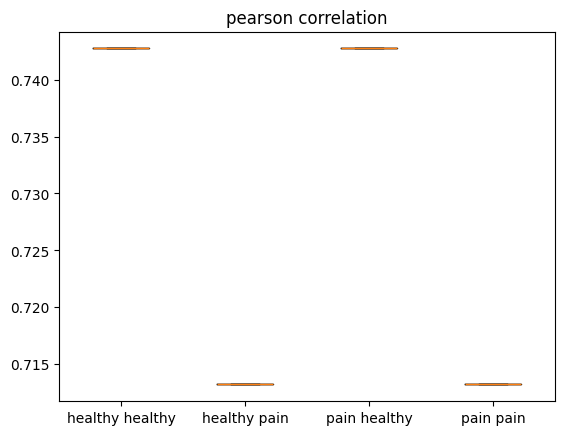

In [754]:
plt.boxplot((hchc, hcpa, pahc, papa), tick_labels=("healthy healthy", "healthy pain", "pain healthy", "pain pain"), showfliers=True)
plt.title("pearson correlation")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "nothingcorrelation.svg"))

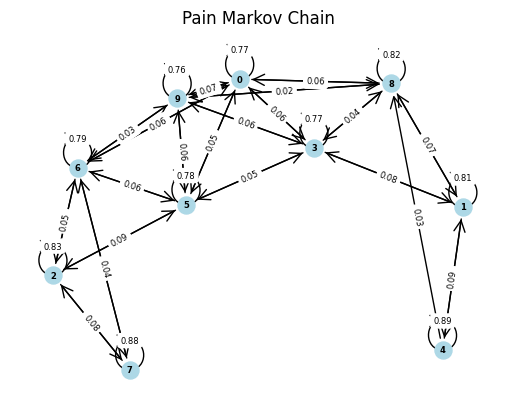

In [164]:
G = nx.DiGraph()

# Add edges with transition probabilities
for i in range(nclusters):
    for j in range(nclusters):
        prob = nptrans[i, j]
        if prob > 0.009:  # Only add edges with non-zero probability
            G.add_edge(range(nclusters)[i], range(nclusters)[j], weight=prob)

# Define layout for visualization
pos = nx.spring_layout(G, seed=42)  # You can try other layouts too

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=150, node_color='lightblue')

# Draw edges
edges = G.edges(data=True)
edge_weights = [f"{d['weight']:.2f}" for (_, _, d) in edges]
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold')

# Draw edge labels (transition probabilities)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.title("Pain Markov Chain")
plt.axis('off')
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs\\kmeans", "npmarkov.svg"))
plt.show()


In [169]:
print(hchc)#, hcpa, pahc, papa)

[np.float64(0.7417562023040906), np.float64(0.7384782140064517), np.float64(0.6897355867013806), np.float64(0.6971230129162792), np.float64(0.7489913386368208), np.float64(0.5922398405102549), np.float64(0.7466647845244615), np.float64(0.6883049850091374), np.float64(0.7317158080723583), np.float64(0.6953767433733755), np.float64(0.7193091752080245), np.float64(0.7204560805213436), np.float64(0.7316041626087851), np.float64(0.7252570920203724), np.float64(0.7593209497129458), np.float64(0.7303380561292061), np.float64(0.7487178254403306), np.float64(0.7223146264147841), np.float64(0.6891396255198484), np.float64(0.760307782343609), np.float64(0.730968876439982), np.float64(0.745167330380085), np.float64(0.7057725590133758), np.float64(0.7563727778368519), np.float64(0.750000669402341)]


## Processing Data

In [351]:
print(AMat.shape)

(6665, 19, 19)


In [50]:
##Processing A Matrix

##mostly stole this whole part from Rina's code with some small changes to make it work for my data and add some other functions
##removes diagonals and runs most of the tests on the a matrix

#initialize lists
statAL_J = []
pvalAL_J = []
statAL_K = []
pvalAL_K = []
meanAL = []
varAL = []
vcondAL = []
mcondAL = []

# file = amatlist[0]
# if file == amatlist[0]:
for file in diaglist:
    #A Matrix Loading of Patient
    # print(file)
    AMat = np.load(file)[1:]
    
    ##ohhhhhhhhh i think the flatten may be why not normal
    #normality test on A & SI
    #1. Jarque Bera - Statstic = about 0 and pvalue for the following hypotheses (H0 - Normally Distributed, Ha - Not Normally Distributed)
    statA, pvalA = stats.jarque_bera(AMat.flatten())
    statAL_J.append(statA)
    pvalAL_J.append(pvalA)

    #2 Kolmogorov Smirnov - Statstic = about 0 and pvalue for the following hypotheses (H0 - Normally Distributed, Ha - Not Normally Distributed)

    #why do we reference number of patients here this doesnt have any effect on the other ones?
    #is is because you expect less normal results to appear in a larger sample??
    statA, pvalA = stats.kstest(AMat.flatten(), stats.norm.cdf, N = numPatients)
    statAL_K.append(statA)
    pvalAL_K.append(pvalA)

    # print(min(AMat))
    
    #mean and std of A & SI
    meanAL.append(np.mean(AMat.flatten()))
    varAL.append(np.var(AMat.flatten()))

    cond = np.linalg.cond(AMat)

    cond = np.delete(cond, len(cond)-1)
    
    outliers = []
    for i in range(len(cond)):
        if cond[i] > 2e18:
            outliers.append(i)
    cond = np.delete(cond, outliers)
 
    print(len(cond))
    # mean and variance of condition number of A
    vcondAL.append(np.var(cond))
    mcondAL.append(np.mean(cond))

7321
7285
6886
7713
7973
6685
7554
6864
6521
6632
6882
6657
6610
6572
6646
6626
6528
6593
6696
6635
7914
7411
7022
7952
6850
7962
10337
7005
6848
6775
6732
6790
6843
6607
6614
6652
6653
6713
6647
6580
6610
6619
6626
6577
6590
6561
6623
6578
6556
6645
6599
6581
6578
6631
6526
6556
6611
6604
6562
6613
6634
6540
6619
6590
6504
6664
6540
6583
6628
6585
6615
6483
6635
6558
6635
6596
6536
6613
6575
6634
6625
6619
6664
6603
6515
6599
6611
6526
6591
6390
6615
6632
6603
6481
6664
6615
6586
6624
6593
6581
6572
6438
6633
6555
6602
6628
6551
6565
6582
6454
6605
6636
6663
6636
6548
6522
6511
6559
6628
6664
6664
6593
6562
6626
6605
6628
6604
6664
6579
6592
6502
6597
6559
6584
6638
6615
6617
6582
6627
6575
6622
6617
6575
6622
6600
6621
6595
6661
6590
6664
6622
6644
6604
6510
6519
6594
6473
6594
6631
6593
6496
6623
6531
6498
6603
6563
6613
6617
6543
6575
6564
6584
6571
6571
6618
6639
6521
6627
6591
6635
6600
6639
6578
6561
6627
6600
6633
6597
6600


In [51]:
meanALbad = []
for file in amatlist:
    #A Matrix Loading of Patient
    # print(file)
    AMat = np.load(file)[1:]
    meanALbad.append(np.mean(AMat.flatten()))

In [52]:
print(np.linalg.cond(AMat))

[35.09118759 25.96893401 94.26664678 ... 46.42160727 20.12093898
 57.92294413]


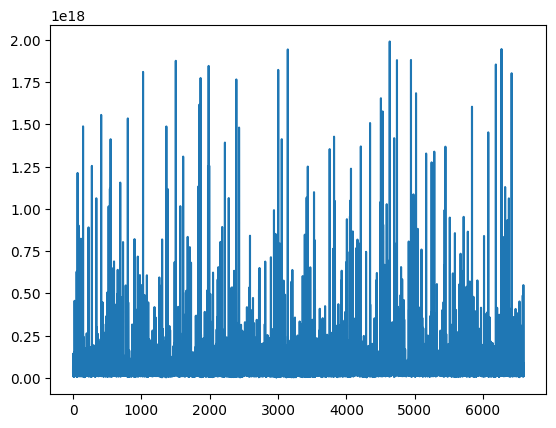

In [53]:
plt.plot(range(len(cond)), cond)
# plt.plot(range(AMat.shape[0]), AMat[:,0,0])
# plt.plot(range(data.shape[1]), data[0,:])

In [54]:
meanwdiag = []
meandiag = []

for file in diaglist:
    #A Matrix Loading of Patient
    # print(file)
    diag = np.load(file)[1:]
    meanwdiag.append(np.mean(diag.flatten()))

diaglen = diag.size - AMat.size

i = 0
while i < numPatients:
    totalA = meanALbad[i]*AMat.size
    totalD = meanwdiag[i]*diag.size
    meandiag.append((totalD - totalA)/diaglen)
    i += 1

In [55]:
##processing entropy
mentro = []
ventro = []


for file in entrolist:
    entropyvalues = pd.read_csv(file)
    entropyvalues = entropyvalues.to_numpy()
    mentro.append(np.mean(entropyvalues))
    ventro.append(np.var(entropyvalues))
    
#0.014433886778617509

##i just realized the mean and var entropy is not of the channels but over the range of the data. otherwise it would just increase

In [56]:
powermeans = []
powerpa = []
powerhc = []


n = 0
for file in powerlist:
# file = powerlist[0]
# if file == powerlist[0]:
    powerrow = []
    powervalues = pd.read_csv(file)
    powervalues = powervalues.to_numpy().transpose()
    for i in powervalues:
        powerrow.append(np.mean(i))
    powermeans.append(np.asarray(powerrow))
    # print(len(powerrow))
    try:
        np.isnan(diseasestates[n])
        powerhc.append(np.asarray(powerrow))
    except TypeError:
        powerpa.append(np.asarray(powerrow))
    n+=1
        

meanofallpowers = np.asarray(powermeans)
powerpa = np.asarray(powerpa)
powerhc = np.asarray(powerhc)


In [57]:
m=0

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\10-20_directory\sub-FMpa01\sub-FMpa01_task-closed_eeg.vhdr


Text(0.5, 1.0, 'Max of A-Matrix')

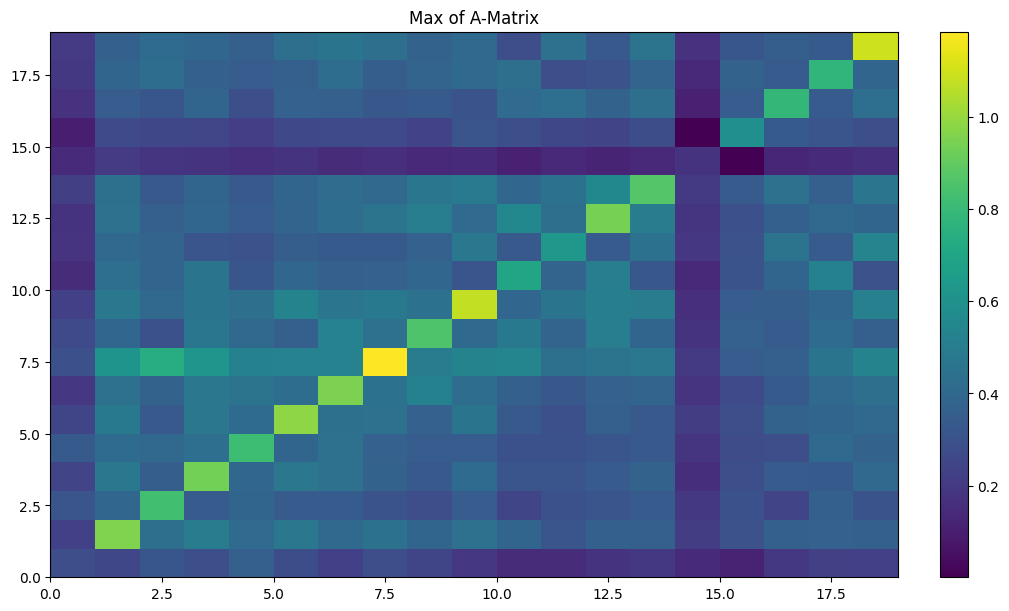

In [58]:
amatrix=np.load(diaglist[m])
print(subdirlist[m])
n = len([cmap])
fig, axs = plt.subplots(1, n, figsize=(n * 2 * 4 + 2, 3 * 2),
                        layout='constrained', squeeze=False)
for [ax, cmap] in zip(axs.flat, [cmap]):
    psm = ax.pcolormesh(np.max(amatrix[1:], axis = 0), cmap=cmap, rasterized=True)
    fig.colorbar(psm, ax=ax)

    # plt.title("correlation between channels")
# amatview += 1
# plt.show()
# m+=1
plt.title("Max of A-Matrix")
# fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "max_amatrix_second_example.png"))

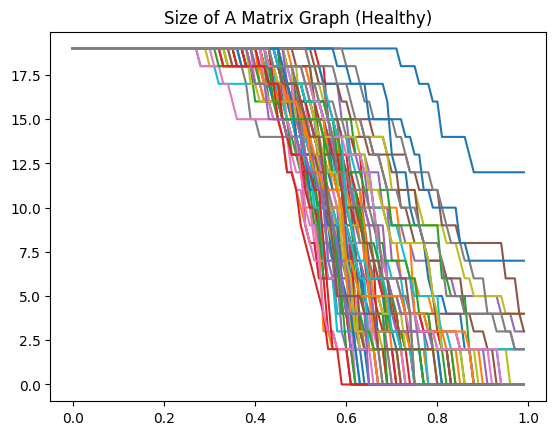

In [59]:
n = 0
for file in diaglist:
    m=0
    amatrix = np.load(file)

    Connectivity = []
    
    while m <= 1:
        A_Connections = nx.Graph()
        Connected_Nodes = []
        
        for i in range(chl):
            for j in range(chl):
                # if ahatswdiag[m, i, j] > 0.3:
                # if np.mean(ahatswdiag[1:, i, j], axis = 0) > 0.1:
                if np.max(amatrix[1:, i, j], axis = 0) > m:
        
                    A_Connections.add_edges_from([(keep_channels[i], keep_channels[j])])
                    if i != j:
                        if keep_channels[i] not in Connected_Nodes:
                            Connected_Nodes.append(keep_channels[i])
                        if keep_channels[j] not in Connected_Nodes:
                            Connected_Nodes.append(keep_channels[j])
        # nx.shell_layout(A_Connections, scale = 1)
        # plt.figure(1,figsize=(10, 10))
        # nx.draw_networkx(A_Connections, arrows=True, **options)
        # plt.title(str(m) + ' ' + str(len(Connected_Nodes)))
        m+=0.01
        # plt.draw()
        Connectivity.append(len(Connected_Nodes))
    try:
        np.isnan(diseasestates[n])
        plt.plot(np.arange(0, 1, 0.01), Connectivity)
        n+=1
    except TypeError:
        # plt.plot(np.arange(0, 1, 0.01), Connectivity)
        # if diseasestates[n] == 'CBP':
            # plt.plot(np.arange(0, 1, 0.01), Connectivity)
        n+=1

plt.title("Size of A Matrix Graph (Healthy)")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "A_Mat_Size_10-20_Healthy" + ".png"))

In [70]:
options = {
    'node_color': 'blue',
    'node_size': 200,
    'font_size': 6,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

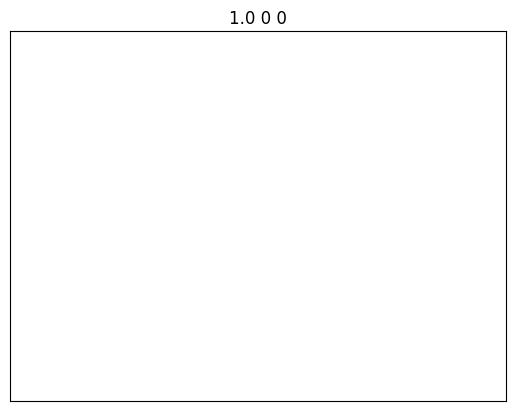

In [61]:
amatrix = np.load(diaglist[0])
m=0
while m < 1.01:
    plt.clf()
    plt.cla()
    A_Connections = nx.Graph()
    Connected_Nodes = []
        
    for i in range(chl):
        for j in range(chl):
            if np.mean(np.abs(amatrix[1:, i, j])) > m:
                A_Connections.add_edges_from([(keep_channels[i], keep_channels[j])])
                if i != j:
                    if keep_channels[i] not in Connected_Nodes:
                        Connected_Nodes.append(keep_channels[i])
                    if keep_channels[j] not in Connected_Nodes:
                        Connected_Nodes.append(keep_channels[j])
                        
    nx.shell_layout(A_Connections, scale = 1)
    plt.figure(1,figsize=(10, 10))
    nx.draw_networkx(A_Connections, arrows=True, **options)

    plt.title(str(np.round(m, 2)) + ' ' + str(len(Connected_Nodes)) + " " + str(len(A_Connections.edges)))
    plt.draw()
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "A-Mat_Connect_Means", str(np.round(m, 2)) + '_' + str(len(Connected_Nodes)) + "_" + str(len(A_Connections.edges)) + ".png"))
    m+=0.01

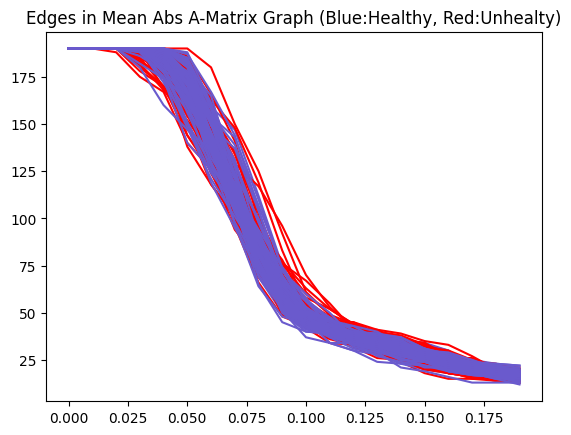

In [62]:
#connections

n = 0
for file in diaglist:
    m=0
    amatrix = np.load(file)
    
    Connectivity = []
    
    # while m < 1.01:
    while m < 0.2:
        A_Connections = nx.Graph()
        Connected_Nodes = []
        
        for i in range(chl):
            for j in range(chl):
                # if ahatswdiag[m, i, j] > 0.3:
                # if np.mean(ahatswdiag[1:, i, j], axis = 0) > 0.1:
                # if np.mean(np.abs(amatrix[1:, i, j]), axis = 0) + np.std(np.abs(amatrix[1:, i, j]), axis = 0) > m:
                if np.mean(np.abs(amatrix[1:, i, j]), axis = 0) > m:
                    A_Connections.add_edges_from([(keep_channels[i], keep_channels[j])])

        m+=0.01
        # plt.draw()
        Connectivity.append(len(A_Connections.edges))
    try:
        np.isnan(diseasestates[n])
        # plt.plot(np.arange(0, 1.01, 0.01), Connectivity, color="slateblue")
        # plt.plot(np.arange(0, 1.01, 0.01), Connectivity)
        # plt.plot(np.arange(0, 0.2, 0.01), Connectivity)
        plt.plot(np.arange(0, 0.2, 0.01), Connectivity, color="slateblue")

        n+=1
    except TypeError:
        # plt.plot(np.arange(0, 1.01, 0.01), Connectivity, color="red")
        # plt.plot(np.arange(0, 1.01, 0.01), Connectivity)
        plt.plot(np.arange(0, 0.2, 0.01), Connectivity, color="red")
        # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            # plt.plot(np.arange(0, 1.01, 0.01), Connectivity)
        # if diseasestates[n] == 'CBP':
        #     plt.plot(np.arange(0, 1.01, 0.01), Connectivity)
        # if diseasestates[n] == 'CWP':
        #     plt.plot(np.arange(0, 1.01, 0.01), Connectivity)
        n+=1

plt.title("Edges in Mean Abs A-Matrix Graph (Blue:Healthy, Red:Unhealty)")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "A_Mat_Graph_Edges_Mean_Compare_Close" + ".png"))

#healthy
#unhealthy
#Neuropathic SMALL
#Widespread
#back COMPLETE

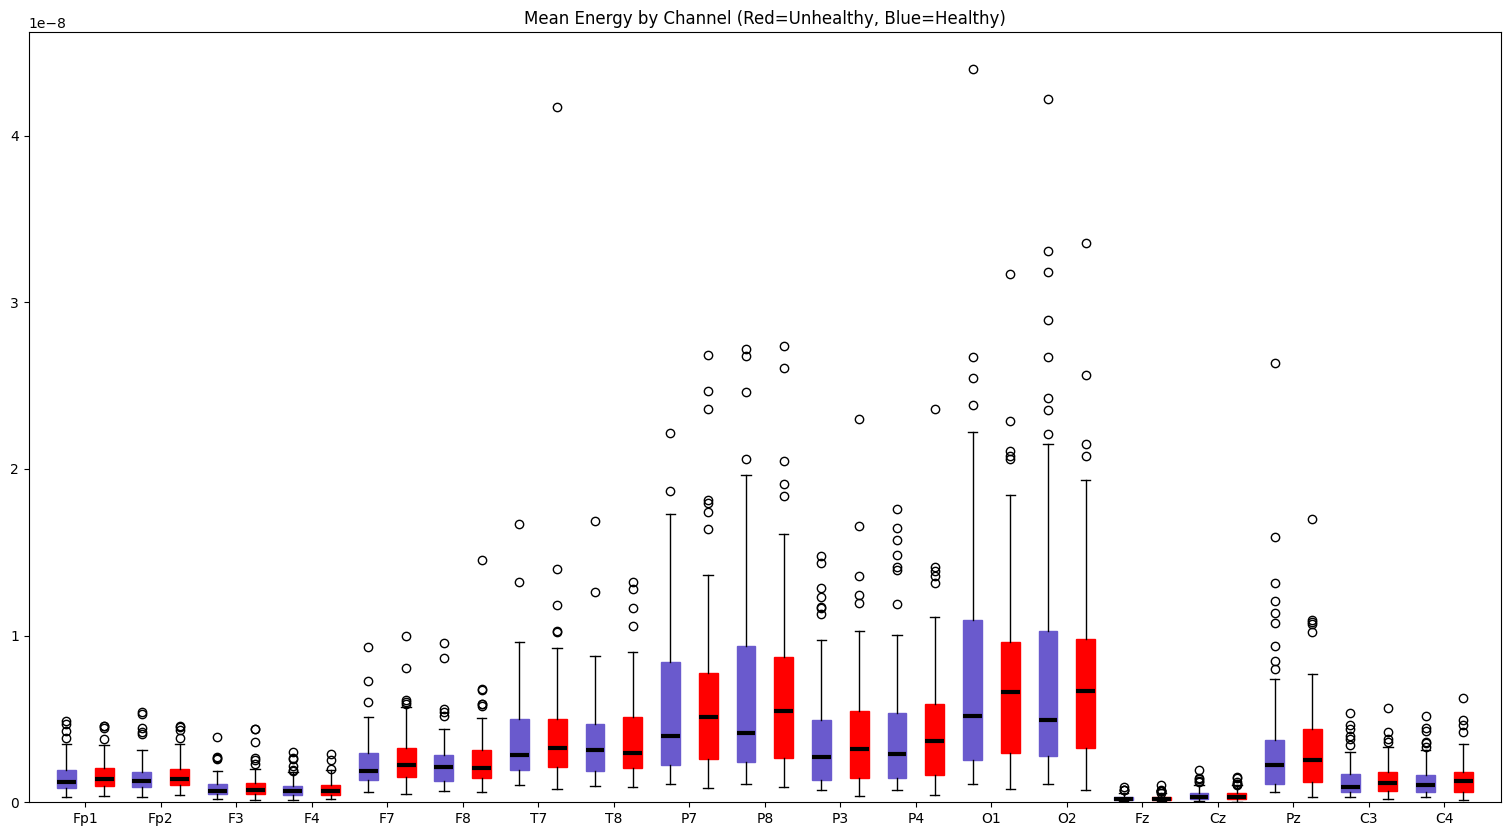

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(chl, 10), squeeze=False)
# ax[0,0].boxplot(meanofallpowers, showfliers=False)
# ax[0,0].set_title("Power by Channel")
# ax[0,0].set_xticks(np.arange(1, chl+1), keep_channels)
# ax[0,0].set_ylim(bottom=0)

# powplot = ax[0,0].boxplot(meanofallpowers, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"))
papos = []

for i in range(0, chl):
    papos.append(i + 0.5)


powplot = ax[0,0].boxplot(powerpa, showfliers=True, patch_artist=True, boxprops=dict(facecolor="red", color="red"), widths=0.25)
powplot1 = ax[0,0].boxplot(powerhc, showfliers=True, patch_artist=True, positions=papos, boxprops=dict(facecolor="slateblue", color="slateblue"), widths=0.25)

ax[0,0].set_title("Mean Energy by Channel (Red=Unhealthy, Blue=Healthy)")
ax[0,0].set_xticks(np.arange(0.75, chl), keep_channels)
ax[0,0].set_ylim(bottom=0)


plt.setp(powplot['medians'], color='black', linewidth=3.0)
plt.setp(powplot1['medians'], color='black', linewidth=3.0)

# n = 0
# for box in powplot['boxes']:
#     if n % 2 != 0:
#         plt.setp(box, color='slateblue')
#     else:
#         plt.setp(box, color='red')
#     n+=1



# plt.setp(powplot['boxes'], color='slateblue')


plt.show()
##had to change number of channels
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "healthyvsunhealthypowers" + ".png"))


In [64]:
print(subdirlist[0])
print(titleString)

C:\Users\Ultimateo\OneDrive\Desktop\ChronicPainPractice\10-20_directory\sub-FMpa01\sub-FMpa01_task-closed_eeg.vhdr
sub-CBPpa02_task-closed_eeg.vhdr


In [65]:
print(powers.shape)

(6666, 19)


In [66]:
powermeans = []
powerpa = []
powerhc = []
n=0
for file in subdirlist:
    dels = []
    powerrow = []
    # keepgfp = np.load(find_files_by_extension(file, "_gfpmaximums.csv.npy")[0])
    powervalues = pd.read_csv(find_files_by_extension(file, 'power_by_channel.csv')[0])
    powervalues = powervalues.to_numpy()
    # for i in range(powervalues.shape[0]):
    #     # if i not in keepgfp:
    #     dels.append(i)
    for i in powervalues.transpose():
        # j = np.delete(i, dels)
        powerrow.append(np.mean(i))
    # powermeans.append(np.asarray(powerrow))
    # print(len(powerrow))
    try:
        np.isnan(diseasestates[n])
        powerhc.append(np.asarray(powerrow))
    except TypeError:
        powerpa.append(np.asarray(powerrow))
    n+=1    

# int(np.trunc(i/125))
#horrible name for my files... i should redo the directory

In [67]:
meanofallpowers = np.asarray(powermeans)
powerpa = np.asarray(powerpa)
powerhc = np.asarray(powerhc)

In [68]:
simeans = []
sipa = []
sihc = []
n=0
for file in subdirlist:
    dels = []
    sirow = []
    keepgfp = np.load(find_files_by_extension(file, "_gfpmaximums.csv.npy")[0])
    for i in range(len(keepgfp)):
        keepgfp[i] = int(np.trunc(keepgfp[i]/125))
    sivalues = pd.read_csv(find_files_by_extension(file, 'sink_indices.csv')[0])
    sivalues = sivalues.to_numpy()
    for i in range(sivalues.shape[0]):
        if i not in keepgfp:
            dels.append(i)
    for i in sivalues.transpose():
        j = np.delete(i, dels)
        sirow.append(np.mean(j))
    simeans.append(np.asarray(sirow))
    # print(len(sirow))
    try:
        np.isnan(diseasestates[n])
        sihc.append(np.asarray(sirow))
    except TypeError:
        sipa.append(np.asarray(sirow))
    n+=1    

# int(np.trunc(i/125))
#horrible name for my files... i should redo the directory

In [69]:
meanofallsis = np.asarray(simeans)
sipa = np.asarray(sipa)
sihc = np.asarray(sihc)

In [70]:
print(sivalues.shape)
print(sipa.shape)
print(sihc.shape)

(6666, 19)
(101, 19)
(88, 19)


In [71]:
simeans = []
sipa = []
sihc = []


n = 0
for file in silist:
# file = silist[0]
# if file == silist[0]:
    sirow = []
    sivalues = pd.read_csv(file)
    sivalues = sivalues.to_numpy().transpose()
    for i in sivalues:
        sirow.append(np.mean(i))
    simeans.append(np.asarray(sirow))
    # print(len(sirow))
    try:
        np.isnan(diseasestates[n])
        sihc.append(np.asarray(sirow))
    except TypeError:
        sipa.append(np.asarray(sirow))
    n+=1
        

meanofallsis = np.asarray(simeans)
sipa = np.asarray(sipa)
sihc = np.asarray(sihc)


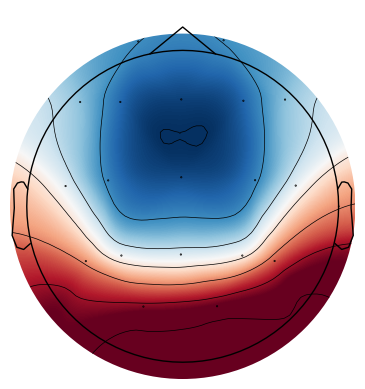

In [72]:
# xypos = np.asarray(pd.read_table(mainfolder + 'Data/eeg/' + titleString1 + '/eeg/' + titleString1 + '_electrodes.tsv'))
# dels = []
# for i in range(xypos.shape[0]):
#     if xypos[i,0] not in keep_channels:
#         dels.append(i)
# xypos = np.delete(xypos, np.asarray(dels), axis = 0)
# xypos = xypos[:,1:3]
# xypos = xypos.astype('float64')

fig, ax = plt.subplots()
mne.viz.plot_topomap(np.mean(powerhc, axis = 0), xypos, size = 2, axes = ax, cmap = 'RdBu_r')
# mne.viz.plot_topomap(np.mean(sihc, axis = 0), xypos, size = 2, axes = ax, vlim = (0, 1), cmap = 'RdBu_r')
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "topomaphealthy_power_10-20" + ".svg"))

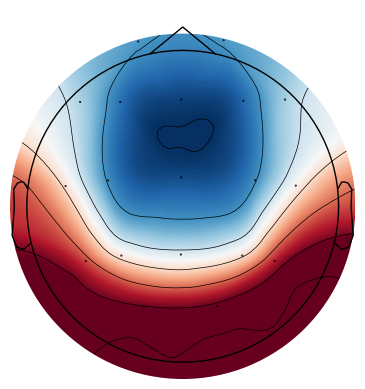

In [73]:
# xypos = np.asarray(pd.read_table(mainfolder + 'Data/eeg/' + titleString1 + '/eeg/' + titleString1 + '_electrodes.tsv'))
# dels = []
# for i in range(xypos.shape[0]):
#     if xypos[i,0] not in keep_channels:
#         dels.append(i)
# xypos = np.delete(xypos, np.asarray(dels), axis = 0)
# xypos = xypos[:,1:3]
# xypos = xypos.astype('float64')

fig, ax = plt.subplots()
mne.viz.plot_topomap(np.mean(powerpa, axis = 0), xypos, size = 2, axes = ax, cmap = 'RdBu_r')
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs","topomapunhealthy_power_10-20" + ".svg"))

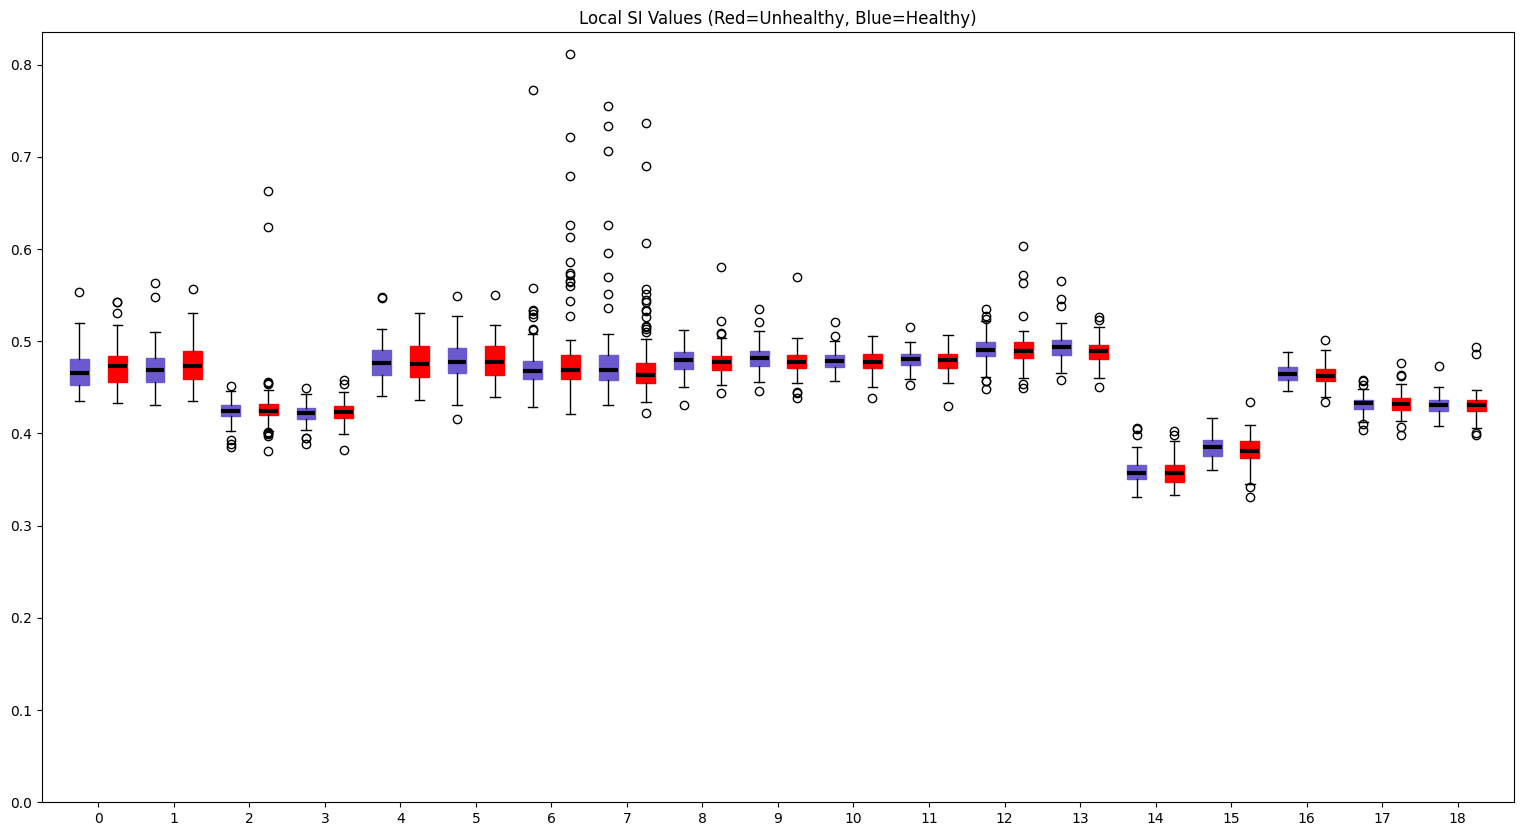

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(chl, 10), squeeze=False)
# ax[0,0].boxplot(meanofallsis, showfliers=False)
# ax[0,0].set_title("si by Channel")
# ax[0,0].set_xticks(np.arange(1, chl+1), keep_channels)
# ax[0,0].set_ylim(bottom=0)

# siplot = ax[0,0].boxplot(meanofallsis, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"))
papos = []

for i in range(0, chl):
    papos.append(i + 0.5)


siplot = ax[0,0].boxplot(sipa, showfliers=True, patch_artist=True, boxprops=dict(facecolor="red", color="red"), widths=0.25)
siplot1 = ax[0,0].boxplot(sihc, showfliers=True, patch_artist=True, positions=papos, boxprops=dict(facecolor="slateblue", color="slateblue"), widths=0.25)

ax[0,0].set_title("Local SI Values (Red=Unhealthy, Blue=Healthy)")
ax[0,0].set_xticks(np.arange(0.75, chl), range(chl))
ax[0,0].set_ylim(bottom=0)


plt.setp(siplot['medians'], color='black', linewidth=3.0)
plt.setp(siplot1['medians'], color='black', linewidth=3.0)

# n = 0
# for box in siplot['boxes']:
#     if n % 2 != 0:
#         plt.setp(box, color='slateblue')
#     else:
#         plt.setp(box, color='red')
#     n+=1



# plt.setp(siplot['boxes'], color='slateblue')


plt.show()
##had to change number of channels
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "healthyvsunhealthysis_1020" + ".png"))


## SVD stuff

In [132]:
n = 0
for file in SVDlist:
# for file in SVDlist[0:10]:
# file = SVDlist[n]
# if file == SVDlist[n]:
    SVDpercent = []
    SVDvalues = pd.read_csv(file)
    SVDvalues = SVDvalues.to_numpy().transpose()
    for i in SVDvalues:
        x = 0
        for j in i:
            if j < 1e-15:
                x += 1
        SVDpercent.append(np.trunc(np.round(x/len(i)*100)))
    # try:
    #     np.isnan(diseasestates[n])
    #     plt.plot(range(33, 62), SVDpercent[33:62], color = "slateblue")
    # except TypeError:
    #     n+=0
    #     plt.plot(range(33, 62), SVDpercent[33:62], color = "red")
    # n+=1
    # try:
    #     np.isnan(diseasestates[n])
    #     plt.plot(SVDpercent, color = "slateblue")
    # except TypeError:
    #     n+=0
    #     plt.plot(SVDpercent, color = "red")
    # n+=1
    # try:
    #     np.isnan(diseasestates[n])
    #     plt.plot(range(25, 50), SVDpercent[25:50], color = "slateblue")
    # except TypeError:
    #     n+=0
    #     plt.plot(range(25, 50), SVDpercent[25:50], color = "red")
    # n+=1

# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "SVD_individual_curves_5e-10" + ".png"))


In [ ]:
print(diseasestates)

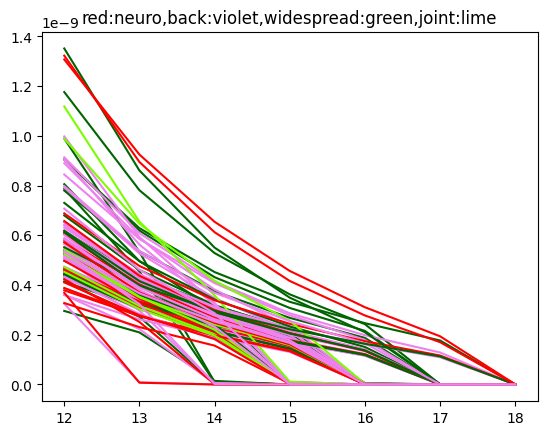

In [138]:
n = 0
for file in SVDlist:
# for file in SVDlist[12:112]:
# file = SVDlist[n]
# if file == SVDlist[n]:
    SVDindimean = []
    SVDvalues = pd.read_csv(file)
    SVDvalues = SVDvalues.to_numpy().transpose()
    for i in SVDvalues:
        SVDindimean.append(np.mean(i))
    # try:
    #     np.isnan(diseasestates[n])
    #     plt.plot(range(12, chl), SVDindimean[12:chl], color = "slateblue")
    # except TypeError:
    #     n+=12
    #     plt.plot(range(12, chl), SVDindimean[12:chl], color = "red")
    # n+=1
    # try:
    #     np.isnan(diseasestates[n])
    #     plt.plot(SVDindimean, color = "slateblue")
    # except TypeError:
    #     n+=12
    #     plt.plot(SVDindimean, color = "red")
    # n+=1
    try:
        np.isnan(diseasestates[n])
        # plt.plot(range(12, chl), SVDindimean[12:chl], color = "slateblue")
        n+=0
    except TypeError:
        n+=0
        # plt.plot(range(12, chl), SVDindimean[12:chl], color = "red")

        if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            plt.plot(range(12, chl), SVDindimean[12:chl], color = "red")
        elif diseasestates[n] == 'CBP':
            plt.plot(range(12, chl), SVDindimean[12:chl], color = "violet")
        elif diseasestates[n] == 'CWP':
            plt.plot(range(12, chl), SVDindimean[12:chl], color = "darkgreen")
        elif diseasestates[n] == 'JP':
            plt.plot(range(12, chl), SVDindimean[12:chl], color = "lawngreen")
        # if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
        #     plt.plot(range(12, chl), SVDindimean[12:chl], color = "red", label="neuropathic")
        # elif diseasestates[n] == 'CBP':
        #     plt.plot(range(12, chl), SVDindimean[12:chl], color = "violet", label="back")
        # elif diseasestates[n] == 'CWP':
        #     plt.plot(range(12, chl), SVDindimean[12:chl], color = "darkgreen", label="widespread")
        # elif diseasestates[n] == 'JP':
        #     plt.plot(range(12, chl), SVDindimean[12:chl], color = "lawngreen", label="joint")


    n+=1
# plt.title('Red:Unhealthy, Blue:Healthy')
plt.title("red:neuro,back:violet,widespread:green,joint:lime")
# plt.

# plt.ylim(top=2e-12)
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "SVD_individual_curves_mean_unhealthytypes_10-20" + ".png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "SVD_individual_curves_mean_compare_10-20" + ".png"))


In [ ]:
n = 0
for file in SVDlist:
# for file in SVDlist[0:10]:
# file = SVDlist[n]
# if file == SVDlist[n]:
    SVDindimean = []
    SVDvalues = pd.read_csv(file)
    SVDvalues = SVDvalues.to_numpy().transpose()
    for i in SVDvalues:
        SVDindimean.append(np.mean(i))
    # try:
    #     np.isnan(diseasestates[n])
    #     plt.plot(range(33, 62), SVDindimean[33:62], color = "slateblue")
    # except TypeError:
    #     n+=0
    #     plt.plot(range(33, 62), SVDindimean[33:62], color = "red")
    # n+=1
    # try:
    #     np.isnan(diseasestates[n])
    #     plt.plot(SVDindimean, color = "slateblue")
    # except TypeError:
    #     n+=0
    #     plt.plot(SVDindimean, color = "red")
    # n+=1
    try:
        np.isnan(diseasestates[n])
        plt.plot(range(35, 58), SVDindimean[35:58], color = "slateblue")
        n+=0
    except TypeError:
        if diseasestates[n] == 'CBP':
            plt.plot(range(35, 58), SVDindimean[35:58], color = "red")

    n+=1
plt.title('Red:Back, Blue:Healthy')


# plt.ylim(top=3e-10)
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "SVD_Curves_CBPvsHC" + ".png"))


In [ ]:
print(meanofallSVDs.shape)

In [139]:
SVDmeans = []
SVDpa = []
SVDhc = []
SVDnp = []
SVDcbp = []
SVDcwp = []
SVDjp = []

n = 0
for file in SVDlist:
# file = SVDlist[0]
# if file == SVDlist[0]:
    SVDrow = []
    SVDvalues = pd.read_csv(file)
    SVDvalues = SVDvalues.to_numpy().transpose()
    for i in SVDvalues:
        SVDrow.append(np.mean(i))
    SVDmeans.append(np.asarray(SVDrow))
    # print(len(SVDrow))
    try:
        np.isnan(diseasestates[n])
        SVDhc.append(np.asarray(SVDrow))
    except TypeError:
        SVDpa.append(np.asarray(SVDrow))
        if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            SVDnp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'CBP':
            SVDcbp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'CWP':
            SVDcwp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'JP':
            SVDjp.append(np.asarray(SVDrow))
    n+=1
    # except TypeError:
    #     if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
    #         SVDnp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'CBP':
    #         SVDcbp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'CWP':
    #         SVDcwp.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'JP':
    #         SVDjp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    # n+=1

meanofallSVDs = np.asarray(SVDmeans)
SVDpa = np.asarray(SVDpa)
SVDhc = np.asarray(SVDhc)
SVDnp = np.asarray(SVDnp)
SVDcbp = np.asarray(SVDcbp)
SVDcwp = np.asarray(SVDcwp)
SVDjp = np.asarray(SVDjp)

In [140]:
print(meanofallSVDs.shape)

(189, 19)


In [141]:
nonzeros = []
for i in meanofallSVDs.transpose():
    n=189
    for j in i:
        if j < 1e-15:
            n-=1
    nonzeros.append(n)

In [60]:
dSVDcbp = np.zeros((47,61), dtype=float)
dSVDhc = np.zeros((88, 61), dtype=float)
for i in range(61):
    dSVDcbp[:,i]=SVDcbp[:,i]-SVDcbp[:,i+1]
    dSVDhc[:,i]=SVDhc[:,i]-SVDhc[:,i+1]


dcbpmax = []
dhcmax = []
for i in range(dSVDcbp.shape[0]):
    # plt.plot(i, color="red")
    for j in range(dSVDcbp.shape[1])[39:]:
        if dSVDcbp[i, j] == max(dSVDcbp[i,39:]):
            # if max(dSVDcbp[i,39:])/np.mean(meanofallSVDs[:,j]) < 5:
            dcbpmax.append(max(dSVDcbp[i,39:])/(np.sum(meanofallSVDs[:,j])/nonzeros[j]))

for i in range(dSVDhc.shape[0]):
    # plt.plot(i, color="red")
    for j in range(dSVDhc.shape[1])[39:]:
        if dSVDhc[i, j] == max(dSVDhc[i, 39:]):
            # if max(dSVDhc[i,39:])/np.mean(meanofallSVDs[:,j]) < 5:
            dhcmax.append(max(dSVDhc[i,39:])/(np.sum(meanofallSVDs[:,j])/nonzeros[j]))

dcbpmax = np.array(dcbpmax)
dhcmax = np.array(dhcmax)
    
plt.hist(dcbpmax, bins = 30, color="red", alpha=0.5)
plt.hist(dhcmax, bins = 100, color="slateblue", alpha=0.5)
plt.savefig("weirdmetrichist")

NameError: name 'SVDcbp' is not defined

In [61]:
print(np.median(dcbpmax))
print(np.median(dhcmax))
print(np.std(dcbpmax))
print(np.std(dhcmax))
print(np.mean(dcbpmax))
print(np.mean(dhcmax))

NameError: name 'dcbpmax' is not defined

In [62]:

plt.boxplot((dcbpmax, dhcmax), showfliers=False, tick_labels = ("back", "healthy"))
plt.title("magnitude of last non-zero singular value divided by mean of nonzero singular values")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "weirdmetric" + ".png"))

NameError: name 'dcbpmax' is not defined

In [63]:
print(dSVDcbp.shape)

(47, 61)


In [64]:
print(dcbpmax)
print(dhcmax)

NameError: name 'dcbpmax' is not defined

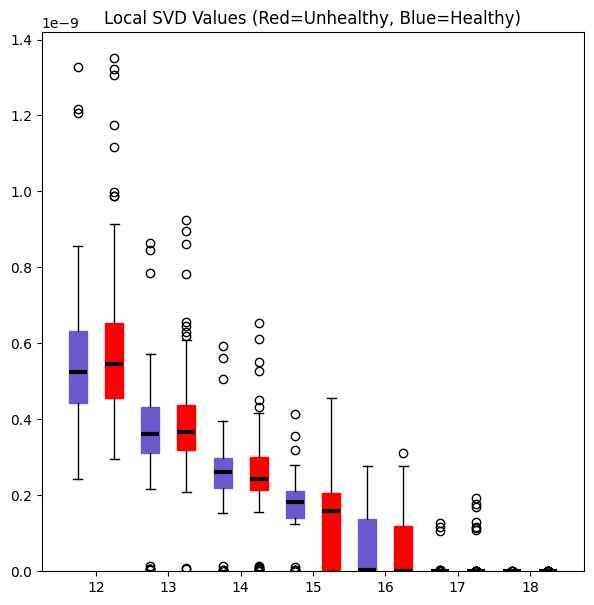

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), squeeze=False)
# ax[0,0].boxplot(meanofallSVDs, showfliers=False)
# ax[0,0].set_title("SVD by Channel")
# ax[0,0].set_xticks(np.arange(1, chl+1), keep_channels)
# ax[0,0].set_ylim(bottom=0)

# SVDplot = ax[0,0].boxplot(meanofallSVDs, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"))
papos = []

for i in range(chl-12):
    papos.append(i + 0.5)


SVDplot = ax[0,0].boxplot(SVDpa[:,12:], showfliers=True, patch_artist=True, boxprops=dict(facecolor="red", color="red"), widths=0.25)
SVDplot1 = ax[0,0].boxplot(SVDhc[:,12:], showfliers=True, patch_artist=True, positions=papos, boxprops=dict(facecolor="slateblue", color="slateblue"), widths=0.25)

ax[0,0].set_title("Local SVD Values (Red=Unhealthy, Blue=Healthy)")
ax[0,0].set_xticks(np.arange(0.75, chl-12), range(12,chl))
ax[0,0].set_ylim(bottom=0)


plt.setp(SVDplot['medians'], color='black', linewidth=3.0)
plt.setp(SVDplot1['medians'], color='black', linewidth=3.0)

# n = 0
# for box in SVDplot['boxes']:
#     if n % 2 != 0:
#         plt.setp(box, color='slateblue')
#     else:
#         plt.setp(box, color='red')
#     n+=1



# plt.setp(SVDplot['boxes'], color='slateblue')


plt.show()
##had to change number of channels
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "healthyvsunhealthySVDs(smaller)_10-20" + ".png"))


In [66]:
print(SVDpa.shape)

NameError: name 'SVDpa' is not defined

In [67]:
dSVDmeans = np.zeros((189, 61))

for i in range(dSVDmeans.shape[1]):
    dSVDmeans[:,i] = meanofallSVDs[:,i] - meanofallSVDs[:,i+1]

NameError: name 'meanofallSVDs' is not defined

In [68]:
SVDpa = []
SVDhc = []
SVDnp = []
SVDcbp = []
SVDcwp = []
SVDjp = []

n = 0
for file in SVDlist:

    SVDrow = dSVDmeans[n]
    
    try:
        np.isnan(diseasestates[n])
        SVDhc.append(np.asarray(SVDrow))
    except TypeError:
        SVDpa.append(np.asarray(SVDrow))
        if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            SVDnp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'CBP':
            SVDcbp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'CWP':
            SVDcwp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'JP':
            SVDjp.append(np.asarray(SVDrow))
    n+=1
    # except TypeError:
    #     if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
    #         SVDnp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'CBP':
    #         SVDcbp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'CWP':
    #         SVDcwp.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'JP':
    #         SVDjp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    # n+=1

dSVDpa = np.asarray(SVDpa)
dSVDhc = np.asarray(SVDhc)
dSVDnp = np.asarray(SVDnp)
dSVDcbp = np.asarray(SVDcbp)
dSVDcwp = np.asarray(SVDcwp)
dSVDjp = np.asarray(SVDjp)

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(chl-20-25, 15), squeeze=False)
# ax[0,0].boxplot(meanofalldSVDs, showfliers=False)
# ax[0,0].set_title("dSVD by Channel")
# ax[0,0].set_xticks(np.arange(1, chl+1), keep_channels)
# ax[0,0].set_ylim(bottom=0)

# dSVDplot = ax[0,0].boxplot(meanofalldSVDs, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"))
papos = []

for i in range(chl-26-1):
    papos.append(i + 0.5)


dSVDplot = ax[0,0].boxplot(dSVDcbp[:,26:], showfliers=True, patch_artist=True, boxprops=dict(facecolor="red", color="red"), widths=0.25)
dSVDplot1 = ax[0,0].boxplot(dSVDhc[:,26:], showfliers=True, patch_artist=True, positions=papos, boxprops=dict(facecolor="slateblue", color="slateblue"), widths=0.25)

ax[0,0].set_title("Derivative of SVDs (Red=Unhealthy, Blue=Healthy)")
ax[0,0].set_xticks(np.arange(0.75, chl-26-1), range(26,chl-1))
ax[0,0].set_ylim(bottom=0)


plt.setp(dSVDplot['medians'], color='black', linewidth=3.0)
plt.setp(dSVDplot1['medians'], color='black', linewidth=3.0)

# n = 0
# for box in dSVDplot['boxes']:
#     if n % 2 != 0:
#         plt.setp(box, color='slateblue')
#     else:
#         plt.setp(box, color='red')
#     n+=1



# plt.setp(dSVDplot['boxes'], color='slateblue')


plt.show()
##had to change number of channels
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "derivative_healthyvsunhealthydSVDs(smaller)" + ".png"))

ValueError: figure size must be positive finite not (-26, 15)

In [68]:
ddSVDmeans = np.zeros((189, 60))

for i in range(ddSVDmeans.shape[1]):
    ddSVDmeans[:,i] = dSVDmeans[:,i] - dSVDmeans[:,i+1]

In [69]:
SVDpa = []
SVDhc = []
SVDnp = []
SVDcbp = []
SVDcwp = []
SVDjp = []

n = 0
for file in SVDlist:

    SVDrow = ddSVDmeans[n]
    
    try:
        np.isnan(diseasestates[n])
        SVDhc.append(np.asarray(SVDrow))
    except TypeError:
        SVDpa.append(np.asarray(SVDrow))
        if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
            SVDnp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'CBP':
            SVDcbp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'CWP':
            SVDcwp.append(np.asarray(SVDrow))
        elif diseasestates[n] == 'JP':
            SVDjp.append(np.asarray(SVDrow))
    n+=1
    # except TypeError:
    #     if diseasestates[n] == 'PNP' or diseasestates[n] == 'PHN' or diseasestates[n] == 'NP':
    #         SVDnp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'CBP':
    #         SVDcbp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'CWP':
    #         SVDcwp.append(np.asarray(SVDrow))
    #     elif diseasestates[n] == 'JP':
    #         SVDjp.append(np.asarray(SVDrow))
    #         SVDpa.append(np.asarray(SVDrow))
    # n+=1

ddSVDpa = np.asarray(SVDpa)
ddSVDhc = np.asarray(SVDhc)
ddSVDnp = np.asarray(SVDnp)
ddSVDcbp = np.asarray(SVDcbp)
ddSVDcwp = np.asarray(SVDcwp)
ddSVDjp = np.asarray(SVDjp)

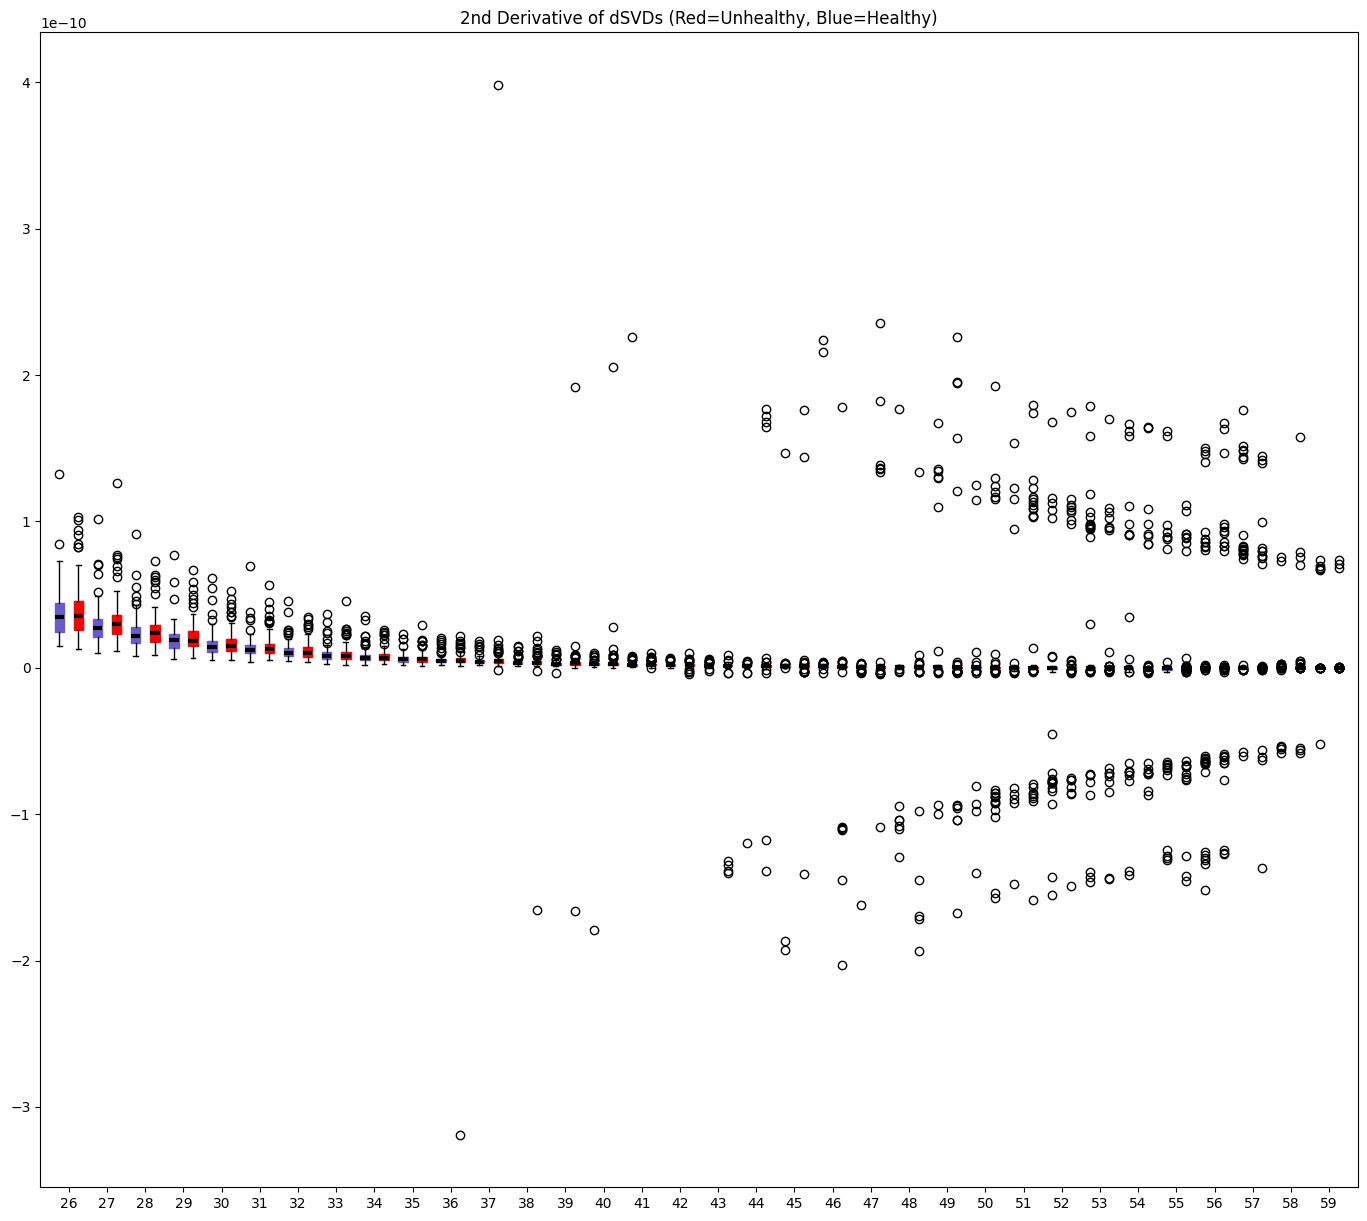

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(chl-20-25, 15), squeeze=False)
# ax[0,0].boxplot(meanofallddSVDs, showfliers=False)
# ax[0,0].set_title("ddSVD by Channel")
# ax[0,0].set_xticks(np.arange(1, chl+1), keep_channels)
# ax[0,0].set_ylim(bottom=0)

# ddSVDplot = ax[0,0].boxplot(meanofallddSVDs, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"))
papos = []

for i in range(chl-26-2):
    papos.append(i + 0.5)


ddSVDplot = ax[0,0].boxplot(ddSVDpa[:,26:], showfliers=True, patch_artist=True, boxprops=dict(facecolor="red", color="red"), widths=0.25)
ddSVDplot1 = ax[0,0].boxplot(ddSVDhc[:,26:], showfliers=True, patch_artist=True, positions=papos, boxprops=dict(facecolor="slateblue", color="slateblue"), widths=0.25)

ax[0,0].set_title("2nd Derivative of dSVDs (Red=Unhealthy, Blue=Healthy)")
ax[0,0].set_xticks(np.arange(0.75, chl-26-2), range(26,chl-2))
# ax[0,0].set_ylim(bottom=0)


plt.setp(ddSVDplot['medians'], color='black', linewidth=3.0)
plt.setp(ddSVDplot1['medians'], color='black', linewidth=3.0)

# n = 0
# for box in ddSVDplot['boxes']:
#     if n % 2 != 0:
#         plt.setp(box, color='slateblue')
#     else:
#         plt.setp(box, color='red')
#     n+=1



# plt.setp(ddSVDplot['boxes'], color='slateblue')


plt.show()
##had to change number of channels
# fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "2derivative_healthyvsunhealthyddSVDs(smaller)" + ".png"))

In [73]:
tsvd = []
psvd = []

for i in range(chl):
    t, p = stats.ttest_ind_from_stats(np.mean(SVDpa[:,i]), np.std(SVDpa[:,i]), 101, np.mean(SVDhc[:,i]), np.std(SVDhc[:,i]), 88)
    tsvd.append(t)
    psvd.append(p)

In [78]:
print(SVDcbp.shape)

(47, 62)


In [145]:
tsvd = []
psvd = []

for i in range(chl):
    t, p = stats.ttest_ind_from_stats(np.mean(SVDcbp[:,i]), np.std(SVDcbp[:,i]), 47, np.mean(SVDhc[:,i]), np.std(SVDhc[:,i]), 88)
    tsvd.append(t)
    psvd.append(p)

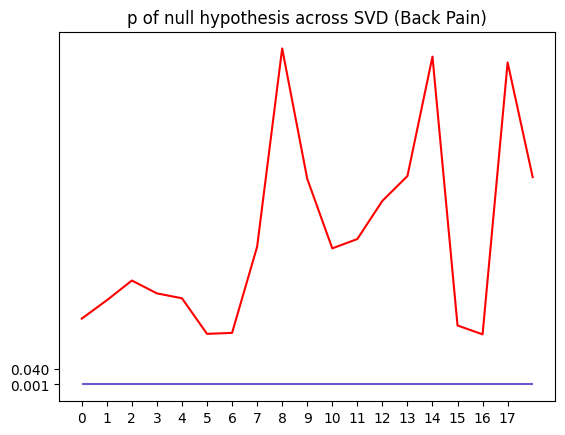

In [149]:
# plt.plot(tsvd, color = "slateblue")
# plt.plot(psvd[40:58], color = "red")
plt.plot(psvd, color = "red")
# plt.hlines([0.05,0.1], 0, 20, color = "slateblue")
plt.hlines([0.001], 0, 18, color = "slateblue")
plt.title("p of null hypothesis across SVD (Back Pain)")
# plt.yticks(ticks=[0, 0.05,0.1, 1])
plt.yticks(ticks=[0.001, 0.04])
# plt.xticks(range(18), range(40,58))
plt.xticks(range(18), range(0,18))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "zoom_cbp_p_SVD_10-20" + ".png"))


In [58]:
eigenmeans = []
eigenpa = []
eigenhc = []


n = 0
for file in eigenlist:
# file = eigenlist[0]
# if file == eigenlist[0]:
    eigenrow = []
    eigenvalues = pd.read_csv(file)
    eigenvalues = eigenvalues.to_numpy().transpose()
    for i in eigenvalues:
        eigencol=[]
        for j in i:
            eigencol.append(complex(j).real)
        eigenrow.append(np.mean(eigencol))
    eigenmeans.append(np.asarray(np.mean(eigenrow)))
    # print(len(eigenrow))
    try:
        np.isnan(diseasestates[n])
        eigenhc.append(np.asarray(eigenrow))
    except TypeError:
        eigenpa.append(np.asarray(eigenrow))
    n+=1
        

meanofalleigens = np.asarray(eigenmeans)
eigenpa = np.asarray(eigenpa)
eigenhc = np.asarray(eigenhc)
# for idx in evals:
#     real = [ele.real for ele in idx]
#     imag = [ele.imag for ele in idx]
#     reals.append(real)
#     imags.append(imag)

# reals = np.asarray(reals)
# imags = np.asarray(imags)

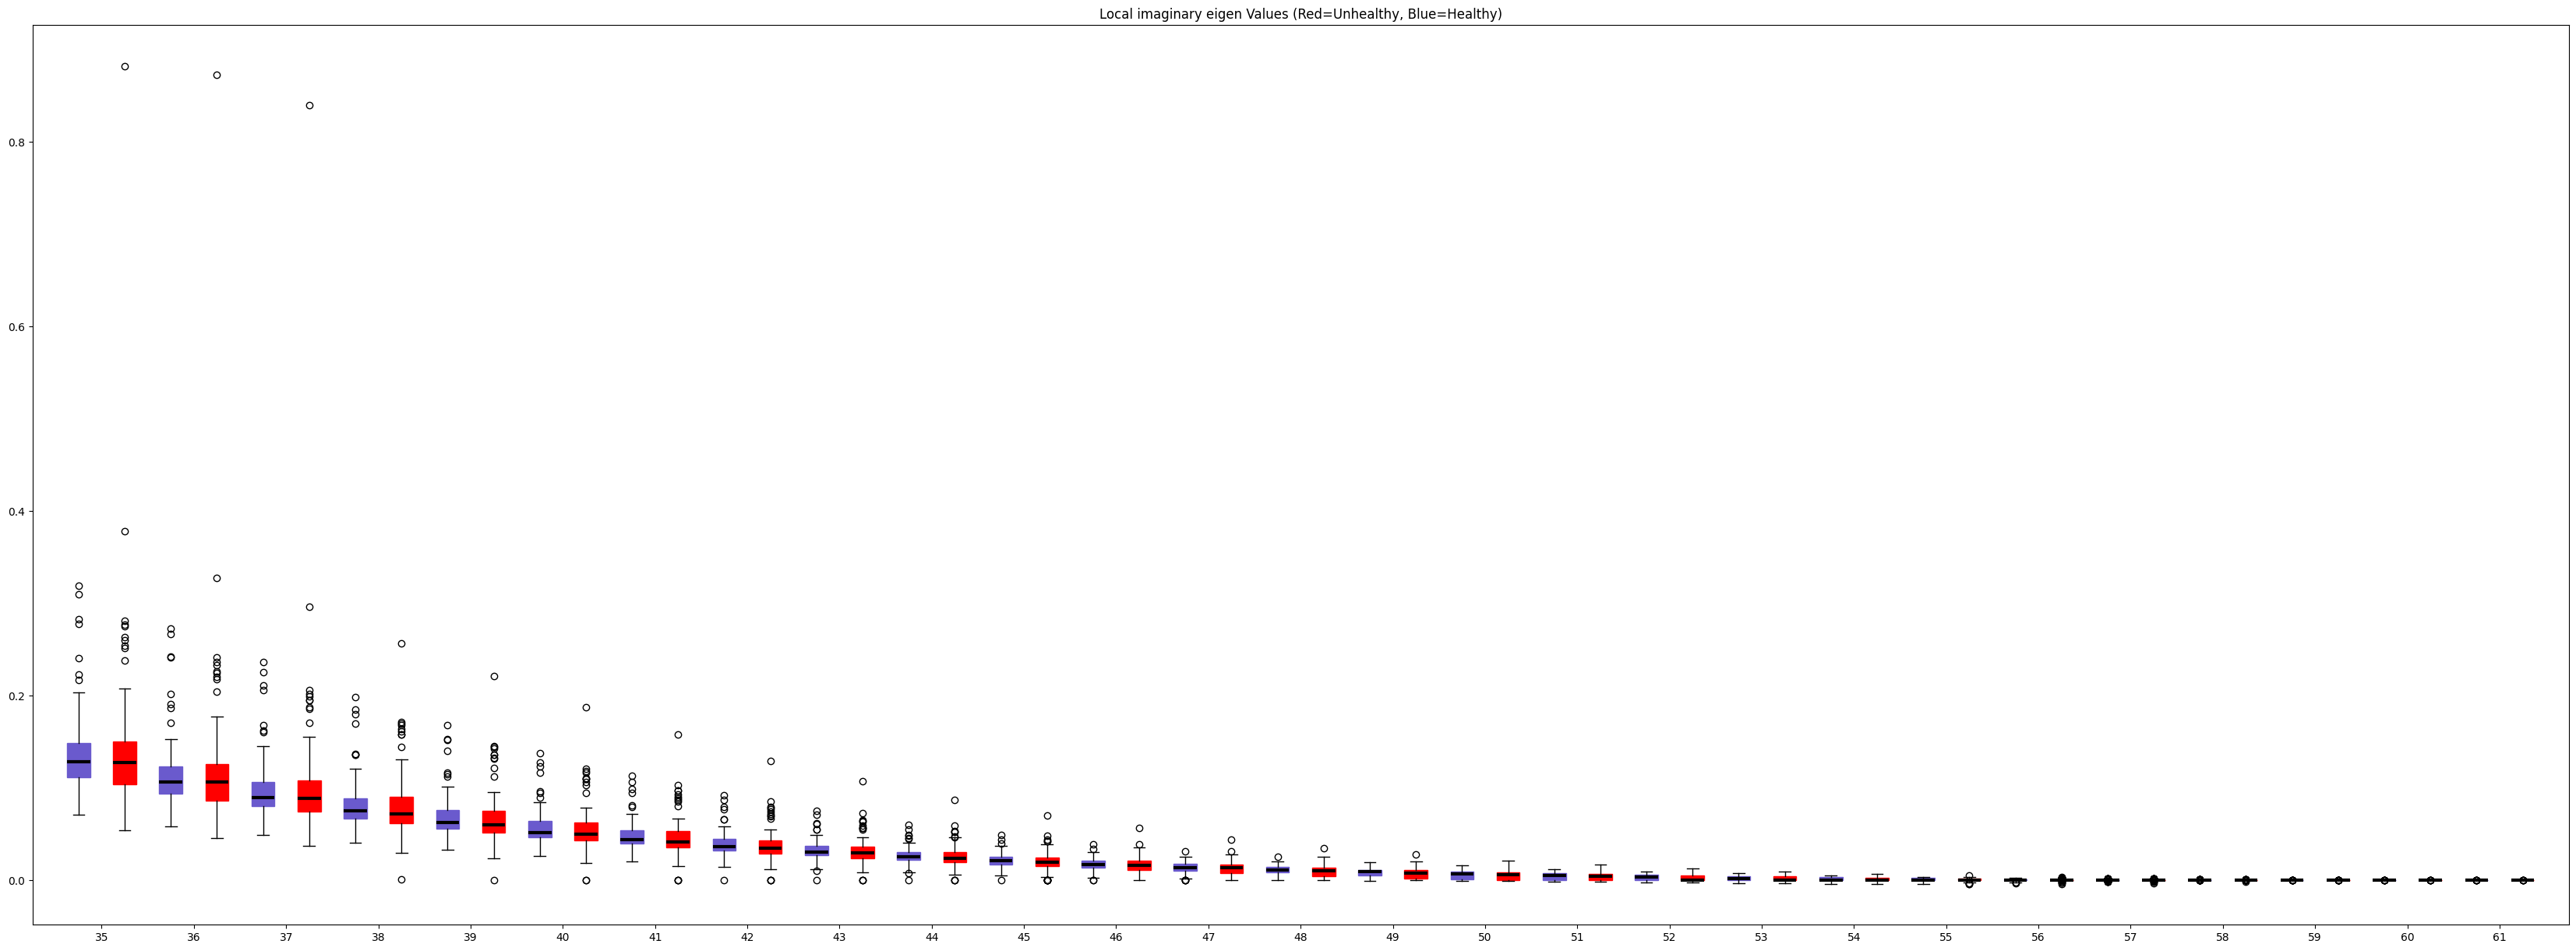

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(chl, 10), squeeze=False)
# ax[0,0].boxplot(meanofalleigens, showfliers=False)
# ax[0,0].set_title("eigen by Channel")
# ax[0,0].set_xticks(np.arange(1, chl+1), keep_channels)
# ax[0,0].set_ylim(bottom=0)

# eigenplot = ax[0,0].boxplot(meanofalleigens, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"))
papos = []

for i in range(chl-35):
    papos.append(i + 0.5)


eigenplot = ax[0,0].boxplot(eigenpa[:,35:], showfliers=True, patch_artist=True, boxprops=dict(facecolor="red", color="red"), widths=0.25)
eigenplot1 = ax[0,0].boxplot(eigenhc[:,35:], showfliers=True, patch_artist=True, positions=papos, boxprops=dict(facecolor="slateblue", color="slateblue"), widths=0.25)

ax[0,0].set_title("Local imaginary eigen Values (Red=Unhealthy, Blue=Healthy)")
ax[0,0].set_xticks(np.arange(0.75, chl-35), range(35,chl))



plt.setp(eigenplot['medians'], color='black', linewidth=3.0)
plt.setp(eigenplot1['medians'], color='black', linewidth=3.0)

# n = 0
# for box in eigenplot['boxes']:
#     if n % 2 != 0:
#         plt.setp(box, color='slateblue')
#     else:
#         plt.setp(box, color='red')
#     n+=1



# plt.setp(eigenplot['boxes'], color='slateblue')


plt.show()
##had to change number of channels
# fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "healthyvsunhealthyeigensimag" + ".png"))


In [60]:
n=0
value=50
for i in SVDhc[:,value]:
    if i < 1e-12:
        # print(i)
        n+=1
print(str(n) + ' ' + str(n/88))
n=0
for i in SVDpa[:,value]:
    if i < 1e-12:
        # print(i)
        n+=1
print(str(n) + ' ' + str(n/101))


8 0.09090909090909091
17 0.16831683168316833


In [61]:
hcpercents1 = []
for i in SVDhc.transpose():
    n=0
    for j in i:
        if j < 9e-11:
            n+=1
    hcpercents1.append(np.trunc(np.round(n/88*100)))

papercents1 = []
for i in SVDpa.transpose():
    n=0
    for j in i:
        if j < 9e-11:
            n+=1
    papercents1.append(np.trunc(np.round(n/101*100)))

In [62]:
hcpercents2 = []
for i in SVDhc.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    hcpercents2.append(np.trunc(np.round(n/88*100)))

papercents2 = []
for i in SVDpa.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    papercents2.append(np.trunc(np.round(n/101*100)))

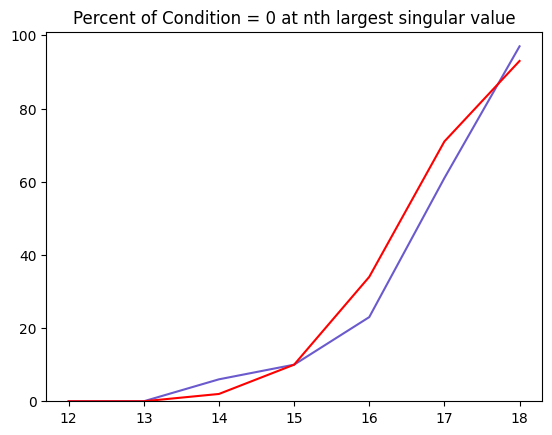

In [150]:
hcpercents = []
for i in SVDhc.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    hcpercents.append(np.trunc(np.round(n/88*100)))

cbppercents = []
for i in SVDpa.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    cbppercents.append(np.trunc(np.round(n/101*100)))


# plt.plot(range(12, chl), hcpercents[12:chl], color="slateblue")
# plt.plot(range(12, chl), papercents[12:chl], color="red")

# plt.plot(range(12, chl), hcpercents1[12:chl], color="slateblue")
# plt.plot(range(12, chl), papercents1[12:chl], color="red")

plt.plot(range(12, chl), hcpercents[12:chl], color="slateblue")
plt.plot(range(12, chl), cbppercents[12:chl], color="red")

plt.ylim(bottom=0, top=101)
# plt.xlim(right=61)

plt.title("Percent of Condition = 0 at nth largest singular value")

plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "SVDpercentplotpa_e-15_10-20" + ".png"))

In [264]:
print(meanofallSVDs.shape)

(189, 62)


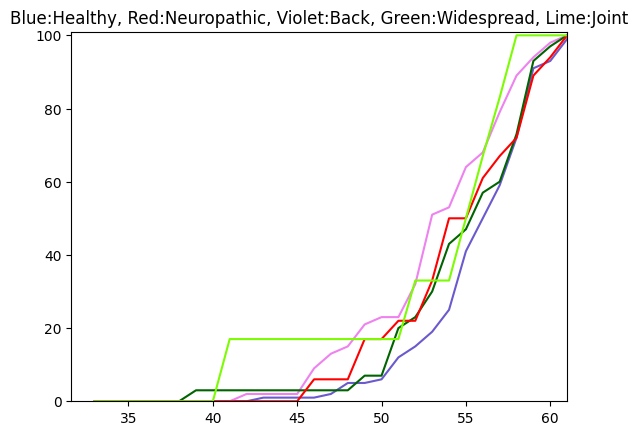

In [64]:
hcpercents = []
for i in SVDhc.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    hcpercents.append(np.trunc(np.round(n/88*100)))

cbppercents = []
for i in SVDcbp.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    cbppercents.append(np.trunc(np.round(n/47*100)))

cwppercents = []
for i in SVDcwp.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    cwppercents.append(np.trunc(np.round(n/30*100)))

nppercents = []
for i in SVDnp.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    nppercents.append(np.trunc(np.round(n/18*100)))

jppercents = []
for i in SVDjp.transpose():
    n=0
    for j in i:
        if j < 1e-15:
            n+=1
    jppercents.append(np.trunc(np.round(n/6*100)))



# plt.plot(range(33, 62), hcpercents[33:62], color="slateblue")
# plt.plot(range(33, 62), papercents[33:62], color="red")

# plt.plot(range(33, 62), hcpercents1[33:62], color="slateblue")
# plt.plot(range(33, 62), papercents1[33:62], color="red")

plt.plot(range(33, 62), hcpercents[33:62], color="slateblue")
plt.plot(range(33, 62), cbppercents[33:62], color="violet")
plt.plot(range(33, 62), cwppercents[33:62], color="darkgreen")
plt.plot(range(33, 62), nppercents[33:62], color="red")
plt.plot(range(33, 62), jppercents[33:62], color="lawngreen")




plt.ylim(bottom=0, top=101)
plt.xlim(right=61)
plt.title('Blue:Healthy, Red:Neuropathic, Violet:Back, Green:Widespread, Lime:Joint')

plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "SVDpercentplotconditions" + ".png"))

C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_11928\1310123828.py:5: RuntimeWarning: invalid value encountered in scalar divide
  percentdif.append(papercents[i]/hcpercents[i])
C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_11928\1310123828.py:6: RuntimeWarning: invalid value encountered in scalar divide
  percentdif2.append(papercents2[i]/hcpercents2[i])
C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_11928\1310123828.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  percentdif.append(papercents[i]/hcpercents[i])
C:\Users\Ultimateo\AppData\Local\Temp\ipykernel_11928\1310123828.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  percentdif2.append(papercents2[i]/hcpercents2[i])


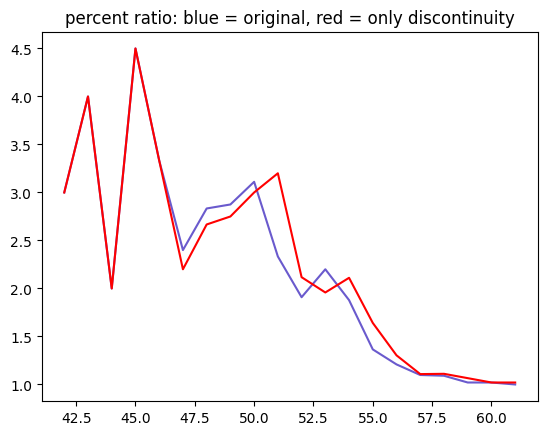

In [183]:
percentdif = []
percentdif2 = []

for i in range(chl):
    percentdif.append(papercents[i]-hcpercents[i])
    percentdif2.append(papercents2[i]-hcpercents2[i])


plt.plot(range(33, 62), percentdif[33:62], color="slateblue")
plt.plot(range(33, 62), percentdif2[33:62], color="red")

plt.title("percent ratio: blue = original, red = only discontinuity")

# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "SVDpercentratioplot" + ".png"))

## Processing Data

In [45]:
r2 = []
allr = []

for file in r2list:
    r2values = pd.read_csv(file)
    r2values = r2values.to_numpy()[:,0]
    r2.append(np.mean(r2values))
    for i in r2values:
        allr.append(i)

allr = np.asarray(allr)


In [76]:
allr2 = []
for i in allr:
    if i > 0.99995:
        allr2.append(i)
allr = np.asarray(allr2)



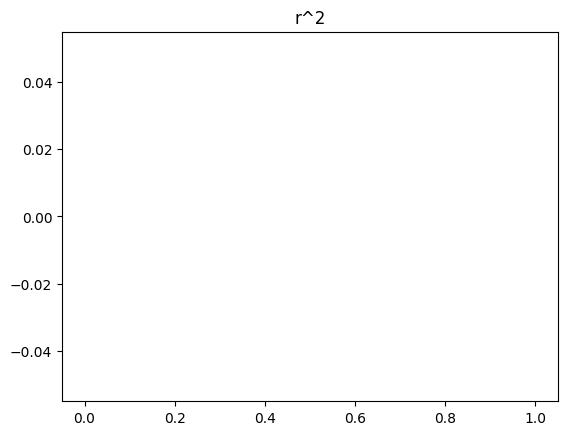

In [77]:
plt.hist(allr, bins = 200)
plt.title("r^2")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "rhist" + ".png"))


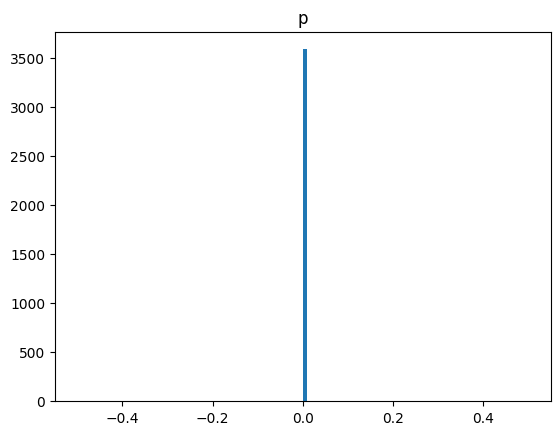

In [78]:
prob = []
allp = []

for file in plist:
    pvalues = pd.read_csv(file)
    pvalues = pvalues.to_numpy()[:,0]
    prob.append(np.mean(pvalues))
    for i in pvalues:
        allp.append(i)

allp = np.asarray(allp)

plt.hist(allp, bins = 100)
plt.title("p")
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "phist" + ".png"))
# print(pvalues)


In [79]:
##Processing sink indices
##just set up rinas a matrix loop to do sink indexes instead
statSI_J = []
pvalSI_J = []
statSI_K = []
pvalSI_K = []
meanSI = []
varSI = []

for file in silist:
    #A Matrix Loading of Patient
    SI = pd.read_csv(file)
    SI = SI.to_numpy()
    
    #normality test on A & SI
    #1. Jarque Bera - Statstic = about 0 and pvalue for the following hypotheses (H0 - Normally Distributed, Ha - Not Normally Distributed)
    statSI, pvalSI = stats.jarque_bera(SI.flatten())
    statSI_J.append(statSI)
    pvalSI_J.append(pvalSI)

    #2 Kolmogorov Smirnov - Statstic = about 0 and pvalue for the following hypotheses (H0 - Normally Distributed, Ha - Not Normally Distributed)
    statSI, pvalSI = stats.kstest(SI.flatten(), stats.norm.cdf, N = numPatients)
    statSI_K.append(statSI)
    pvalSI_K.append(pvalSI)

    #mean and std of A & SI
    meanSI.append(np.average(SI.flatten()))
    varSI.append(np.var(SI.flatten()))

In [80]:
channeli = str()
for i in range(chl):
    stri = str(i)
    channeli = channeli + "Pow["+stri+"], "


print(channeli)

Pow[0], Pow[1], Pow[2], Pow[3], Pow[4], Pow[5], Pow[6], Pow[7], Pow[8], Pow[9], Pow[10], Pow[11], Pow[12], Pow[13], Pow[14], Pow[15], Pow[16], Pow[17], Pow[18], 


In [81]:
##power values / trying kruskal wallis
krusp = []
kruss = []

for file in powerslist:
    Pow = pd.read_csv(file)
    Pow = Pow.to_numpy()

    # Powl = []
    # i = 0
    # while i < Pow.shape[0]:
    #     Powl.append(Pow[i])
    #     i+=i
    
    #doesnt work with a list of arrays so I can either write a function that does this myself or just list them out manually
    s, p = stats.kruskal(Pow[0], Pow[1], Pow[2], Pow[3], Pow[4], Pow[5], Pow[6], Pow[7], Pow[8], Pow[9], Pow[10], Pow[11], Pow[12], Pow[13], Pow[14], Pow[15], Pow[16], Pow[17], Pow[18])
                         # , Pow[19], Pow[20], Pow[21], Pow[22], Pow[23], Pow[24], Pow[25], Pow[26], Pow[27], Pow[28], Pow[29], Pow[30], Pow[31], Pow[32], Pow[33], Pow[34], Pow[35], Pow[36], Pow[37], Pow[38], Pow[39], Pow[40], Pow[41], Pow[42], Pow[43], Pow[44], Pow[45], Pow[46], Pow[47], Pow[48], Pow[49], Pow[50], Pow[51], Pow[52], Pow[53], Pow[54], Pow[55], Pow[56], Pow[57], Pow[58], Pow[59], Pow[60], Pow[61])
    kruss.append(s)
    krusp.append(p)

In [389]:
print(meanAL[0])

0.040107576392487534


In [83]:
from math import log
meanprop = []

for i in range(numPatients):
    # print(str(meandiag[i]) + ' ' + str(meanAL[i]))
    # print(log(meandiag[i]/meanAL[i]))
    meanprop.append(log(np.abs(meandiag[i]/meanAL[i])))

## Writing to Excel

In [58]:
#format the data so I can append it to an existing excel spreasheet with openpyxl
xllocation = (mainfolder + "PopulationStats1.xlsx")
chllocation = (mainfolder + "ChannelMeans.xlsx")

In [89]:
xlarray = [patientids, diseasestates, statAL_J, statSI_J, meanAL, varAL, meanSI, 
           varSI, mentro, mcondAL, ventro, vcondAL, sex, age, pvalAL_J, pvalSI_J, 
           statAL_K, statSI_K, pvalAL_K, pvalSI_K, meanwdiag, meandiag, kruss,
           krusp, meanprop, nvclist, nvplist, currentpain, avgpain, paindur, medquants, pdisq, pdisi, mcgill]

xlarray = np.asarray(xlarray)

pd.DataFrame(xlarray.transpose()).to_csv(mainfolder + "CSV_PopulationStats.csv", header = False, index = False)

In [86]:
# function to make excelwriter more useable
def np_to_excel(location, x, skips, nax):
    cols = range(x.shape[0] + len(skips))
    cols = np.delete(cols, skips)

    nalist = []
    for i in range(x.shape[0]):
        nalist.append('')
    
    for t in nax:
        for i in t[1]:
            nalist[i] = t[0]

    for i in range(x.shape[0]):
        xlformat = pd.DataFrame(x.transpose()[:, i])
        with pd.ExcelWriter(location, mode = 'a', engine = "openpyxl", if_sheet_exists = 'overlay') as writer:
            xlformat.to_excel(writer, startrow = 1, startcol = cols[i], header = False, index = False, na_rep = nalist[i])
    return

In [90]:
skiplist = []
nacols = [('hc', [1]), (0, [27]), (0, [28]), (0, [29]), (0, [30]), (0, [31]), (0, [32]), (0, [33])]

np_to_excel(xllocation, xlarray, skiplist, nacols)

In [154]:
for file in amatlist[0:2]:
    print(np.load(file)[0])

[[ 0.28222571  0.00221289  0.17579598  0.03877845 -0.02929209  0.1504971
  -0.10741683  0.02900939  0.15616232  0.10427097  0.14038628 -0.19760847
  -0.04476065  0.2376069   0.2660815   0.16776681  0.11654984  0.14519389]
 [ 0.35437836 -0.00432598  0.24096725 -0.07483424 -0.09059829  0.14494665
  -0.09104387 -0.06181179  0.16898715  0.11350685  0.24781403 -0.31150834
  -0.01722282  0.35187907  0.37423524  0.24382471  0.17648464  0.21019349]
 [ 0.07219457  0.05777559  0.03607778  0.00952874 -0.03346701  0.09312667
  -0.03949351 -0.01315249 -0.02436998  0.01230631  0.01291421 -0.07398901
  -0.0478355   0.05844672  0.06685763  0.01443455  0.04433506  0.03515217]
 [ 0.27942499  0.28906248  0.00555046 -0.03123771 -0.07902795  0.08786201
  -0.13025817 -0.06749732  0.09329543  0.06199887  0.16300764 -0.30426642
  -0.08852974  0.26461542  0.29211255  0.15825872  0.12033642  0.17255907]
 [ 0.14770235  0.03963054  0.02523326  0.04250225  0.14032893  0.08445446
  -0.17083012  0.22036068  0.135191

In [340]:
for file in SVDlist[0:2]:
    data = pd.read_csv(file).to_numpy().transpose()
    print(np.mean(data, axis=1))

[1.56267772e-04 7.65540018e-05 3.84996832e-05 1.90554390e-05
 6.68266715e-06 1.57726009e-06 3.23098404e-07 4.70650620e-08
 8.62415394e-09 3.19474007e-09 1.84211193e-09 1.16826488e-09
 7.80028507e-10 5.35909478e-10 3.75163480e-10 2.68022468e-10
 1.87390633e-10 1.98319305e-13 2.96253739e-21]
[2.64711352e-04 1.14670060e-04 5.16917306e-05 2.49399855e-05
 8.77875087e-06 2.01298030e-06 4.32273111e-07 6.76250865e-08
 1.62655303e-08 4.61822344e-09 2.22523328e-09 1.36650324e-09
 9.04882988e-10 6.28808451e-10 4.52189401e-10 3.32527795e-10
 2.46619245e-10 1.77045513e-10 2.43661008e-13]


# Plotting Relationships

In [45]:
powerchannel = np.zeros((chl, numPatients))
print(powerchannel.shape)
x=0
for file in silist:
    data = pd.read_csv(file).to_numpy().transpose()
    # data = np.load(file)
    chlmns = np.zeros((chl))
    # print(chlmns.shape)
    for i in range(chl):
        chlmns[i]=np.mean(data[i])
    powerchannel[:,x]=chlmns
    x+=1
print(powerchannel[:,0])



(19, 189)
[0.43394174 0.44713215 0.44490395 0.43811144 0.46105724 0.45409307
 0.45792545 0.51685942 0.47416026 0.4768355  0.47717647 0.50393959
 0.47826493 0.48116324 0.33414247 0.39639492 0.47488609 0.44093793
 0.44434744]


In [46]:
# xlarray = pd.read_csv(mainfolder + "CSV_PopulationStats.csv", header = None, 
#                       names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26'],
#                       dtype = {'col1' : str, 'col23' : np.float64})
xlarray = pd.read_csv(mainfolder + "CSV_PopulationStats.csv", header = None).to_numpy().transpose()
xlarray2=powerchannel
# print(xlarray.dtypes)

In [47]:
folder = 'sipainmap'
datatype = 'sink index'
# folder = 'datapainmap'
# datatype = "data"
# folder = 'energypainmap'
# datatype = 'energy'

In [62]:
import numpy as np
from matplotlib import pyplot as plt

def PolyCoefficients(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """
    o = len(coeffs)
    print(f'# This is a polynomial of order {o}.')
    y = 0
    for i in range(o):
        y += coeffs[i]*x**i
    return y

x = np.linspace(0, 9, 10)

coeffs = [b,m]
plt.plot(x, PolyCoefficients(x, coeffs))
plt.show()

NameError: name 'b' is not defined

In [48]:
pos = np.array([montage.get_positions()["ch_pos"][ch][:2] for ch in keep_channels])

In [49]:
print(pos)

[[-0.0294367  0.0839171]
 [ 0.0298723  0.0848959]
 [-0.0502438  0.0531112]
 [ 0.0518362  0.0543048]
 [-0.0702629  0.0424743]
 [ 0.0730431  0.0444217]
 [-0.0841611 -0.0160187]
 [ 0.0850799 -0.0150203]
 [-0.0724343 -0.0734527]
 [ 0.0730557 -0.0730683]
 [-0.0530073 -0.0787878]
 [ 0.0556667 -0.0785602]
 [-0.0294134 -0.112449 ]
 [ 0.0298426 -0.112156 ]
 [ 0.0003122  0.058512 ]
 [ 0.0004009 -0.009167 ]
 [ 0.0003247 -0.081115 ]
 [-0.0653581 -0.0116317]
 [ 0.0671179 -0.0109003]]


In [50]:
dictionary = dict(zip(keep_channels, pos))

In [51]:
print(dictionary)

{'Fp1': array([-0.0294367,  0.0839171]), 'Fp2': array([0.0298723, 0.0848959]), 'F3': array([-0.0502438,  0.0531112]), 'F4': array([0.0518362, 0.0543048]), 'F7': array([-0.0702629,  0.0424743]), 'F8': array([0.0730431, 0.0444217]), 'T7': array([-0.0841611, -0.0160187]), 'T8': array([ 0.0850799, -0.0150203]), 'P7': array([-0.0724343, -0.0734527]), 'P8': array([ 0.0730557, -0.0730683]), 'P3': array([-0.0530073, -0.0787878]), 'P4': array([ 0.0556667, -0.0785602]), 'O1': array([-0.0294134, -0.112449 ]), 'O2': array([ 0.0298426, -0.112156 ]), 'Fz': array([0.0003122, 0.058512 ]), 'Cz': array([ 0.0004009, -0.009167 ]), 'Pz': array([ 0.0003247, -0.081115 ]), 'C3': array([-0.0653581, -0.0116317]), 'C4': array([ 0.0671179, -0.0109003])}


In [52]:
print(dict(zip(keep_channels,list(range(chl)))))


{'Fp1': 0, 'Fp2': 1, 'F3': 2, 'F4': 3, 'F7': 4, 'F8': 5, 'T7': 6, 'T8': 7, 'P7': 8, 'P8': 9, 'P3': 10, 'P4': 11, 'O1': 12, 'O2': 13, 'Fz': 14, 'Cz': 15, 'Pz': 16, 'C3': 17, 'C4': 18}


In [96]:
def amatconnection(slot, pain):
    pain = int(pain)

    #input manually
    if pain <= 16:
        Pain="Low"
    if pain > 16 and pain <= 30:
        Pain="Mid"
    if pain > 30:
        Pain="High"
    
    File = diaglist[slot]
    amatrix = np.load(File)
    m=0.05
    # while m < 1.01:
    plt.clf()
    plt.cla()
    A_Connections = nx.Graph()
    Connected_Nodes = []
    arrowsizes = []

    samples = [2,11]
    # smpc
            
    for i in range(chl):
        for j in range(chl):
            if np.mean(np.abs(amatrix[1:, i, j])) > m:
                if i != j:
                    # if i==samples[0] or j==samples[0] or i==samples[1] or j==samples[1]:
                    if i in samples or j in samples:
                        A_Connections.add_edges_from([(keep_channels[i], keep_channels[j])])
                        if len(arrowsizes) < len(A_Connections.edges):                   
                            arrowsizes.append(100*np.mean(np.abs(amatrix[1:, i, j])))
                        # print(len(arrowsizes))
                        # print(len(A_Connections.edges))
                        if keep_channels[i] not in Connected_Nodes:
                            Connected_Nodes.append(keep_channels[i])
                        if keep_channels[j] not in Connected_Nodes:
                            Connected_Nodes.append(keep_channels[j])
    # print(list(A_Connections.nodes)[0])

    colorlist = ['gray'] * len(A_Connections.nodes)

    for n in range(len(A_Connections.nodes)):
        if list(A_Connections.nodes)[n] in np.asarray(keep_channels)[samples]:
            colorlist[n] = 'red'

    options = {
        'node_color': colorlist,
        'node_size': 200,
        'font_size': 6,
        'width': 1,
        'arrowstyle': '-|>',
        'arrowsize': arrowsizes,
        }

    
    # print(A_Connections.nodes)
        
    nx.shell_layout(A_Connections, scale = 1)
    plt.figure(1,figsize=(10, 10))
    nx.draw_networkx(A_Connections, dictionary, arrows=True, **options)
    
    plt.title(Pain+"_Pain")
    plt.draw()
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "painamatinfluence", str(slot)+ "_"+ str(pain) + "_Pain"+ ".png"))
        # m+=0.01
    return

In [54]:
#Ok thanks I looked at the slides. 
#Can you add p values to all scatter plots? 

#DONE
#Also can you make the topomaps we discussed- slope, p value and 

#product?

#DONE
#Finally can you add healthy topomaps- maybe average sink index over population that is demographically matched to the neuropathic group?

In [55]:
#plot topomaps by channel
#focus neuropathic
#different pain scores
#mean sinc index vs each pain scores for neuropathic!!!!
#show on one slide all scatterplots spacially
#for each pain score
#extra with topomap
#pvalue topomap

# pairwise cor pain cond

# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.


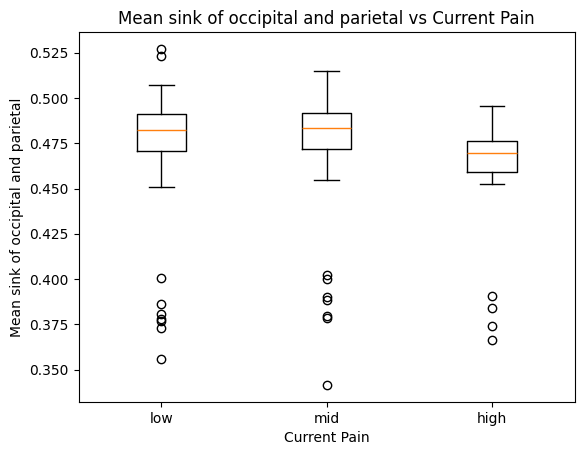

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

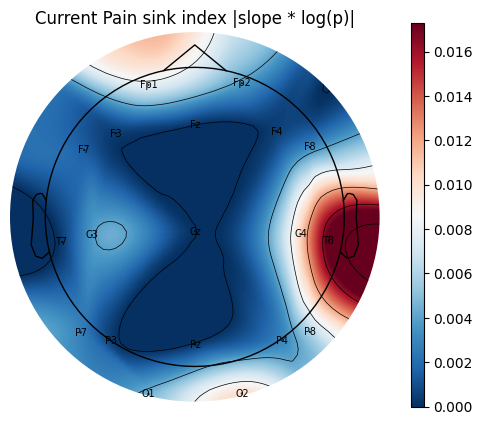

In [71]:
frontal = []
frontalnp = []
# frontalbox = []

# region = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz']
# regiontitle = "frontal"

# region = ['T7', 'C3', 'Cz', 'C4', 'T8']
# regiontitle = "central"

# region =['P7', 'P3', 'Cz', 'P4', 'P8', 'O1', 'O2']
# regiontitle = "occipital and parietal"


# n=2
n=-1

slopetopo = []
ptopo = []
cortopo = []
product = []
while n < chl-1:
    n+=1
    
    healthy = []
    unhealthy = []
    CWP = []
    CBP = []
    JP = []
    NP = []
    
    for i in range(numPatients):
        try:
            np.isnan(xlarray[1, i])
            healthy.append(xlarray2[n, i])
        except TypeError:
            unhealthy.append(xlarray2[n, i])
            match xlarray[1, i]:
                case "CWP":
                    CWP.append(xlarray2[n, i])
                case "CBP":
                    CBP.append(xlarray2[n, i])
                case "PNP":
                    NP.append(xlarray2[n, i])
                    # print(i)
                    # print(xlarray2[n, i])
                case "NP":
                    NP.append(xlarray2[n, i])
                    # print(i)
                    # print(xlarray2[n, i])
                case "JP":
                    JP.append(xlarray2[n, i])
                case "PHN":
                    NP.append(xlarray2[n, i])
                    # print(i)
                    # print(xlarray2[n, i])
    
    # hcsink.append(np.mean(healthy))
    # npsink.append(np.mean(NP))
    # healthy = removeoutliers(healthy)
    # unhealthy = removeoutliers(unhealthy)
    # CBP = removeoutliers(CBP)
    # CWP = removeoutliers(CWP)
    # NP = removeoutliers(NP)
    # JP = removeoutliers(JP)
    
    # plt.boxplot(x=(healthy, CBP), tick_labels = ('healthy', 'back'))
    
    # plt.boxplot(x=(healthy, unhealthy, CBP, CWP, JP, NP), tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'joint', 'neuropathic'), autorange = True)
    # fig, ax = plt.subplots(1,1)
    # ax.boxplot((healthy, unhealthy, CBP, CWP, NP), 0, showfliers=True, tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'neuropathic'))
    # ax.boxplot((healthy, unhealthy), 0, showfliers=False, tick_labels = ('healthy', 'unhealthy'))

    if keep_channels[n] in region:

        frontal.append(NP)
        frontalnp.append(NPain)



    
    y = n


    


    # NP = np.log(NP)
    
    
    # plt.scatter(CBPain, CBP)
    # plt.scatter(CWPain, CWP)
    plt.scatter(NPain, NP)
    # plt.scatter(HCain, healthy)
    plt.xlabel(heads[x])
    plt.ylabel("Mean sink of " + keep_channels[n])
    plt.title("Mean sink of " + keep_channels[n] + " vs " + heads[x])
    # plt.legend(('back', 'widespread', 'neuropathic', 'healthy'))
    # plt.legend(('back', 'widespread', 'neuropathic'))
    plt.legend(('neuropathic',))
    
    
    # plt.legend(('back', 'neuropathic'))
    
    # m,b=np.polyfit(CBPain, CBP, 1)
    # linspace = np.linspace(min(CBPain),max(CBPain))
    # coeffs = [b,m]
    # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
    
    # m,b=np.polyfit(CWPain, CWP, 1)
    # linspace = np.linspace(min(CWPain),max(CWPain))
    # coeffs = [b,m]
    # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
    
    m,b=np.polyfit(NPain, NP, 1, full = False)
    

    linspace = np.linspace(min(NPain),max(NPain))
    coeffs = [b,m]

    
    
    plt.plot(linspace, PolyCoefficients(linspace,coeffs))

    ptopo.append(stats.pearsonr(NPain, NP)[1])
    cortopo.append(stats.pearsonr(NPain, NP)[0])

    slopetopo.append(m)
    
    # m,b=np.polyfit(HCain, healthy, 1)
    # linspace = np.linspace(min(HCain),max(HCain))
    # coeffs = [b,m]
    # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
    
    
    # plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "58metrics", "kruskalpsecondpart" + ".png"))
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, str(n) + ".png"))

    plt.cla()
    plt.clf()


frontalnp = np.asarray(frontalnp)
frontalnp = frontalnp.flatten()
frontal = np.asarray(frontal)
frontal = frontal.flatten()

frontallow=[]
frontalmid=[]
frontalhigh=[]

line=np.max(frontalnp)/3


for i in range(len(frontalnp)):
    if frontalnp[i]<=line:
        frontallow.append(frontal[i])
        # print(frontalbox)
    elif frontalnp[i]>line and frontalnp[i]<=2*line:
        frontalmid.append(frontal[i])
    elif frontalnp[i]>2*line:
        frontalhigh.append(frontal[i])

plt.boxplot((frontallow, frontalmid, frontalhigh),0,showfliers=True,tick_labels=("low", "mid", "high"))

# ax.boxplot((healthy, unhealthy, CBP, CWP, NP), 0, showfliers=True, tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'neuropathic'))

    # plt.scatter(HCain, healthy)
plt.xlabel(heads[x])


# plt.ylabel("Mean sink of frontal")
# plt.title("Mean sink of frontal" + " vs " + heads[x])

plt.ylabel("Mean sink of "+ regiontitle)
plt.title("Mean sink of "+ regiontitle + " vs " + heads[x])

# plt.ylabel("Mean sink of occipital and parietal")
# plt.title("Mean sink of occipital and parietal" + " vs " + heads[x])


# plt.xticks((0,1,2),("low", "mid", "high"))
# plt.legend(('back', 'widespread', 'neuropathic', 'healthy'))
    # plt.legend(('back', 'widespread', 'neuropathic'))
    # plt.legend(('neuropathic',))        
    
    # heads = (pd.read_excel(xllocation, header = None)).to_numpy()[0]
    
    # plt.title("Singular Value " + str(n))
    # x = 31
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, regiontitle + ".png"))
# plt.plot(range(len(healthy)), healthy)

pos = np.array([montage.get_positions()["ch_pos"][ch][:2] for ch in keep_channels])

fig, ax = plt.subplots()
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(np.mean(maxdata, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)

im,cm = mne.viz.plot_topomap(ptopo, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels)
ax_x_start = 0.85
ax_x_width = 0.02
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
ax.set_title(heads[x] + " sink index p values")
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, "pvals", "pvals" + heads[x] + ".png"))

plt.cla()
plt.clf()




fig, ax = plt.subplots()
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
    # mne.viz.plot_topomap(np.mean(maxdata, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)

im,cm = mne.viz.plot_topomap(slopetopo, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels)
ax_x_start = 0.85
ax_x_width = 0.02
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
ax.set_title(heads[x] + " sink index slope")
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, "slope", "slope" + heads[x] + ".png"))

plt.cla()
plt.clf()


product = np.abs(np.asarray(slopetopo)*np.log(np.asarray(ptopo)))

fig,ax = plt.subplots(ncols=1)
im,cm   = mne.viz.plot_topomap(product, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels)


# manually fiddle the position of colorbar
ax_x_start = 0.85
ax_x_width = 0.02
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
ax.set_title(heads[x] + " sink index |slope * log(p)|")

fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder,"product", "product" + heads[x] + ".png"))



In [102]:
print(NPain)

[3.0, 3.0, 8.0, 5.0, 4.0, 6.0, 4.5, 4.0, 8.0, 5.0, 4.0, 7.0, 6.0, 1.0, 4.0, 4.0, 8.0, 0.0]


In [56]:

def twohoursthirtymin():
    frontal = []
    frontalnp = []
    # frontalbox = []
    
    # region = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz']
    # regiontitle = "frontal"
    
    # region = ['T7', 'C3', 'Cz', 'C4', 'T8']
    # regiontitle = "central"
    
    # region =['P7', 'P3', 'Cz', 'P4', 'P8', 'O1', 'O2']
    # regiontitle = "occipital and parietal"
    
    
    # n=2
    n=-1
    
    slopetopo = []
    ptopo = []
    cortopo = []
    product = []
    while n < chl-1:
        n+=1
        
        healthy = []
        unhealthy = []
        CWP = []
        CBP = []
        JP = []
        NP = []
        
        for i in range(numPatients):
            try:
                np.isnan(xlarray[1, i])
                healthy.append(xlarray2[n, i])
            except TypeError:
                unhealthy.append(xlarray2[n, i])
                match xlarray[1, i]:
                    case "CWP":
                        CWP.append(xlarray2[n, i])
                    case "CBP":
                        CBP.append(xlarray2[n, i])
                    case "PNP":
                        NP.append(xlarray2[n, i])
                        # print(i)
                        # print(xlarray2[n, i])
                    case "NP":
                        NP.append(xlarray2[n, i])
                        # print(i)
                        # print(xlarray2[n, i])
                    case "JP":
                        JP.append(xlarray2[n, i])
                    case "PHN":
                        NP.append(xlarray2[n, i])
                        # print(i)
                        # print(xlarray2[n, i])

        NP = CBP
        
        # hcsink.append(np.mean(healthy))
        # npsink.append(np.mean(NP))
        # healthy = removeoutliers(healthy)
        # unhealthy = removeoutliers(unhealthy)
        # CBP = removeoutliers(CBP)
        # CWP = removeoutliers(CWP)
        # NP = removeoutliers(NP)
        # JP = removeoutliers(JP)
        
        # plt.boxplot(x=(healthy, CBP), tick_labels = ('healthy', 'back'))
        
        # plt.boxplot(x=(healthy, unhealthy, CBP, CWP, JP, NP), tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'joint', 'neuropathic'), autorange = True)
        # fig, ax = plt.subplots(1,1)
        # ax.boxplot((healthy, unhealthy, CBP, CWP, NP), 0, showfliers=True, tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'neuropathic'))
        # ax.boxplot((healthy, unhealthy), 0, showfliers=False, tick_labels = ('healthy', 'unhealthy'))
    
        if keep_channels[n] in region:
            if regiontitle == "frontaldenominator":
    
                frontald.append(NP)

            if regiontitle == "parietalnumerator":
                parietal.append(NP)
            
            frontal.append(NP)
            frontalnp.append(NPain)
    
    
    
        
        y = n
    
    
        
    
    
        # NP = np.log(NP)
        plt.cla()
        plt.clf()

        
        # plt.scatter(CBPain, CBP)
        # plt.scatter(CWPain, CWP)
        plt.scatter(NPain, NP)
        # plt.scatter(HCain, healthy)
        plt.xlabel(heads[x])
        plt.ylabel("Mean " + datatype + " " + "of " + keep_channels[n])
        plt.title("Mean " + datatype + " " + "of " + keep_channels[n] + " vs " + heads[x])
        # plt.legend(('back', 'widespread', 'neuropathic', 'healthy'))
        # plt.legend(('back', 'widespread', 'neuropathic'))
        plt.legend(('neuropathic',))


        
        
        # plt.legend(('back', 'neuropathic'))
        
        # m,b=np.polyfit(CBPain, CBP, 1)
        # linspace = np.linspace(min(CBPain),max(CBPain))
        # coeffs = [b,m]
        # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
        
        # m,b=np.polyfit(CWPain, CWP, 1)
        # linspace = np.linspace(min(CWPain),max(CWPain))
        # coeffs = [b,m]
        # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
        
        m,b=np.polyfit(NPain, NP, 1, full = False)
        
    
        linspace = np.linspace(min(NPain),max(NPain))
        coeffs = [b,m]
    
        
        
        plt.plot(linspace, PolyCoefficients(linspace,coeffs))
    
        ptopo.append(stats.pearsonr(NPain, NP)[1])
        cortopo.append(stats.pearsonr(NPain, NP)[0])

        slopetopo.append(m)
        
        # m,b=np.polyfit(HCain, healthy, 1)
        # linspace = np.linspace(min(HCain),max(HCain))
        # coeffs = [b,m]
        # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
        
        
        # plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "58metrics", "kruskalpsecondpart" + ".png"))
        plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, str(n) + ".png"))
    
        plt.cla()
        plt.clf()
    
    
    frontalnp = np.asarray(frontalnp)
    frontalnp = frontalnp.flatten()
    frontal = np.asarray(frontal)
    frontal = frontal.flatten()
    
    frontallow=[]
    frontalmid=[]
    frontalhigh=[]
    
    line=np.max(frontalnp)/3
    
    
    for i in range(len(frontalnp)):
        if frontalnp[i]<=line:
            frontallow.append(frontal[i])
            # print(frontalbox)
        elif frontalnp[i]>line and frontalnp[i]<=2*line:
            frontalmid.append(frontal[i])
        elif frontalnp[i]>2*line:
            frontalhigh.append(frontal[i])
    
    plt.boxplot((frontallow, frontalmid, frontalhigh),0,showfliers=True,tick_labels=("low", "mid", "high"))
    
    # ax.boxplot((healthy, unhealthy, CBP, CWP, NP), 0, showfliers=True, tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'neuropathic'))
    
        # plt.scatter(HCain, healthy)
    plt.xlabel(heads[x])
    
    
    # plt.ylabel("Mean " + datatype + " " + "of frontal")
    # plt.title("Mean " + datatype + " " + "of frontal" + " vs " + heads[x])
    
    plt.ylabel("Mean " + datatype + " " + "of "+ regiontitle)
    plt.title("Mean " + datatype + " " + "of "+ regiontitle + " vs " + heads[x])
    
    # plt.ylabel("Mean " + datatype + " " + "of occipital and parietal")
    # plt.title("Mean " + datatype + " " + "of occipital and parietal" + " vs " + heads[x])
    
    
    # plt.xticks((0,1,2),("low", "mid", "high"))
    # plt.legend(('back', 'widespread', 'neuropathic', 'healthy'))
        # plt.legend(('back', 'widespread', 'neuropathic'))
        # plt.legend(('neuropathic',))        
        
        # heads = (pd.read_excel(xllocation, header = None)).to_numpy()[0]
        
        # plt.title("Singular Value " + str(n))
        # x = 31
    plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, regiontitle + ".png"))

    plt.cla()
    plt.clf()
    # plt.plot(range(len(healthy)), healthy)
    
    pos = np.array([montage.get_positions()["ch_pos"][ch][:2] for ch in keep_channels])
    
    fig, ax = plt.subplots()
        # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
        # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
        # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
        # mne.viz.plot_topomap(np.mean(maxdata, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    
    im,cm = mne.viz.plot_topomap(ptopo, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels, vlim=(0,0.2))
    ax_x_start = 0.85
    ax_x_width = 0.02
    ax_y_start = 0.1
    ax_y_height = 0.8
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    ax.set_title(heads[x] + " " + datatype + " " + "p values")
    fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, "pvals", "pvals" + heads[x] + ".png"))
    
    plt.cla()
    plt.clf()
    
    
    
    
    fig, ax = plt.subplots()
        # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
        # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
        # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
        # mne.viz.plot_topomap(np.mean(maxdata, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    
    im,cm = mne.viz.plot_topomap(slopetopo, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels)
    ax_x_start = 0.85
    ax_x_width = 0.02
    ax_y_start = 0.1
    ax_y_height = 0.8
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    ax.set_title(heads[x] + " " + datatype + " " + "slope")
    fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, "slope", "slope" + heads[x] + ".png"))
    
    plt.cla()
    plt.clf()
    

    
    fig, ax = plt.subplots()
        # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
        # mne.viz.plot_topomap(np.mean(sink_indices, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
        # mne.viz.plot_topomap(sink_indices[1726], xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True)
        # mne.viz.plot_topomap(np.mean(maxdata, axis = 0), xypos, size = 2, axes = ax, vlim=(0,1), cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = True, names = keep_channels)
    
    im,cm = mne.viz.plot_topomap(cortopo, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels)
    ax_x_start = 0.85
    ax_x_width = 0.02
    ax_y_start = 0.1
    ax_y_height = 0.8
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    ax.set_title(heads[x] + " " + datatype + " " + "correlation")
    fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, "correlation", "correlation" + heads[x] + ".png"))
    
    plt.cla()
    plt.clf()
    
    # manually fiddle the position of colorbar
    #no more product

    # product = np.abs(np.asarray(slopetopo)*np.log(np.asarray(ptopo)))
    
    # fig,ax = plt.subplots(ncols=1)
    # im,cm   = mne.viz.plot_topomap(product, pos, size = 2, axes = ax, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels)

    
    # ax_x_start = 0.85
    # ax_x_width = 0.02
    # ax_y_start = 0.1
    # ax_y_height = 0.8
    # cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    # clb = fig.colorbar(im, cax=cbar_ax)
    # ax.set_title(heads[x] + " " + datatype + " " + "|slope * log(p)|")
    
    # fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder,"product", "product" + heads[x] + ".png"))
    
    return

# twohoursthirtymin()

In [98]:
frontald = []
parietal = []

# region = ['Fp1', 'Fp2']
# regiontitle = "Mid_Frontal"
# twohoursthirtymin()

# region = ['F3', 'F7']
# regiontitle = "Left_Frontal"
# twohoursthirtymin()

# region = ['F4','F8']
# regiontitle = "Right_Frontal"
# twohoursthirtymin()

# region = ['T7','C3']
# regiontitle = "Left_Central"
# twohoursthirtymin()

# region = ['T8','F4']
# regiontitle = "Right_Central"
# twohoursthirtymin()

# region = ['P7','P3']
# regiontitle = "Left_Parietal"
# twohoursthirtymin()

# region = ['P8','P4']
# regiontitle = "Right_Parietal"
# twohoursthirtymin()

# region = ['O1','O2']
# regiontitle = "Occipital"
# twohoursthirtymin()



region = ['F3']
denom=str(region)
regiontitle = "frontaldenominator"
twohoursthirtymin()

    
# region = ['T7', 'C3', 'Cz', 'C4', 'T8']
# regiontitle = "_central"
# twohoursthirtymin()

# region =['Pz']

region =['P4']
numer=str(region)
regiontitle = "parietalnumerator"
twohoursthirtymin()

# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomial of order 2.
# This is a polynomi

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [99]:
frontald = np.asarray(frontald)
parietal = np.asarray(parietal)

print(frontald)
print()
print(parietal)


[[0.42019567 0.43269862 0.4558188  0.42670435 0.42399202 0.43777702
  0.42863164 0.42085084 0.42785861 0.42737045 0.42405553 0.43039438
  0.40827041 0.4204176  0.41891126 0.43187897 0.43746929 0.42339418
  0.43365797 0.42576908 0.42723783 0.4220903  0.40288901 0.42909892
  0.41621411 0.42000673 0.42607863 0.43337551 0.40286287 0.43434282
  0.42132388 0.43955843 0.43576142 0.42792596 0.42296823 0.42146006
  0.42965639 0.40900468 0.428024   0.4359202  0.40009404 0.62399995
  0.42343283 0.43997725 0.41327283 0.40106452 0.42450137]]

[[0.49333663 0.46204141 0.47984261 0.48823604 0.4750271  0.47024072
  0.48478245 0.50315645 0.45499007 0.46910481 0.47399897 0.46707407
  0.49410443 0.47114113 0.48494515 0.47810011 0.47836721 0.48521024
  0.4859922  0.49318825 0.49109965 0.49503592 0.50435429 0.48804982
  0.45574138 0.46601418 0.48262026 0.47665366 0.49467962 0.48261763
  0.47411666 0.47159008 0.48281301 0.47143774 0.46721426 0.48154746
  0.50595796 0.4982055  0.48272994 0.47626354 0.4815742 

In [100]:
print(meanparietal)

[0.50372368 0.46732875 0.47421227 0.47794658 0.47149266 0.46982525
 0.48047364 0.50610342 0.45906851 0.47910238 0.48213495 0.46990447
 0.4901438  0.47650767 0.48926661 0.48054834 0.46838808 0.4752465
 0.48803987 0.48296741 0.49115103 0.48830955 0.49018662 0.48794869
 0.47358903 0.50539147 0.4774939  0.47006815 0.48700779 0.46715351
 0.48652168 0.47248478 0.47490949 0.47519757 0.45956013 0.48220281
 0.48673089 0.49590898 0.48381435 0.472032   0.46884925 0.46436066
 0.4826039  0.46428067 0.47584258 0.47558421 0.4775884 ]


[0.42019567 0.43269862 0.4558188  0.42670435 0.42399202 0.43777702
 0.42863164 0.42085084 0.42785861 0.42737045 0.42405553 0.43039438
 0.40827041 0.4204176  0.41891126 0.43187897 0.43746929 0.42339418
 0.43365797 0.42576908 0.42723783 0.4220903  0.40288901 0.42909892
 0.41621411 0.42000673 0.42607863 0.43337551 0.40286287 0.43434282
 0.42132388 0.43955843 0.43576142 0.42792596 0.42296823 0.42146006
 0.42965639 0.40900468 0.428024   0.4359202  0.40009404 0.62399995
 0.42343283 0.43997725 0.41327283 0.40106452 0.42450137]
[0.49333663 0.46204141 0.47984261 0.48823604 0.4750271  0.47024072
 0.48478245 0.50315645 0.45499007 0.46910481 0.47399897 0.46707407
 0.49410443 0.47114113 0.48494515 0.47810011 0.47836721 0.48521024
 0.4859922  0.49318825 0.49109965 0.49503592 0.50435429 0.48804982
 0.45574138 0.46601418 0.48262026 0.47665366 0.49467962 0.48261763
 0.47411666 0.47159008 0.48281301 0.47143774 0.46721426 0.48154746
 0.50595796 0.4982055  0.48272994 0.47626354 0.4815742  0.47311404
 0.49

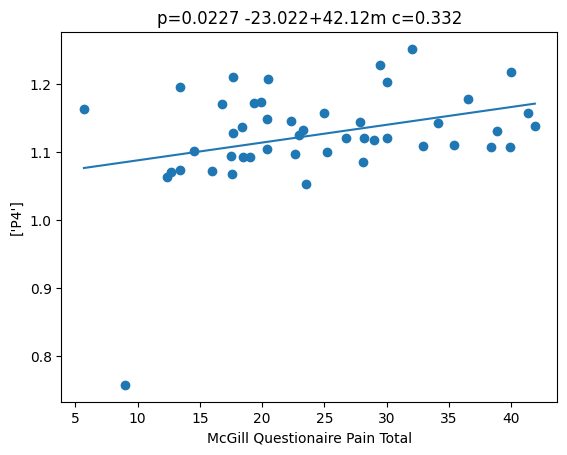

In [101]:
# meanfront = np.mean(frontald, axis=0)
meanfront=frontald[0]
print(meanfront)

# meanparietal = np.mean(parietal, axis=0)
meanparietal = parietal[0]
print(meanparietal)
# for i in frontald:
#     print(i)

realtest = meanparietal/meanfront
# realtest = 1/meanfront


# realtest = meanparietal

plt.scatter(NPain,realtest)

m,b=np.polyfit(NPain, realtest, 1, full = False)
        
    
linspace = np.linspace(min(NPain),max(NPain))
coeffs = [b,m]

plt.plot(linspace, PolyCoefficients(linspace,coeffs))

m,b=np.polyfit(realtest, NPain, 1, full = False)


plt.title("p="+str(np.round(stats.pearsonr(NPain, realtest)[1],4)) + " " + str(np.round(b,3)) + "+" + str(np.round(m,3))+"m c="+str(np.round(stats.pearsonr(NPain, realtest)[0],3)))
plt.xlabel(heads[x])
# plt.ylabel(numer+"/"+denom)
plt.ylabel(numer)

plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs",heads[x] + "pvalue.png"))

In [71]:
# frontalnp.append(NPain)
frontal = np.asarray(frontal).flatten()
frontalnp = np.asarray(frontalnp).flatten()

plt.scatter(frontalnp, frontal)
    # plt.scatter(HCain, healthy)
plt.xlabel(heads[x])
plt.ylabel("Mean sink of " + 'frontal')
plt.title("Mean sink of " + 'frontal' + " vs " + heads[x])

# plt.ylabel("Mean sink of " + 'central')
# plt.title("Mean sink of " + 'central' + " vs " + heads[x])

# plt.ylabel("Mean sink of " + 'occipital and parietal')
# plt.title("Mean sink of " + 'occipital and parietal' + " vs " + heads[x])

    # plt.legend(('back', 'widespread', 'neuropathic', 'healthy'))
    # plt.legend(('back', 'widespread', 'neuropathic'))
plt.legend(('neuropathic',))
    
    
    # plt.legend(('back', 'neuropathic'))
    
    # m,b=np.polyfit(CBPain, CBP, 1)
    # linspace = np.linspace(min(CBPain),max(CBPain))
    # coeffs = [b,m]
    # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
    
    # m,b=np.polyfit(CWPain, CWP, 1)
    # linspace = np.linspace(min(CWPain),max(CWPain))
    # coeffs = [b,m]
    # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
    
m,b=np.polyfit(frontalnp, frontal, 1)
linspace = np.linspace(min(NPain),max(NPain))
coeffs = [b,m]
plt.plot(linspace, PolyCoefficients(linspace,coeffs))


slopetopo.append(m)
    
    # m,b=np.polyfit(HCain, healthy, 1)
    # linspace = np.linspace(min(HCain),max(HCain))
    # coeffs = [b,m]
    # plt.plot(linspace, PolyCoefficients(linspace,coeffs))
    
    
    # plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "58metrics", "kruskalpsecondpart" + ".png"))
plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, 'frontal' + ".png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, 'central' + ".png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, 'back' + ".png"))


plt.cla()
plt.clf()

NameError: name 'frontal' is not defined

In [190]:
"27-33"
'27-29-31-32'

'27-33'

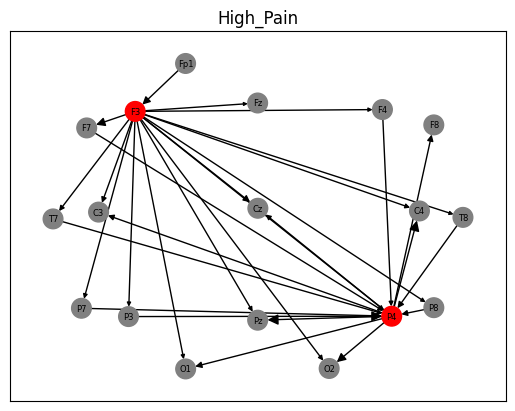

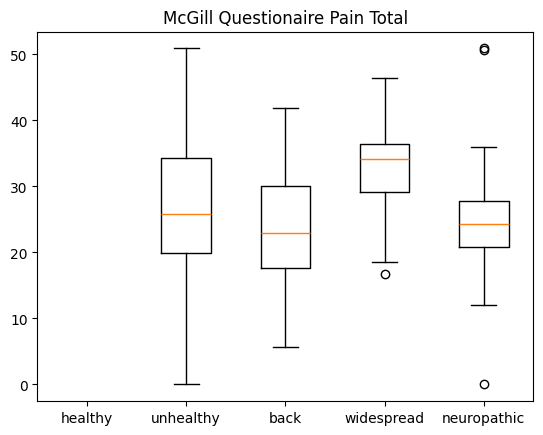

In [97]:
n=33
# n+=1
x=n
# n+=1

healthy = []
unhealthy = []
CWP = []
CBP = []
JP = []
NP = []

for i in range(numPatients):
    try:
        np.isnan(xlarray[1, i])
        healthy.append(xlarray[n, i])
    except TypeError:
        unhealthy.append(xlarray[n, i])
        match xlarray[1, i]:
            case "CWP":
                CWP.append(xlarray[n, i])
            case "CBP":
                CBP.append(xlarray[n, i])
                amatconnection(i,xlarray[n, i])

            case "JP":
                JP.append(xlarray[n, i])
            case "PNP":
                NP.append(xlarray[n, i])
                # amatconnection(i,xlarray[n, i])
                
            case "NP":
                NP.append(xlarray[n, i])
                # amatconnection(i,xlarray[n, i])

            case "PHN":
                NP.append(xlarray[n, i])
                # amatconnection(i,xlarray[n, i])


# healthy = removeoutliers(healthy)
# unhealthy = removeoutliers(unhealthy)
# CBP = removeoutliers(CBP)
# CWP = removeoutliers(CWP)
# NP = removeoutliers(NP)
# JP = removeoutliers(JP)

# plt.boxplot(x=(healthy, CBP), tick_labels = ('healthy', 'back'))

# plt.boxplot(x=(healthy, unhealthy, CBP, CWP, JP, NP), tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'joint', 'neuropathic'), autorange = True)
fig, ax = plt.subplots(1,1)
ax.boxplot((healthy, unhealthy, CBP, CWP, NP), 0, showfliers=True, tick_labels = ('healthy', 'unhealthy', 'back', 'widespread', 'neuropathic'))
# ax.boxplot((CBP, CWP, NP), 0, showfliers=True, tick_labels = ('back', 'widespread', 'neuropathic'))
# ax.boxplot((CBP, NP), 0, showfliers=True, tick_labels = ('back', 'neuropathic'))
#

# ax.boxplot((healthy, unhealthy), 0, showfliers=False, tick_labels = ('healthy', 'unhealthy'))



heads = (pd.read_excel(xllocation, header = None)).to_numpy()[0]

plt.title(heads[n])

# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "58metrics", "kruskalpsecondpart" + ".png"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "10-20metrics", heads[n] + ".png"))

# plt.plot(range(len(healthy)), healthy)
# plt.cla()
# plt.clf()
# x = 27
# # y += 1
# y = n

# plt.scatter(CBPain, CBP)
# plt.scatter(CWPain, CWP)
# plt.scatter(NPain, NP)
# plt.xlabel(heads[x])
# plt.ylabel(heads[y])
# plt.title(heads[x]+ " vs "+ heads[y])
# plt.legend(('back', 'widespread', 'neuropathic'))
# # plt.legend(('back', 'neuropathic'))

# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "CurpainPlots", heads[y] + ".svg"))
# plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "Durpain", heads[y] + ".svg"))

NPain = CBP
# condcor.append(NP)

In [87]:
condcor = []
# condcor.append(NP)

In [95]:
print(condcor)

[[3.0, 3.0, 8.0, 5.0, 4.0, 6.0, 4.5, 4.0, 8.0, 5.0, 4.0, 7.0, 6.0, 1.0, 4.0, 4.0, 8.0, 0.0], [4.0, 4.0, 7.5, 7.8, 4.0, 8.0, 6.0, 5.0, 8.0, 7.0, 6.0, 5.0, 4.0, 4.0, 5.0, 6.0, 7.0, 0.0], [60.0, 108.0, 84.0, 36.0, 48.0, 21.0, 36.0, 24.0, 108.0, 96.0, 72.0, 24.0, 48.0, 24.0, 120.0, 16.0, 25.0, 60.0], [13.5, 15.4, 22.35, 4.0, 11.4, 3.4, 3.4, 25.5, 17.2, 10.9, 10.3, 5.8, 8.4, 3.8, 7.8, 0.0, 23.1, 0.0], [16.0, 28.0, 32.0, 12.0, 18.0, 17.0, 21.5, 24.0, 25.0, 28.0, 22.0, 10.0, 16.0, 23.0, 28.0, 20.0, 20.0, 0.0], [16.0, 28.0, 59.0, 26.0, 19.0, 17.0, 24.0, 52.0, 53.0, 35.0, 13.0, 23.0, 13.0, 11.0, 22.0, 37.0, 29.0, 0.0], [20.98, 27.6, 50.7, 12.0, 24.0, 23.3, 19.2, 25.6, 26.0, 23.0, 35.9, 20.8, 20.0, 24.7, 27.9, 30.0, 50.9, 0.0]]


In [96]:
condcormat = []

In [97]:
for i in condcor:
    condrow = []
    for j in condcor:
        condrow.append(stats.pearsonr(i, j)[0])
    condcormat.append(condrow)
condcormat = np.asarray(condcormat)


In [120]:
print(heads[27:])

['Current Pain' 'Avg Pain' 'Pain Duration (Months)'
 'Medication Quantification Scale' 'Pain Disability Questionaire'
 'Pain Disability Index' 'McGill Questionaire Pain Total']


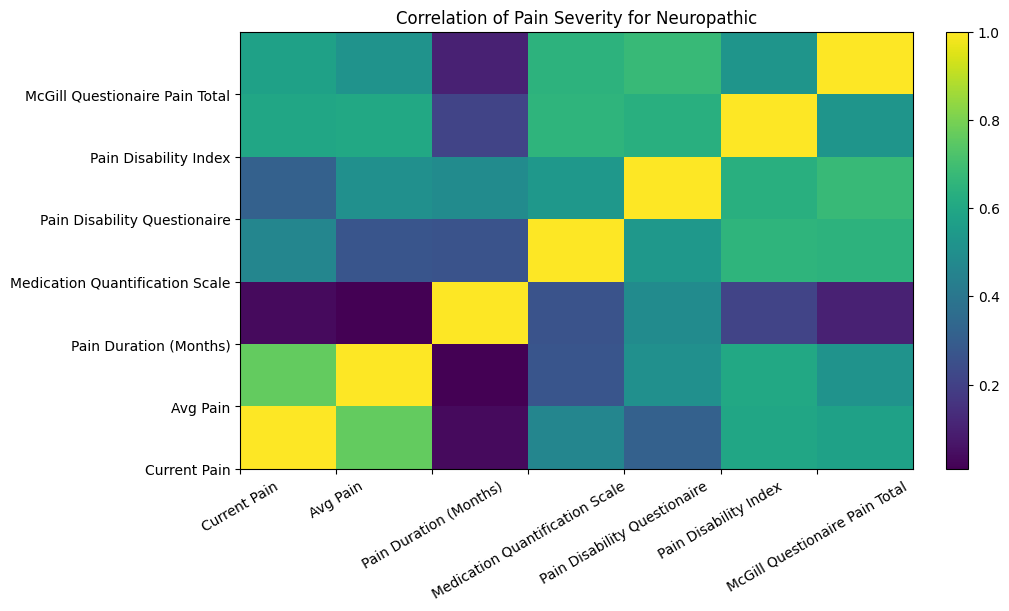

In [104]:

n = len([cmap])
fig, axs = plt.subplots(1, n, figsize=(n * 2 * 4 + 2, 3 * 2),
                        layout='constrained', squeeze=False)
for [ax, cmap] in zip(axs.flat, [cmap]):
    psm = ax.pcolormesh(condcormat, cmap=cmap, rasterized=True)
    fig.colorbar(psm, ax=ax)

plt.yticks(range(7),(heads[27:]))
plt.xticks(range(7),(heads[27:]),rotation=30)


    # plt.title("correlation between channels")
# amatview += 1
# plt.show()
# m+=1
plt.title("Correlation of Pain Severity for Neuropathic")
fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "corpainconditions.png"))

In [99]:

print(cm)

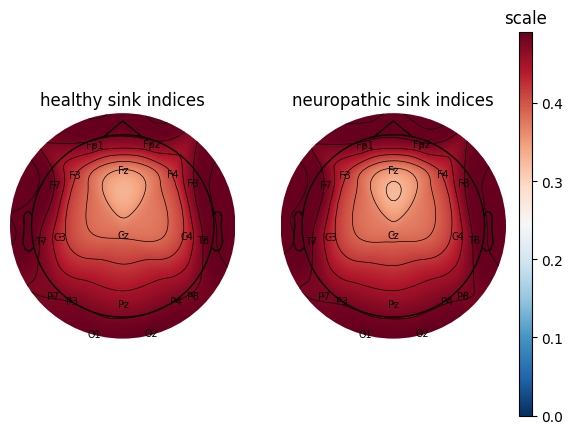

In [101]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm   = mne.viz.plot_topomap(hcsink, pos, size = 2, axes = ax1, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels) 
im,cm   = mne.viz.plot_topomap(npsink, pos, size = 2, axes = ax2, cmap = 'RdBu_r', extrapolate = 'head', outlines = 'head', show = False, names = keep_channels)

# manually fiddle the position of colorbar
ax_x_start = 0.92
ax_x_width = 0.02
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title("scale") # title on top of colorbar
ax1.set_title("healthy sink indices")
ax2.set_title("neuropathic sink indices")

fig.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", folder, "hcsink" + ".png"))

In [161]:
CWPain = CWP
CBPain = CBP
NPain = NP
HCain = healthy

In [80]:
print(n)

24


In [179]:
print(paindur)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 360.0 120.0 96.0 22.0 480.0 180.0 164.0 48.0
 132.0 24.0 31.0 15.0 18.0 108.0 120.0 252.0 300.0 360.0 60.0 18.0 16.0
 80.0 144.0 64.0 46.0 300.0 300.0 180.0 96.0 240.0 180.0 54.0 122.0 36.0
 60.0 108.0 24.0 84.0 84.0 36.0 480.0 24.0 48.0 192.0 72.0 21.0 324.0 36.0
 23.0 180.0 213.0 264.0 24.0 72.0 108.0 120.0 96.0 36.0 420.0 72.0 24.0
 48.0 84.0 204.0 72.0 252.0 31.0 7.0 24.0 324.0 108.0 36.0 204.0 120.0
 120.0 48.0 16.0 25.0 60.0 54.0 17.0 nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]


In [180]:
print(CBPain)

[5.0, 4.0, 5.0, 7.0, 8.0, 3.0, 7.0, 6.0, 3.0, 5.0, 6.0, 8.0, 5.0, 6.0, 5.0, 9.0, 5.0, 6.0, 7.0, 4.0, 5.5, 5.0, 4.0, 0.5, 4.0, 5.0, 4.0, 4.0, 7.5, 5.0, 3.0, 5.0, 6.5, 3.0, 5.0, 6.0, 3.5, 4.0, 8.0, 2.0, 7.0, 4.0, 6.0, 3.0, 1.0, 3.5, 6.5]


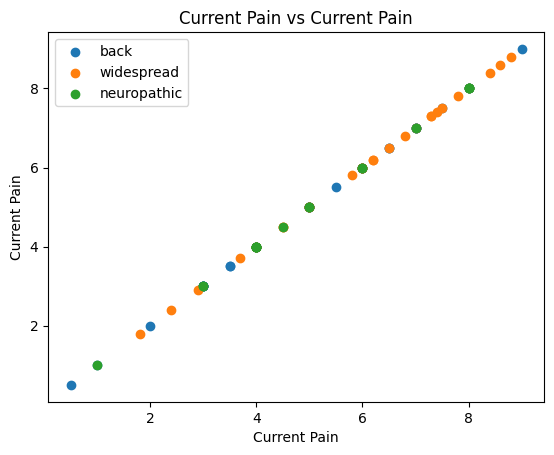

In [178]:
x = 27
# y += 1
y = n

plt.scatter(CBPain, CBP)
plt.scatter(CWPain, CWP)
plt.scatter(NPain, NP)
plt.xlabel(heads[x])
plt.ylabel(heads[y])
plt.title(heads[x]+ " vs "+ heads[y])
plt.legend(('back', 'widespread', 'neuropathic'))

plt.savefig(os.path.join(mainfolder + "Archive\\Old_Graphs", "CurpainPlots", heads[y] + ".svg"))


In [327]:

hcstats = []
pastats = []
CWPstats = []
CBPstats = []
JPstats = []
NPstats = []

##remove unwanted data from participants

x = 0

while x < (len(participants)):
    try: 
        np.isnan(participants[x][5])
        hcstats.append(participants[x])
    except TypeError:
        pastats.append(participants[x])
        match participants[x, 5]:
            case "CWP":
                CWPstats.append(participants[x])
            case "CBP":
                CBPstats.append(participants[x])
            case "PNP":
                NPstats.append(participants[x])
            case "NP":
                NPstats.append(participants[x])
            case "JP":
                JPstats.append(participants[x])
            case "PHN":
                NPstats.append(participants[x])        
    x += 1


hcstats = np.asarray(hcstats).transpose()
pastats = np.asarray(pastats).transpose()
CWPstats = np.asarray(CWPstats).transpose()
CBPstats = np.asarray(CBPstats).transpose()
JPstats = np.asarray(JPstats).transpose()
NPstats = np.asarray(NPstats).transpose()

In [208]:
print(hcstats.shape)

(20, 88)
(189, 20)


In [203]:
print(dtypes)

participant_id     object
group              object
study              object
sex                object
age                 int64
diagnosis          object
BDI               float64
STAIX1            float64
STAIX2            float64
McGill_sens       float64
McGill_affec      float64
McGill_total      float64
CurrPain          float64
AvgPain           float64
PDQ               float64
painDur           float64
VR12_PCS          float64
VR12_MCS          float64
PDI               float64
MQS               float64
dtype: object


In [243]:
def condstats(condition):
    condlist = [condition[5,0]]
    for i in range(condition.shape[0]):
        summary = ''
        if dtypes.iloc[i] == "object":
            condsum = []
            condnum = []
            for j in condition[i]:
                if j not in condsum:
                    condsum.append(j)
                    x = 0
                    for k in condition[i]:
                        if k == j:
                            x += 1
                    condnum.append(x)
            for l in range(len(condsum)):
                summary += str(condnum[l]) + " " + str(condsum[l])
                if l < len(condsum)-1:
                    summary += ", "
        else:
            condsum = []
            deletes = []
            for j in range(len(condition[i])):
                # try:
                #     np.isnan(condition[i][j])
                #     # deletes.append(j)
                #     # print(condition[i][j])
                # except TypeError:            
                #     print("")
                if np.isnan(condition[i][j])==True:
                    deletes.append(j)
            condsum = np.delete(condition[i], deletes)
            if len(condsum) == 0:
                summary = "n/a"
            else:
                summary = str(round(np.mean(condsum), 2)) + "±" + str(round(np.std(condsum), 2))

        condlist.append(summary)


    
    # condlist = np.delete(condlist, (0,1,5))
    condlist = np.delete(condlist, (1, 2))
    
    return condlist

# print(condstats(hcstats))

In [253]:
print(condstats(participants.transpose()))

['CWP' '42 FM, 34 CBP, 113 NCCP' '60 m, 129 f' '57.85±13.86'
 '30 CWP, 0 nan, 47 CBP, 6 PNP, 7 PHN, 5 NP, 6 JP' '10.15±9.38'
 '35.53±9.66' '37.73±11.5' '14.68±6.08' '4.13±2.83' '27.09±9.31'
 '5.23±1.9' '5.64±1.57' '17.43±6.41' '121.79±113.67' '31.77±7.7'
 '46.45±11.83' '27.39±14.04' '8.04±7.45']


In [283]:
summarray = np.asarray([condstats(participants.transpose()),condstats(pastats),condstats(hcstats),condstats(CBPstats),condstats(CWPstats),condstats(NPstats),condstats(JPstats)])

             
summarray[0,0] = "participants"
summarray[1,0] = "patients"
summarray[2,0] = "healthy controls"

np_to_excel(mainfolder+"summary.xlsx", summarray.transpose(), [], [])

## this is the smartest jank ive ever done
# np_to_excel(mainfolder+"summary.xlsx", np.asarray((pcolumns, np.empty(20))).transpose(), [], [])


In [278]:
print(len(pcolumns))

20
